# Imports, initializations and functions

In [477]:
import numpy as np
from numpy import loadtxt
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import axes3d

from itertools import groupby
from datetime import datetime
import datetime as dtt
from datetime import timedelta
import math
import scipy
from scipy import stats
from scipy.stats import norm
import statistics
import scipy.signal as signal 
import pymannkendall as mk 
from scipy.stats import shapiro
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

from windstorms import *

In [3]:
years = np.arange(2002,2023,1)        # 2002 - 2022
years_merra2 = np.arange(2002,2021,1) # 2002 - 2020
years_merra2_full = np.arange(1980,2021,1)  # 1980 - 2020

# Storm statistics
minutes_over_threshold = np.zeros(len(years))
windstorms_1min = np.zeros(len(years))
windstorms_monthly = np.zeros(len(years))
windstorm_hours = np.zeros(len(years))
windstorms_merra2 = np.zeros(len(years)-2)
windstorms_merra2_full = np.zeros(len(years_merra2_full))
windstorms_hourly = np.zeros(len(years)-2)
storm_durations_mean = np.zeros(len(years))
storm_durations_median = np.zeros(len(years))
storm_speeds_mean= np.zeros(len(years))
storm_speeds_median = np.zeros(len(years))
storm_times = []

# Lull statistics
lulls = np.zeros(len(years))
lull_durations_mean = np.zeros(len(years))
lull_durations_median = np.zeros(len(years))
lulls_perstorm_mean = np.zeros(len(years))
lulls_perstorm_median = np.zeros(len(years))

### Functions

In [4]:
def storm_details(storm_number):
    lull_durations = [lull.duration for lull in storms_with_lulls[storm_number].lulls]
    print(f'The storm lasted {storms_with_lulls[storm_number].duration} minutes with {len(lull_durations)} lulls which lasted {np.median(lull_durations)} minutes on average, totaling {sum(lull_durations)} minutes.')

def doy_to_date(day_of_year, year):
    day_of_year = str(day_of_year) 
    year = str(year)
    day_of_year.rjust(3 + len(day_of_year), '0') # adjusting day number
    res = datetime.strptime(year + "/" + day_of_year, "%Y/%j").strftime("%m/%d/%Y") # converting to date
    return str(res) 

# compute time of day from index
def mod1440_start(input_list):
    return [storm.start_index % 1440 for storm in input_list]

def mod1440_stop(input_list):
    return [storm.stop_index % 1440 for storm in input_list]

def count_over_thresholds(speeds: pd.Series, speed_threshold: float, directions: pd.Series, direction_thresholds: list):
    count = 0
    for index, (speed, direction) in enumerate(zip(speeds, directions)):
        if (speed >= speed_threshold) and (direction_thresholds[0] <= direction <= direction_thresholds[1]):
            count += 1
    return count

# create a red noise model
def create_normalized_redfit(data_length,Te):
    freq = np.arange(0,(data_length/2)+1,1)/float(data_length) # to Nyquist
    red_fit = (2 * Te)/(1 + ((2*np.pi*freq)**2)*(Te**2)) # After Hartmann 6.64, 6.91
    return red_fit/np.sum(red_fit)

def create_f_bounds(alpha,dof,red_fit_n):
    f_ratio = stats.f.ppf(alpha,dof,200) # Note: 200 = large degree of freedom value for red noise
    return f_ratio*red_fit_n

# convert HHMM to datetime.time
def format_time(time):
    time = "{0:04d}".format(int(time)) # format the time as string
    hhmm = dtt.time(int(time[0:2]), int(time[2:4])) # extract hh and mm and then convert to time
    return hhmm

# Classify windstorms with 1-minute data

In [126]:
storm_starttimes_mod1440 = []
storm_stoptimes_mod1440 = []
storm_times_mod1440 = []

height='10m'
subset = ['Year', 'DOY', 'MST', f'Avg Wind Speed @ {height} [m/s]', f'Avg Wind Direction @ {height} [deg]']

for i in np.arange(2002,2023,1): 
    year = i
    df = pd.read_csv(f'/Users/serena/Documents/Research/Data/{year}_data.csv', usecols=lambda x: x in subset)
    df.insert(2, 'Date', df['DOY'].apply(doy_to_date, args=(year,))) 
    df = df.replace(-99999.0, np.nan)
    df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y') # convert date column to DateTime
    df.set_index('Date')
    
    storms_with_lulls = [storm                                                       
                     for storm in                                                
                     WindstormWithLulls.storms_by_threshold(df, 4.5, 12*60, [240, 330])         
                     if storm.duration >= 60 and np.median(storm.speed) >= 4.5 and np.mean(storm.speed) >= 4.5] 
    
    
    storm_starttimes_mod1440.append(mod1440_start(storms_with_lulls))
    storm_stoptimes_mod1440.append(mod1440_stop(storms_with_lulls))
    storm_times_mod1440.append(storm.time for storm in storms_with_lulls)
    storm_times = [storm.time for storm in storms_with_lulls]
    storm_durations = [storm.duration for storm in storms_with_lulls]   
    storm_speeds = [np.mean(storm.speed) for storm in storms_with_lulls]   
    lull_durations = [] 
    lulls_per_storm = []
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning) # suppresses "Mean of empty slice" runtime error warning
        for j in range(len(storms_with_lulls)):
            lull_durations.append(np.nanmean([lull.duration for lull in storms_with_lulls[j].lulls]))
    for j in range(len(storms_with_lulls)):
        lulls_per_storm.append(len(storms_with_lulls[j].lulls))
    
    # print(storm_durations)     
    storm_durations_mean[int(year)-2002] = np.mean(storm_durations)/60      # hours
    storm_durations_median[int(year)-2002] = np.median(storm_durations)/60  # hours
    storm_speeds_mean[int(year)-2002] = np.mean(storm_speeds)
    storm_speeds_median[int(year)-2002] = np.median(storm_speeds)
    lull_durations_mean[int(year)-2002] = np.nanmean(lull_durations)     # minutes
    lull_durations_median[int(year)-2002] = np.nanmedian(lull_durations) # minutes
    lulls_perstorm_mean[int(year)-2002] = np.mean(lulls_per_storm)
    lulls_perstorm_median[int(year)-2002] = np.median(lulls_per_storm)
    
    windstorm_hours[int(year)-2002] = np.sum(storm_durations)/60
    windstorms_1min[int(year)-2002] = len(storms_with_lulls)
    
    print(f'Total windstorms in {year}: {len(storms_with_lulls)}')

Total windstorms in 2002: 78
Total windstorms in 2003: 53
Total windstorms in 2004: 56
Total windstorms in 2005: 46
Total windstorms in 2006: 54
Total windstorms in 2007: 53
Total windstorms in 2008: 69
Total windstorms in 2009: 51
Total windstorms in 2010: 55
Total windstorms in 2011: 62
Total windstorms in 2012: 67
Total windstorms in 2013: 59
Total windstorms in 2014: 52
Total windstorms in 2015: 44
Total windstorms in 2016: 65
Total windstorms in 2017: 47
Total windstorms in 2018: 49
Total windstorms in 2019: 60
Total windstorms in 2020: 49
Total windstorms in 2021: 53
Total windstorms in 2022: 55


In [7]:
np.sum(windstorms_1min)

1177.0

In [10]:
storm_details(3)

The storm lasted 665 minutes with 12 lulls which lasted 2.0 minutes on average, totaling 46 minutes.


In [11]:
storm_times_daily = [item for sublist in storm_times for item in sublist]

In [127]:
d_d = {'Year': years, 'Windstorms': windstorms_1min, 'Windstorm hours': windstorm_hours, 'Windstorm mean wind speed (m/s)': storm_speeds_mean, 'Windstorm median wind speed (m/s)': storm_speeds_median, 'Windstorm mean duration (hours)': storm_durations_mean, 'Windstorm median duration (hours)': storm_durations_median, 'Average lulls per storm': lulls_perstorm_mean, 'Average lull duration (min)': lull_durations_mean}

df_d = pd.DataFrame(data=d_d)
df_d.to_csv(r'yearly_windstorms_full_data.csv', index=False)

df_d

Year  Windstorms  Windstorm hours  Windstorm mean wind speed (m/s)  \
0   2002        78.0      2335.183333                         6.248509   
1   2003        53.0      2059.800000                         6.652604   
2   2004        56.0      1675.733333                         6.323629   
3   2005        46.0      1622.166667                         6.739027   
4   2006        54.0      2334.483333                         6.802372   
5   2007        53.0      1362.100000                         7.002792   
6   2008        69.0      2451.266667                         6.661185   
7   2009        51.0      1604.733333                         6.577269   
8   2010        55.0      1325.033333                         6.279133   
9   2011        62.0      2100.433333                         6.505776   
10  2012        67.0      2110.183333                         6.219722   
11  2013        59.0      2065.700000                         6.569568   
12  2014        52.0      1824.083333                         6.489102   
13  2015        44.0      1283.883333                         6.241665   
14  2016        65.0      1965.766667                         6.301561   
15  2017        47.0      1674.933333                         6.595687   
16  2018        49.0      1645.100000                         6.047090   
17  2019        60.0      1430.716667                         6.439147   
18  2020        49.0      1564.183333                         6.449717   
19  2021        53.0      1709.933333                         6.428653   
20  2022        55.0      1634.916667                         6.556790   

    Windstorm median wind speed (m/s)  Windstorm mean duration (hours)  \
0                            5.866595                        29.938248   
1                            6.103761                        38.864151   
2                            5.816423                        29.923810   
3                            6.304891                        35.264493   
4                            6.593433                        43.231173   
5                            6.662517                        25.700000   
6                            6.598715                        35.525604   
7                            5.908872                        31.465359   
8                            5.830318                        24.091515   
9                            5.994372                        33.877957   
10                           5.860839                        31.495274   
11                           6.371726                        35.011864   
12                           6.261786                        35.078526   
13                           5.961125                        29.179167   
14                           6.066152                        30.242564   
15                           6.274729                        35.636879   
16                           5.749805                        33.573469   
17                           5.889780                        23.845278   
18                           6.004442                        31.922109   
19                           5.922662                        32.262893   
20                           6.506896                        29.725758   

    Windstorm median duration (hours)  Average lulls per storm  \
0                           14.183333                68.230769   
1                           26.783333                83.415094   
2                           20.100000                66.767857   
3                           25.341667                74.391304   
4                           25.783333                90.814815   
5                           17.000000                60.547170   
6                           26.100000                77.811594   
7                           18.700000                69.058824   
8                           16.183333                57.200000   
9                           20.591667                79.983871   
10                  

#### Get details on an individual windstorm event

In [18]:
storm_details(0) # first storm of 2022 (last year run above)

The storm lasted 1040 minutes with 27 lulls which lasted 2.0 minutes on average, totaling 195 minutes.


In [13]:
storm = Windstorm(df, 10, 150) # indicates that a windstorm is defined by its start and end indices
storm.duration

In [15]:
print(f'Total windstorms in {year}:\t\t\t {len(storms_with_lulls)}')
print(f'Mean windstorm duration in {year}:\t\t {np.mean(storm_durations)/60} hours')
print(f'Median windstorm duration in {year}:\t\t {np.median(storm_durations)/60} hours\n')

print(f'Mean lull duration in {year}:\t\t\t {np.mean(lull_durations)} minutes')
print(f'Median lull duration in {year}:\t\t\t {np.median(lull_durations)} minutes')
print(f'Mean number of lulls per storm in {year}:\t\t {np.mean(lulls_per_storm)}')
print(f'Median number of lulls per storm in {year}:\t {np.median(lulls_per_storm)}')

Total windstorms in 2022:			 55
Mean windstorm duration in 2022:		 29.725757575757576 hours
Median windstorm duration in 2022:		 19.7 hours

Mean lull duration in 2022:			 17.021260295730908 minutes
Median lull duration in 2022:			 9.071428571428571 minutes
Mean number of lulls per storm in 2022:		 65.78181818181818
Median number of lulls per storm in 2022:	 39.0


# Annual windstorm trends and modeling

### Windstorm frequency

In [23]:
x = years
y = windstorms_1min

# Fit the Ordinary Least Squares Regression model
model = sm.OLS(y, sm.add_constant(x))
ols_result = model.fit()

# Extract the model parameters
ols_params = ols_result.params

# Print the model equation
ols_equation = "y = {:.2f}x + {:.2f}".format(ols_params[1], ols_params[0])
print(ols_equation)

# Print the summary of the model
print(ols_result.summary())

y = -0.38x + 824.27
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     1.640
Date:                Sat, 28 Oct 2023   Prob (F-statistic):              0.216
Time:                        02:36:26   Log-Likelihood:                -73.122
No. Observations:                  21   AIC:                             150.2
Df Residuals:                      19   BIC:                             152.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        824.2658    599.924

In [24]:
# Fit the Generalized Least Squares Regression model
model = sm.GLS(y, sm.add_constant(x))
gls_result = model.fit()

# Extract the model parameters
gls_params = gls_result.params

# Print the model equation
gls_equation = "y = {:.2f}x + {:.2f}".format(gls_params[1], gls_params[0])
print(gls_equation)

# Print the summary of the model
print(gls_result.summary())

y = -0.38x + 824.27
                            GLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.079
Model:                            GLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     1.640
Date:                Sat, 28 Oct 2023   Prob (F-statistic):              0.216
Time:                        02:36:32   Log-Likelihood:                -73.122
No. Observations:                  21   AIC:                             150.2
Df Residuals:                      19   BIC:                             152.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        824.2658    599.924

In [25]:
# Fit the Poisson Regression model
model = sm.GLM(y, sm.add_constant(x), family=sm.families.Poisson())
pois_result = model.fit()

# Extract the model parameters
poisson_params = pois_result.params

# Print the model equation
poisson_equation = "y = exp({:.2f}x + {:.2f})".format(poisson_params[1], poisson_params[0])
print(poisson_equation)

# Print the summary of the model
print(pois_result.summary())

y = exp(-0.01x + 17.74)
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                   21
Model:                            GLM   Df Residuals:                       19
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -72.675
Date:                Sat, 28 Oct 2023   Deviance:                       22.352
Time:                        02:36:35   Pearson chi2:                     22.7
No. Iterations:                     4   Pseudo R-squ. (CS):            0.09098
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         17.7366      9

In [26]:
# Fit the Negative Binomial Regression model
model = sm.GLM(y, sm.add_constant(x), family=sm.families.NegativeBinomial())
nb_result = model.fit()

# Extract the model parameters
nb_params = nb_result.params

# Print the model equation
print("y = exp({:.2f}x + {:.2f})".format(nb_params[1], nb_params[0]))

# Print the summary of the model
print(nb_result.summary())

y = exp(-0.01x + 17.63)
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                   21
Model:                            GLM   Df Residuals:                       19
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -105.72
Date:                Sat, 28 Oct 2023   Deviance:                      0.38138
Time:                        02:36:37   Pearson chi2:                    0.392
No. Iterations:                     4   Pseudo R-squ. (CS):           0.001658
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         17.6264     73

#### Plots

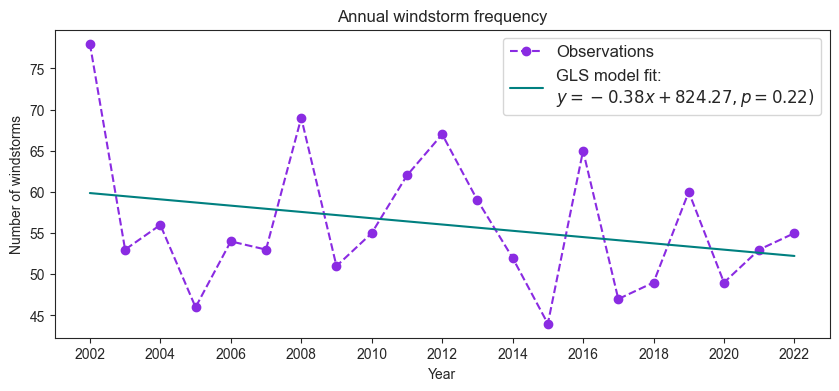

In [28]:
plt.figure(figsize=(10,4))
sns.set_style("ticks")
plt.plot(years, windstorms_1min,'o--', color='blueviolet', label='Observations')

trendpoly = gls_params[1]*x+gls_params[0]

plt.plot(years, trendpoly, color='teal', label=f'GLS model fit: \n${gls_equation}, p={np.round(gls_result.pvalues[1],2)})$')
plt.xlabel("Year")
plt.ylabel("Number of windstorms")
plt.xticks(years[::2])
plt.legend(loc="best",prop={'size': 12}) 
plt.title("Annual windstorm frequency")
# plt.savefig(f'{height}_windstorms.pdf')
plt.show()

In [29]:
from statsmodels.stats.diagnostic import het_white

# perform White's test
white_test = het_white(result.resid,  result.model.exog)

# define labels to use for output of White's test
labels = ['Test Statistic', 'Test Statistic p-value', 'F-Statistic', 'F-Test p-value']

# print results of White's test
print(dict(zip(labels, white_test)))

{'Test Statistic': 3.788242532513109, 'Test Statistic p-value': 0.1504504828925465, 'F-Statistic': 1.9922708026919167, 'F-Test p-value': 0.16881317282276537}


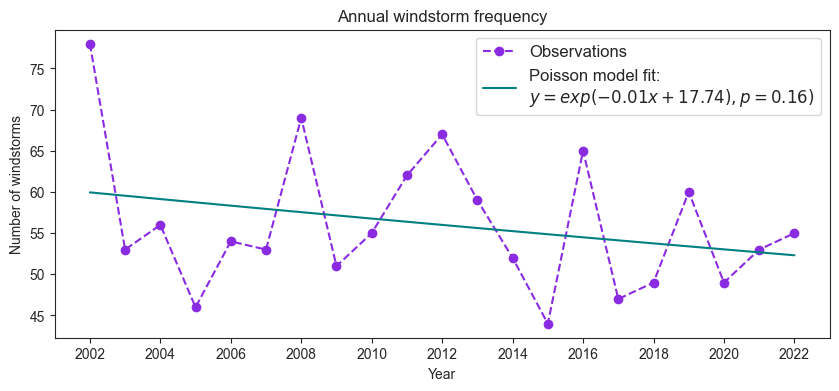

In [30]:
plt.figure(figsize=(10,4))
plt.plot(years, windstorms_1min,'o--', color='blueviolet', label='Observations')

trendpoly = np.exp(poisson_params[1]*x+poisson_params[0])

plt.plot(years, trendpoly, color='teal', label=f'Poisson model fit: \n${poisson_equation}, p={np.round(pois_result.pvalues[1],2)})$')
plt.xlabel("Year")
plt.ylabel("Number of windstorms")
plt.xticks(years[::2])
plt.legend(loc="best",prop={'size': 12}) 
plt.title(f"Annual windstorm frequency")
# plt.savefig(f'MFA_figures/{height}_windstorms.pdf')
plt.show()

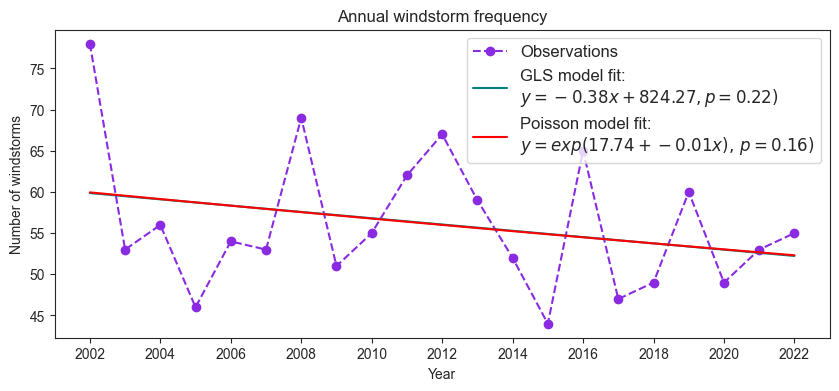

In [32]:
plt.figure(figsize=(10,4))
plt.plot(years, windstorms_1min,'o--', color='blueviolet', label='Observations')

trendpoly = gls_params[1]*x+gls_params[0]
trendpoly2 = np.exp(poisson_params[1]*x+poisson_params[0])

plt.plot(years, trendpoly, color='teal', label=f'GLS model fit: \n${gls_equation}, p={np.round(gls_result.pvalues[1],2)})$')
plt.plot(years, trendpoly2, color='red', label=f'Poisson model fit: \n$y=exp({np.round(poisson_params[0],2)} + {np.round(poisson_params[1],2)}x), \, p={np.round(pois_result.pvalues[1],2)})$')
plt.xlabel(f"Year")
plt.ylabel("Number of windstorms")
plt.xticks(years[::2])
plt.legend(loc="best",prop={'size': 12}) 
plt.title(f"Annual windstorm frequency")
# plt.savefig(f'windstorms_GLM_fits.pdf',bbox_inches='tight')
plt.show()

In [33]:
np.mean(windstorms_1min)

56.04761904761905

In [34]:
np.var(windstorms_1min)

67.28344671201813

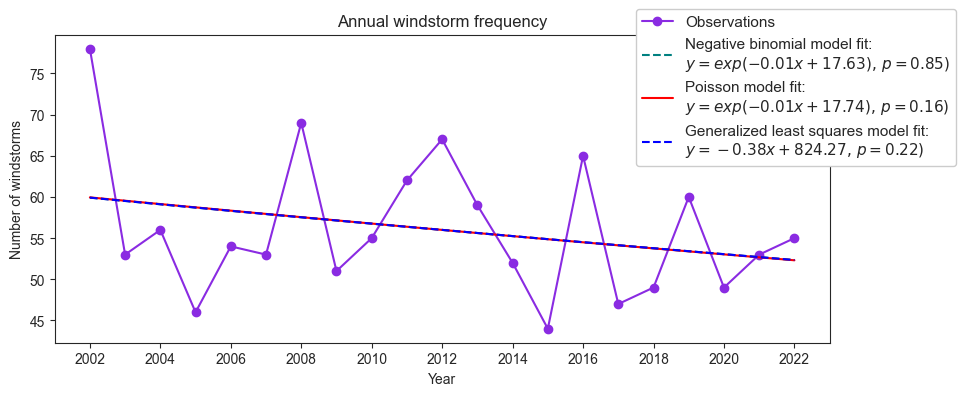

In [36]:
plt.figure(figsize=(10,4))
plt.plot(years, windstorms_1min,'o-', color='blueviolet', label='Observations')

trendpoly = np.exp(nb_params[1]*x+nb_params[0])
trendpoly2 = np.exp(poisson_params[1]*x+poisson_params[0])
trendpoly3 = gls_params[1]*x+gls_params[0]

plt.plot(years,trendpoly,'--',color='teal',label=f'Negative binomial model fit: \n$y = exp({np.round(nb_params[1],2)}x+{np.round(nb_params[0],2)}), \, p={np.round(nb_result.pvalues[1],2)})$')
plt.plot(years,trendpoly2,'-',color='red',label=f'Poisson model fit: \n$y=exp({np.round(poisson_params[1],2)}x+{np.round(poisson_params[0],2)}), \, p={np.round(pois_result.pvalues[1],2)})$')
plt.plot(years, trendpoly,'--', color='blue', label=f'Generalized least squares model fit: \n${gls_equation}, \, p={np.round(gls_result.pvalues[1],2)})$')
plt.xlabel(f"Year")
plt.ylabel("Number of windstorms")
plt.xticks(years[::2])
# plt.legend(loc="best",prop={'size': 12}) 
plt.legend(prop={'size': 11},loc=(.75, .575),fancybox=True, framealpha=1) 
plt.title(f"Annual windstorm frequency")
# plt.savefig(f'windstorms_fits.pdf',bbox_inches='tight')
plt.show()

#### Modeling with outlier removed

In [37]:
adj_windstorms_1min = np.delete(windstorms_1min, 0)
adj_windstorms_1min

array([53., 56., 46., 54., 53., 69., 51., 55., 62., 67., 59., 52., 44.,
       65., 47., 49., 60., 49., 53., 55.])

In [38]:
adj_years = np.delete(years, 0)
adj_years

array([2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
       2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022])

In [107]:
x = adj_years
y = adj_windstorms_1min

In [98]:
# Fit the Generalized Least Squares Regression model
adj_model = sm.GLS(y, sm.add_constant(x))
adj_gls_result = adj_model.fit()

# Extract the model parameters
adj_gls_params = adj_gls_result.params

# Print the model equation
adj_gls_equation = "y = {:.2f}x + {:.2f}".format(adj_gls_params[1], adj_gls_params[0])
print(adj_gls_equation)

# Print the summary of the model
print(adj_gls_result.summary())

y = -0.10x + 247.12
                            GLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.007
Model:                            GLS   Adj. R-squared:                 -0.048
Method:                 Least Squares   F-statistic:                    0.1212
Date:                Sat, 28 Oct 2023   Prob (F-statistic):              0.732
Time:                        09:58:06   Log-Likelihood:                -66.455
No. Observations:                  20   AIC:                             136.9
Df Residuals:                      18   BIC:                             138.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        247.1211    552.110

In [108]:
# Fit the Poisson Regression model
adj_model = sm.GLM(y, sm.add_constant(x), family=sm.families.Poisson())
adj_pois_result = adj_model.fit()

# Extract the model parameters
adj_pois_params = adj_pois_result.params

# Print the model equation
adj_pois_equation = "y = exp({:.2f}x + {:.2f})".format(adj_pois_params[1], adj_pois_params[0])
print(adj_pois_equation)

# Print the summary of the model
print(adj_pois_result.summary())

y = exp(-0.00x + 7.50)
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                   20
Model:                            GLM   Df Residuals:                       18
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -66.479
Date:                Sat, 28 Oct 2023   Deviance:                       16.157
Time:                        09:59:31   Pearson chi2:                     16.4
No. Iterations:                     3   Pseudo R-squ. (CS):           0.005502
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.5036     10.

In [109]:
np.var(adj_windstorms_1min)

45.3475

In [110]:
np.mean(adj_windstorms_1min)

54.95

In [111]:
adj_results.pearson_chi2 / adj_results.df_resid

0.9104626485690306

In [112]:
np.var(windstorms_1min)

67.28344671201813

In [113]:
np.mean(windstorms_1min)

56.04761904761905

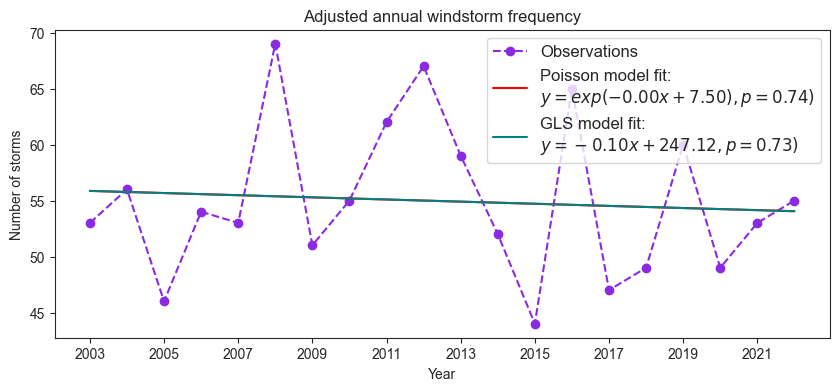

In [114]:
plt.figure(figsize=(10,4))
sns.set_style("ticks")
plt.plot(adj_years, adj_windstorms_1min,'o--', color='blueviolet', label='Observations')

trendpoly = np.exp(adj_pois_params[1]*adj_years+adj_pois_params[0])
trendpoly2 = adj_gls_params[1]*x+adj_gls_params[0]

plt.plot(adj_years,trendpoly, color='red',label=f'Poisson model fit: \n${adj_pois_equation}, p={np.round(adj_pois_result.pvalues[1],2)})$')
plt.plot(adj_years, trendpoly2, color='teal', label=f'GLS model fit: \n${adj_gls_equation}, p={np.round(adj_gls_result.pvalues[1],2)})$')
plt.xlabel(f"Year")
plt.xticks(adj_years[::2])
plt.ylabel("Number of storms")
plt.legend(loc="best",prop={'size': 12}) 
plt.title(f"Adjusted annual windstorm frequency")
# plt.savefig(f'MFA_figures/{height}_windstorms_pois2.pdf')
plt.show()

### Windstorm hours

In [129]:
x = years
y = windstorm_hours

# Fit the Ordinary Least Squares Regression model
model = sm.OLS(y, sm.add_constant(x))
ols_result = model.fit()

# Extract the model parameters
ols_params = ols_result.params

# Print the model equation
ols_equation = "y = {:.2f}x + {:.2f}".format(ols_params[1], ols_params[0])
print(ols_equation)

# Print the summary of the model
print(ols_result.summary())

y = -21.94x + 45951.58
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.155
Model:                            OLS   Adj. R-squared:                  0.111
Method:                 Least Squares   F-statistic:                     3.498
Date:                Sat, 28 Oct 2023   Prob (F-statistic):             0.0769
Time:                        10:10:46   Log-Likelihood:                -150.24
No. Observations:                  21   AIC:                             304.5
Df Residuals:                      19   BIC:                             306.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.595e+04   2.36e

In [130]:
# Fit the Generalized Least Squares Regression model
model = sm.GLS(y, sm.add_constant(x))
gls_result = model.fit()

# Extract the model parameters
gls_params = gls_result.params

# Print the model equation
gls_equation = "y = {:.2f}x + {:.2f}".format(gls_params[1], gls_params[0])
print(gls_equation)

# Print the summary of the model
print(gls_result.summary())

y = -21.94x + 45951.58
                            GLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.155
Model:                            GLS   Adj. R-squared:                  0.111
Method:                 Least Squares   F-statistic:                     3.498
Date:                Sat, 28 Oct 2023   Prob (F-statistic):             0.0769
Time:                        10:10:46   Log-Likelihood:                -150.24
No. Observations:                  21   AIC:                             304.5
Df Residuals:                      19   BIC:                             306.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.595e+04   2.36e

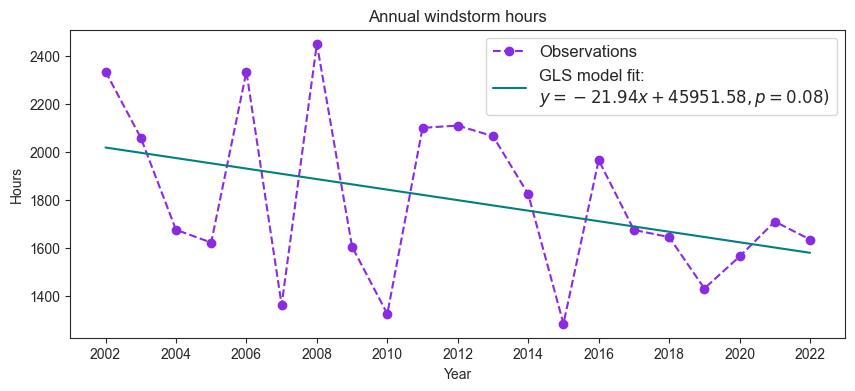

In [131]:
plt.figure(figsize=(10,4))
sns.set_style("ticks")
plt.plot(years, windstorm_hours,'o--', color='blueviolet', label='Observations')

trendpoly = gls_params[1]*x+gls_params[0]

plt.plot(years, trendpoly, color='teal', label=f'GLS model fit: \n${gls_equation}, p={np.round(gls_result.pvalues[1],2)})$')
plt.xlabel("Year")
# plt.ylabel("Hours (thousands)")
plt.ylabel("Hours")
plt.xticks(years[::2])
plt.legend(loc="best",prop={'size': 12}) 
plt.title("Annual windstorm hours")
# plt.savefig(f'{height}_windstorms.pdf')
plt.show()

### Windstorm properties (wind speed, windstorm duration, lulls)

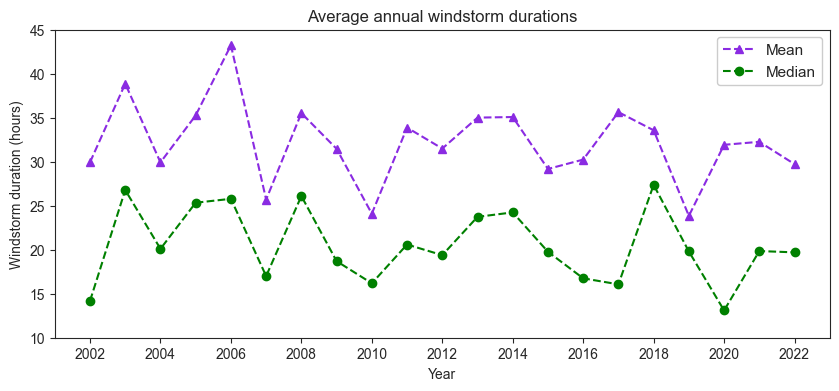

In [132]:
plt.figure(figsize=(10,4))

plt.plot(years, storm_durations_mean,'^--', color='blueviolet', label=f'Mean')
plt.plot(years, storm_durations_median,'o--', color='green', label=f'Median')

plt.xlabel(f"Year")
plt.ylabel("Windstorm duration (hours)")
plt.xticks(ticks=years[::2])
plt.yticks(ticks=plt.yticks()[0], labels=plt.yticks()[0].astype(int))
plt.legend(prop={'size': 11},loc='upper right',fancybox=True, framealpha=1) 
plt.title(f"Average annual windstorm durations")
# plt.savefig(f'MFA_figures/windstorm_durations.pdf',bbox_inches='tight')
plt.show()

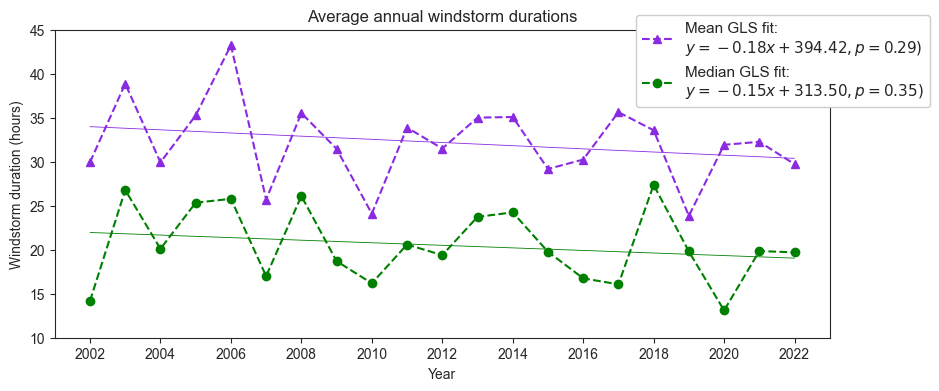

In [133]:
y = storm_durations_mean
x = years
mod = sm.GLS(y, sm.add_constant(x))
result = mod.fit()
equation1 = "y = {:.2f}x + {:.2f}".format(result.params[1], result.params[0])

y2 = storm_durations_median
mod2 = sm.GLS(y2, sm.add_constant(x))
result2 = mod2.fit()
equation2 = "y = {:.2f}x + {:.2f}".format(result2.params[1], result2.params[0])

plt.figure(figsize=(10,4))

trendpoly = result.params[1]*x+result.params[0]
trendpoly2 = result2.params[1]*x+result2.params[0]

plt.plot(years, storm_durations_mean,'^--', color='blueviolet', label=f'Mean GLS fit: \n${equation1}, p={np.round(result.pvalues[1],2)})$')
plt.plot(years, storm_durations_median,'o--', color='green', label=f'Median GLS fit: \n${equation2}, p={np.round(result2.pvalues[1],2)})$')

plt.plot(years,trendpoly, linewidth=0.6, color='blueviolet')
plt.plot(years,trendpoly2, linewidth=0.6, color='green')

plt.xlabel(f"Year")
plt.ylabel("Windstorm duration (hours)")
plt.xticks(ticks=years[::2])
plt.yticks(ticks=plt.yticks()[0], labels=plt.yticks()[0].astype(int))
plt.legend(prop={'size': 11},loc=(.75, .75),fancybox=True, framealpha=1) 
plt.title(f"Average annual windstorm durations")
# plt.savefig(f'windstorm_durations.pdf',bbox_inches='tight')
plt.show()

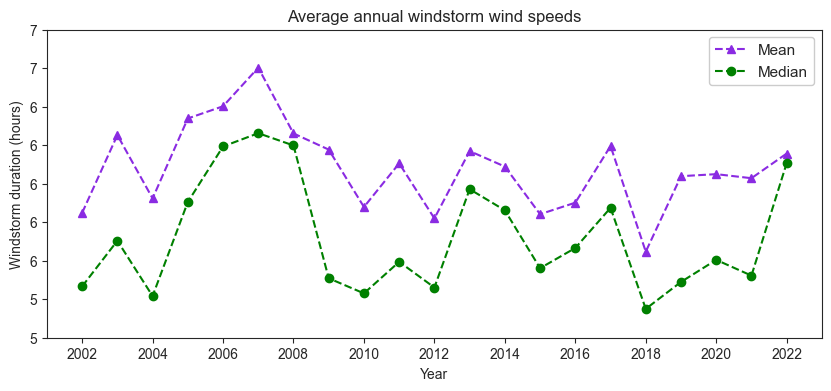

In [134]:
plt.figure(figsize=(10,4))

plt.plot(years, storm_speeds_mean,'^--', color='blueviolet', label=f'Mean')
plt.plot(years, storm_speeds_median,'o--', color='green', label=f'Median')

plt.xlabel(f"Year")
plt.ylabel("Windstorm duration (hours)")
plt.xticks(ticks=years[::2])
plt.yticks(ticks=plt.yticks()[0], labels=plt.yticks()[0].astype(int))
plt.legend(prop={'size': 11},loc='upper right',fancybox=True, framealpha=1) 
plt.title(f"Average annual windstorm wind speeds")
# plt.savefig(f'MFA_figures/windstorm_speeds.pdf',bbox_inches='tight')
plt.show()

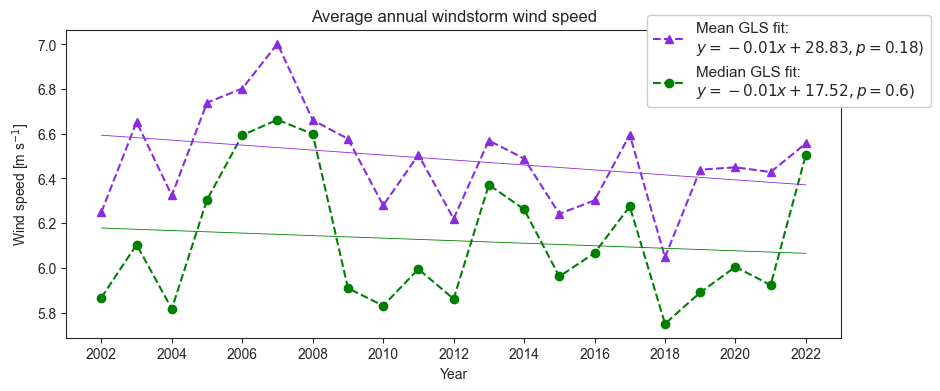

In [135]:
y = storm_speeds_mean
x = years
mod = sm.GLS(y, sm.add_constant(x))
result = mod.fit()
equation1 = "y = {:.2f}x + {:.2f}".format(result.params[1], result.params[0])

y2 = storm_speeds_median
mod2 = sm.GLS(y2, sm.add_constant(x))
result2 = mod2.fit()
equation2 = "y = {:.2f}x + {:.2f}".format(result2.params[1], result2.params[0])

plt.figure(figsize=(10,4))

trendpoly = result.params[1]*x+result.params[0]
trendpoly2 = result2.params[1]*x+result2.params[0]

plt.plot(years, storm_speeds_mean,'^--', color='blueviolet', label=f'Mean GLS fit: \n${equation1}, p={np.round(result.pvalues[1],2)})$')
plt.plot(years, storm_speeds_median,'o--', color='green', label=f'Median GLS fit: \n${equation2}, p={np.round(result2.pvalues[1],2)})$')

plt.plot(years,trendpoly, linewidth=0.6, color='blueviolet')
plt.plot(years,trendpoly2, linewidth=0.6, color='green')

plt.xlabel(f"Year")
plt.ylabel(r"Wind speed [m s$^{-1}$]")
plt.xticks(ticks=years[::2])
plt.legend(prop={'size': 11},loc=(.75, .75),fancybox=True, framealpha=1) 
plt.title(f"Average annual windstorm wind speed")
# plt.savefig(f'MFA_figures/windstorm_speeds.pdf',bbox_inches='tight')
plt.show()

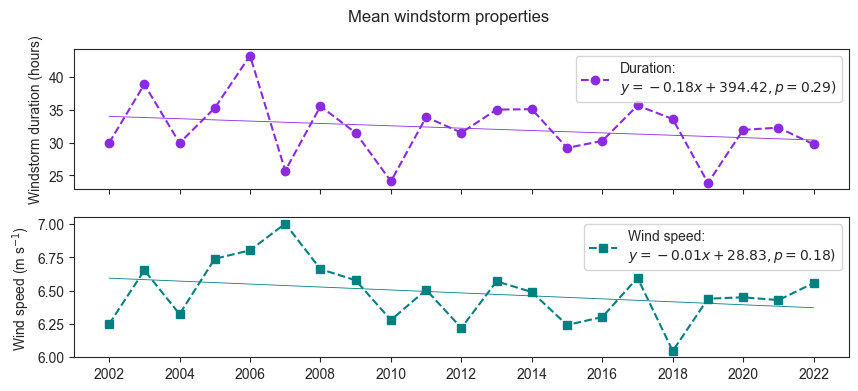

In [136]:
y = storm_durations_mean
x = years
mod = sm.GLS(y, sm.add_constant(x))
result = mod.fit()
equation1 = "y = {:.2f}x + {:.2f}".format(result.params[1], result.params[0])

y = storm_speeds_mean
mod = sm.GLS(y, sm.add_constant(x))
result2 = mod.fit()
equation2 = "y = {:.2f}x + {:.2f}".format(result2.params[1], result2.params[0])

trendpoly = result.params[1]*x+result.params[0]
trendpoly2 = result2.params[1]*x+result2.params[0]

fig, ax = plt.subplots(2, sharex=True, figsize=(10,4))

ax[0].plot(storm_durations_mean, 'o--', color='blueviolet', label=f'Duration:\n${equation1}, p={np.round(result.pvalues[1],2)})$')
ax[1].plot(storm_speeds_mean, 's--', color='teal', label=f'Wind speed:\n${equation2}, p={np.round(result2.pvalues[1],2)})$')
ax[0].plot(trendpoly, linewidth=0.6, color='blueviolet')
ax[1].plot(trendpoly2, linewidth=0.6, color='teal')

ax[0].set_xticks(ticks=np.arange(0,22,2),labels=years[::2])
ax[0].set_ylabel("Windstorm duration (hours)")
ax[0].tick_params(axis="y")
ax[0].legend(loc='upper right')

ax[1].set_ylabel(r"Wind speed (m s$^{-1}$)")
ax[1].tick_params(axis="y")
ax[1].legend(loc='upper right')

fig.suptitle("Mean windstorm properties")
# fig.savefig('windstorm_property_comparison.pdf')
plt.show()

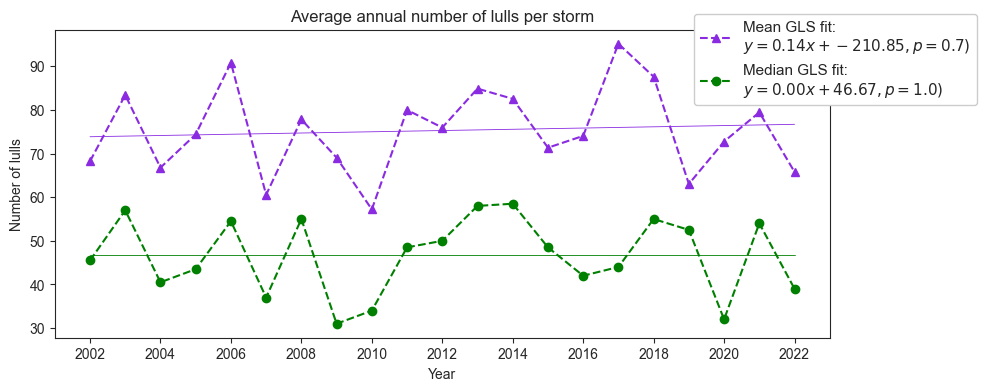

In [137]:
y = lulls_perstorm_mean
x = years
mod = sm.GLS(y, sm.add_constant(x))
result = mod.fit()
equation1 = "y = {:.2f}x + {:.2f}".format(result.params[1], result.params[0])

y2 = lulls_perstorm_median
mod2 = sm.GLS(y2, sm.add_constant(x))
result2 = mod2.fit()
equation2 = "y = {:.2f}x + {:.2f}".format(result2.params[1], result2.params[0])

plt.figure(figsize=(10,4))

trendpoly = result.params[1]*x+result.params[0]
trendpoly2 = result2.params[1]*x+result2.params[0]

plt.plot(years, lulls_perstorm_mean,'^--', color='blueviolet', label=f'Mean GLS fit: \n${equation1}, p={np.round(result.pvalues[1],2)})$')
plt.plot(years, lulls_perstorm_median,'o--', color='green', label=f'Median GLS fit: \n${equation2}, p={np.round(result2.pvalues[1],2)})$')

plt.plot(years,trendpoly, linewidth=0.6, color='blueviolet')
plt.plot(years,trendpoly2, linewidth=0.6, color='green')

plt.xlabel(f"Year")
plt.ylabel("Number of lulls")
plt.xticks(ticks=years[::2])
plt.legend(prop={'size': 11},loc=(.825, .755),fancybox=True, framealpha=1) 
plt.title(f"Average annual number of lulls per storm")
# plt.savefig(f'windstorm_lulls.pdf',bbox_inches='tight')
plt.show()

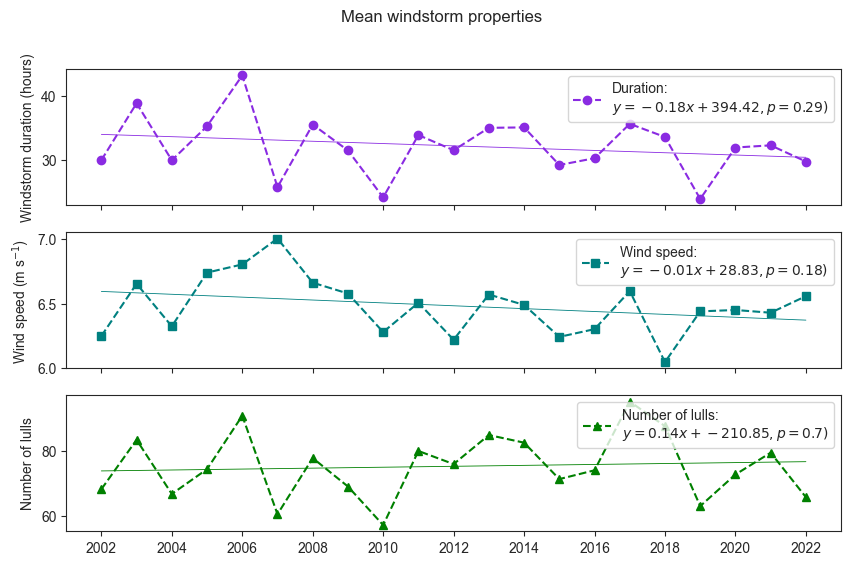

In [138]:
y = storm_durations_mean
x = years
mod = sm.GLS(y, sm.add_constant(x))
result = mod.fit()
equation1 = "y = {:.2f}x + {:.2f}".format(result.params[1], result.params[0])

y = storm_speeds_mean
mod = sm.GLS(y, sm.add_constant(x))
result2 = mod.fit()
equation2 = "y = {:.2f}x + {:.2f}".format(result2.params[1], result2.params[0])

y = lulls_perstorm_mean
mod = sm.GLS(y, sm.add_constant(x))
result3 = mod.fit()
equation3 = "y = {:.2f}x + {:.2f}".format(result3.params[1], result3.params[0])

trendpoly = result.params[1]*x+result.params[0]
trendpoly2 = result2.params[1]*x+result2.params[0]
trendpoly3 = result3.params[1]*x+result3.params[0]

fig, ax = plt.subplots(3, sharex=True, figsize=(10,6))

ax[0].plot(storm_durations_mean, 'o--', color='blueviolet', label=f'Duration:\n${equation1}, p={np.round(result.pvalues[1],2)})$')
ax[1].plot(storm_speeds_mean, 's--', color='teal', label=f'Wind speed:\n${equation2}, p={np.round(result2.pvalues[1],2)})$')
ax[2].plot(lulls_perstorm_mean, '^--', color='green', label=f'Number of lulls:\n${equation3}, p={np.round(result3.pvalues[1],2)})$')
ax[0].plot(trendpoly, linewidth=0.6, color='blueviolet')
ax[1].plot(trendpoly2, linewidth=0.6, color='teal')
ax[2].plot(trendpoly3, linewidth=0.6, color='green')

ax[0].set_xticks(ticks=np.arange(0,22,2),labels=years[::2])
ax[0].set_ylabel("Windstorm duration (hours)")
ax[0].tick_params(axis="y")
ax[0].legend(loc='upper right')

ax[1].set_ylabel(r"Wind speed (m s$^{-1}$)")
ax[1].tick_params(axis="y")
ax[1].legend(loc='upper right')

ax[2].set_ylabel("Number of lulls")
ax[2].tick_params(axis="y")
ax[2].legend(loc='upper right')

fig.suptitle("Mean windstorm properties")
# fig.savefig('windstorm_property_comparison.pdf')
plt.show()

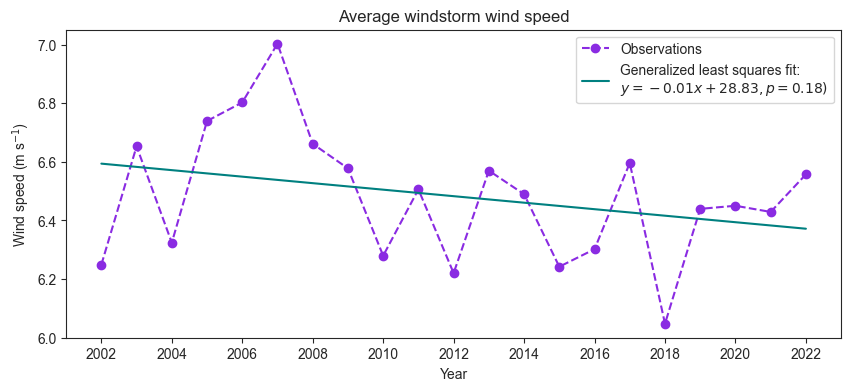

In [139]:
x = years
y = storm_speeds_mean

mod = sm.GLS(y, sm.add_constant(x))
result = mod.fit()
equation1 = "y = {:.2f}x + {:.2f}".format(result.params[1], result.params[0])

plt.figure(figsize=(10,4))
sns.set_style("ticks")
plt.plot(years, storm_speeds_mean,'o--', color='blueviolet', label='Observations')

trendpoly = result.params[1]*x+result.params[0]

plt.plot(years,trendpoly,'-',color='teal',label=f'Generalized least squares fit:\n${equation1}, p={np.round(result.pvalues[1],2)})$')
plt.xlabel("Year")
plt.ylabel(r"Wind speed (m s$^{-1}$)")
plt.xticks(years[::2])
plt.legend(loc="best",prop={'size': 10}) 
plt.title(f"Average windstorm wind speed")
# plt.savefig(f'wind_durations_new.pdf')
plt.show()

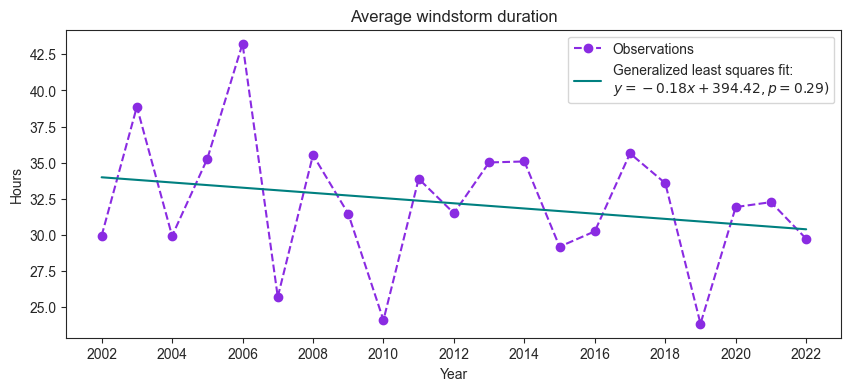

In [140]:
x = years
y = storm_durations_mean

mod = sm.GLS(y, sm.add_constant(x))
result = mod.fit()
equation1 = "y = {:.2f}x + {:.2f}".format(result.params[1], result.params[0])

plt.figure(figsize=(10,4))
sns.set_style("ticks")
plt.plot(years, storm_durations_mean,'o--', color='blueviolet', label='Observations')

trendpoly = result.params[1]*x+result.params[0]

plt.plot(years,trendpoly,'-',color='teal',label=f'Generalized least squares fit:\n${equation1}, p={np.round(result.pvalues[1],2)})$')
plt.xlabel(f"Year")
plt.ylabel("Hours")
plt.xticks(years[::2])
plt.legend(loc="best",prop={'size': 10}) 
plt.title(f"Average windstorm duration")
# plt.savefig(f'wind_durations_new.pdf')
plt.show()

# Diurnal analysis

In [141]:
hours = [(dtt.time(i).strftime('%H:%M')) for i in range(24)]
plot_hours = hours
plot_hours.append('24:00')

storm_times_daily = [item for sublist in storm_times for item in sublist]
storm_starttimes_daily = [item for sublist in storm_starttimes_mod1440 for item in sublist]
storm_stoptimes_daily = [item for sublist in storm_stoptimes_mod1440 for item in sublist]

In [142]:
d = dict(Time= storm_times_daily, StartTime= storm_starttimes_daily, EndTime= storm_stoptimes_daily) # pads start and end times with NANs to be the same size as the storm minutes
    
pd.DataFrame({k:pd.Series(v) for k,v in d.items()})

Time  StartTime  EndTime
0      1929      360.0    514.0
1      1930       28.0    810.0
2      1931      556.0    974.0
3      1932     1217.0   1004.0
4      1933      865.0    225.0
...     ...        ...      ...
98090  1242        NaN      NaN
98091  1243        NaN      NaN
98092  1244        NaN      NaN
98093  1245        NaN      NaN
98094  1246        NaN      NaN

[98095 rows x 3 columns]

In [143]:
d_d = {'Windstorm Start Times': storm_starttimes_daily,  'Windstorm End Times': storm_stoptimes_daily}
# d_d2 = {'Windstorm Start Times': np.concatenate(storm_starttimes_mod1440),  'Windstorm End Times': np.concatenate(storm_stoptimes_mod1440)}

df_diurnal = pd.DataFrame(data=d_d)
df_diurnal.to_csv(r'diurnal_windstorm_data_startend.csv', index=False)

df_diurnal

Windstorm Start Times  Windstorm End Times
0                       360                  514
1                        28                  810
2                       556                  974
3                      1217                 1004
4                       865                  225
...                     ...                  ...
1172                    925                  483
1173                    448                  981
1174                     17                   88
1175                    924                  773
1176                    341                  767

[1177 rows x 2 columns]

In [146]:
d_d = {'Windstorm Times': storm_times_daily}

df_diurnal2 = pd.DataFrame(data=d_d)
df_diurnal2.to_csv(r'diurnal_windstorm_data.csv', index=False)

# df_diurnal2

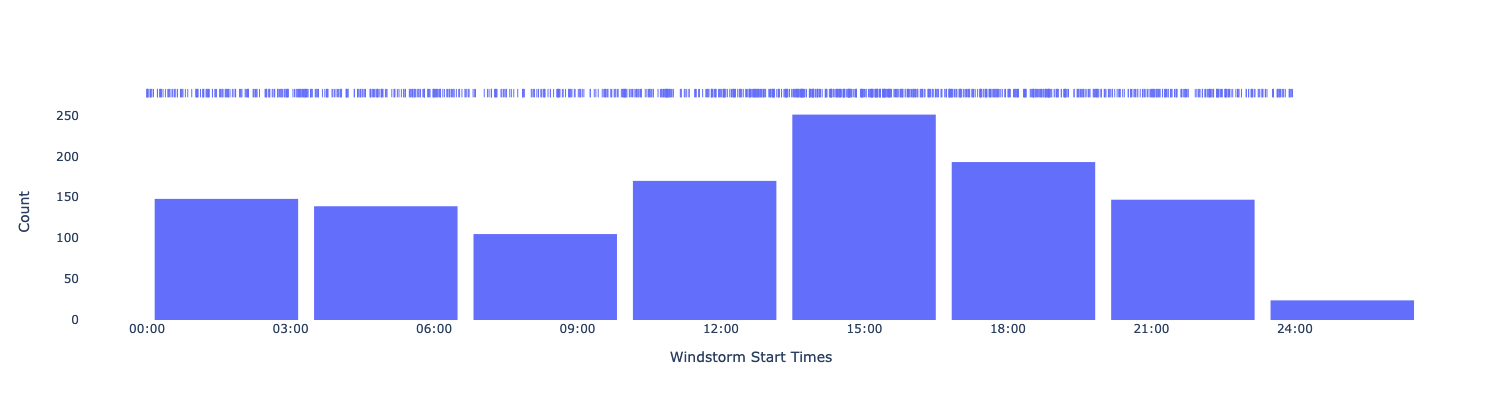

In [156]:
fig = px.histogram(df_diurnal, x="Windstorm Start Times", width=800, height=400, marginal="rug",nbins=12)
fig.update_layout(bargap=0.1, 
                    xaxis = dict(
                    tickmode = 'array',
                    tickvals = np.arange(0,1441,180),
                    ticktext = plot_hours[0::3]),
                plot_bgcolor="white",
                yaxis_title="Count")
fig.show()

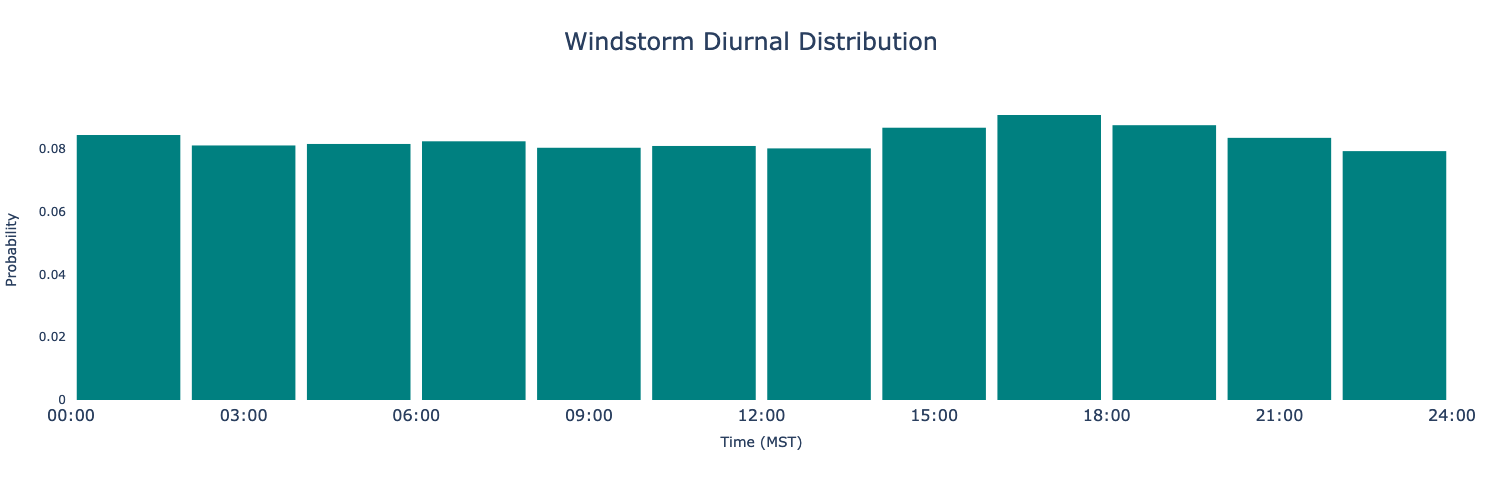

In [159]:
fig = go.Figure(data=[go.Histogram(x=df_diurnal2["Windstorm Times"], xbins=dict(
                      start=0,
                      end=2400,
                      size=200), marker = dict(color = 'teal'), autobinx=False, histnorm='probability')])


fig.update_layout(
    autosize=False,
    width=800,
    height=500,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4),
    plot_bgcolor="white",
    bargap=0.1, 
    xaxis = dict(
    tickmode = 'array',
    tickvals = np.arange(0,2401,300),
    ticktext = plot_hours[0::3],
    tickfont = dict(size=16),
    titlefont = dict(size = 20)),
    yaxis_title="Probability",
    xaxis_title="Time (MST)",
    title=dict(text="Windstorm Diurnal Distribution", font=dict(size=24)),
    title_x=0.5)

fig.show()
fig.write_image("windstorms_diurnal_overall.pdf")

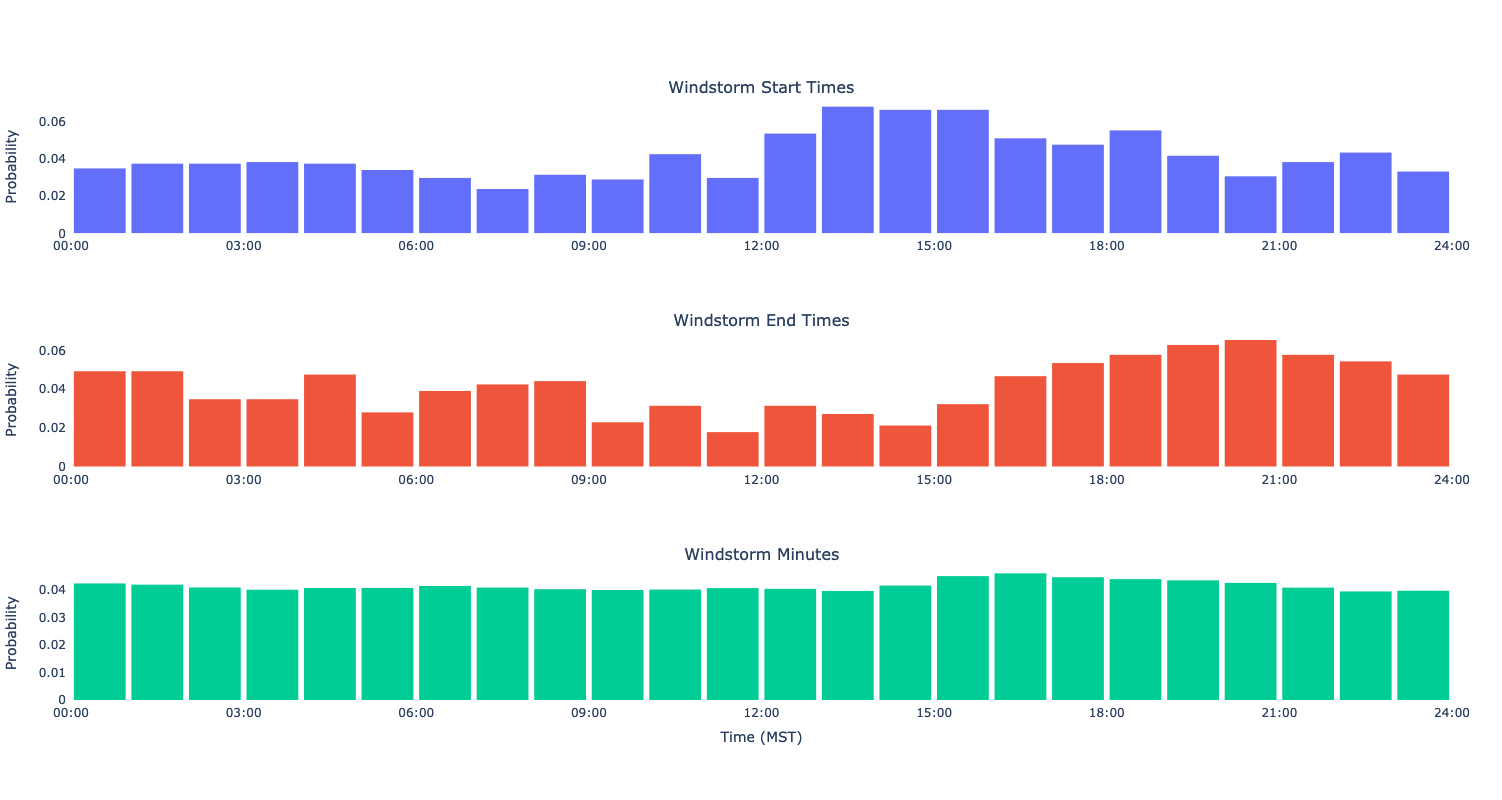

In [164]:
fig = make_subplots(rows=3, cols=1, subplot_titles=[
        'Windstorm Start Times', 
        'Windstorm End Times', 
        'Windstorm Minutes'
    ])

fig.update_layout(
    showlegend=False,
    autosize=False,
    width=800,
    height=800,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4),
    plot_bgcolor="white",
    bargap=0.1, 
    yaxis_title="Probability",
    yaxis2_title="Probability",
    yaxis3_title="Probability",
    xaxis3_title="Time (MST)",
    xaxis = dict(
        tickmode = 'array',
        tickvals = np.arange(0,1441,180),
        ticktext = plot_hours[0::3]),
    xaxis2 = dict(
        tickmode = 'array',
        tickvals = np.arange(0,1441,180),
        ticktext = plot_hours[0::3]),
    xaxis3 = dict(
        tickmode = 'array',
        tickvals = np.arange(0,2401,300),
        ticktext = plot_hours[0::3]))

trace0 = go.Histogram(x=df_diurnal["Windstorm Start Times"], xbins=dict(
                      start=0,
                      end=1440,
                      size=60), autobinx=False, histnorm='probability')
trace1 = go.Histogram(x=df_diurnal["Windstorm End Times"], xbins=dict(
                      start=0,
                      end=1440,
                      size=60), autobinx=False, histnorm='probability')
trace2 = go.Histogram(x=df_diurnal2["Windstorm Times"], xbins=dict(
                      start=0,
                      end=2400,
                      size=100), autobinx=False, histnorm='probability')

fig.append_trace(trace0, 1,1)
fig.append_trace(trace1, 2,1)
fig.append_trace(trace2, 3,1)

fig.show()
# fig.write_image("windstorms_diurnal_full.pdf")

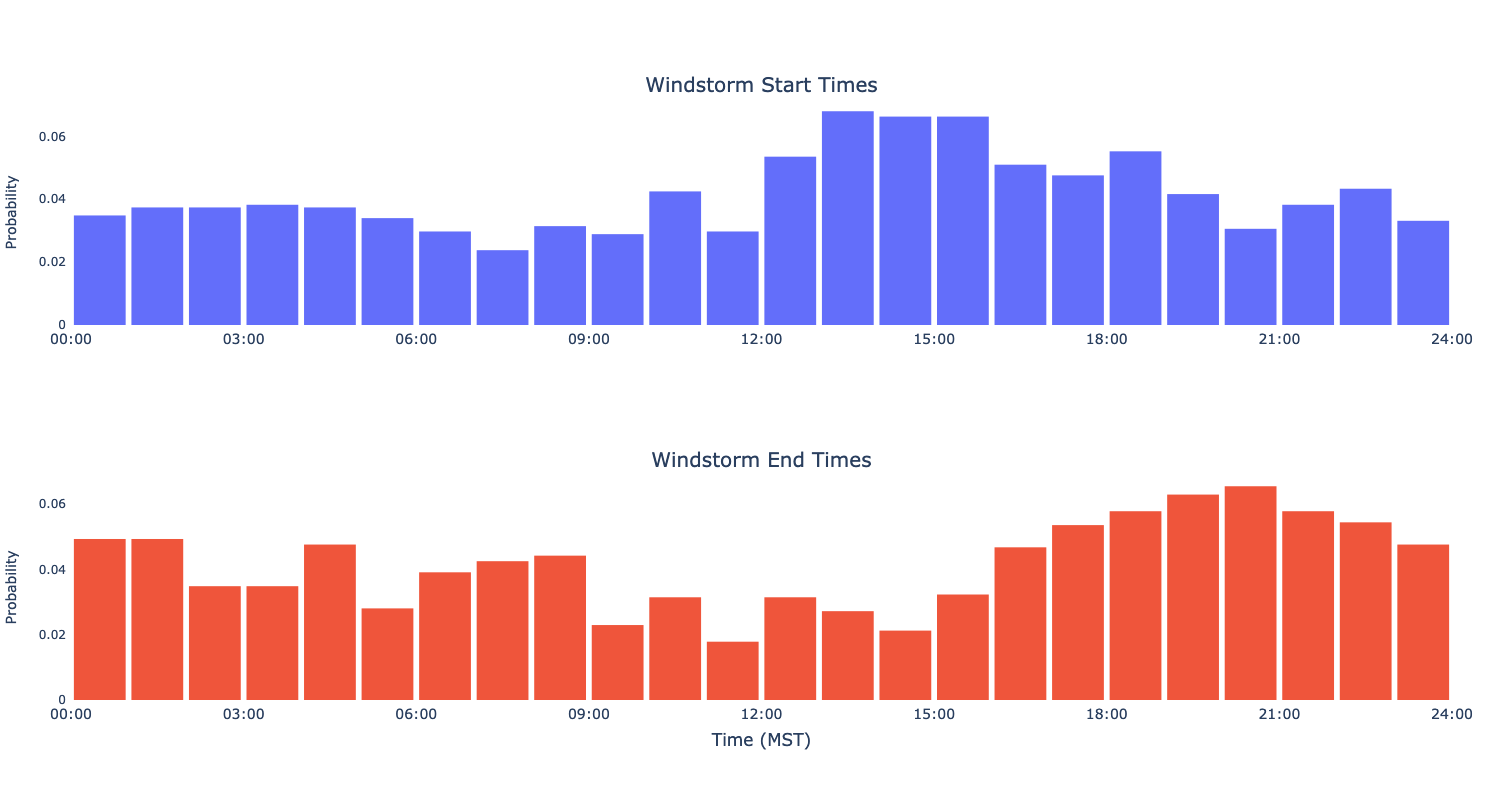

In [166]:
fig = make_subplots(rows=2, cols=1, subplot_titles=[
        'Windstorm Start Times', 
        'Windstorm End Times'
    ])

fig.update_annotations(font_size=20)

fig.update_layout(
    showlegend=False,
    autosize=False,
    width=800,
    height=800,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4),
    plot_bgcolor="white",
    bargap=0.1, 
    yaxis_title="Probability",
    yaxis2_title="Probability",
    xaxis2_title="Time (MST)", 
    xaxis = dict(
        tickmode = 'array',
        tickvals = np.arange(0,1441,180),
        ticktext = plot_hours[0::3],
        tickfont = dict(size=14)),
    xaxis2 = dict(
        tickmode = 'array',
        tickvals = np.arange(0,1441,180),
        ticktext = plot_hours[0::3],
        tickfont = dict(size=14),
        titlefont = dict(size = 17)))


trace0 = go.Histogram(x=df_diurnal["Windstorm Start Times"], xbins=dict(
                      start=0,
                      end=1440,
                      size=60), autobinx=False, histnorm='probability')
trace1 = go.Histogram(x=df_diurnal["Windstorm End Times"], xbins=dict(
                      start=0,
                      end=1440,
                      size=60), autobinx=False, histnorm='probability')

fig.append_trace(trace0, 1,1)
fig.append_trace(trace1, 2,1)

fig.show()
# fig.write_image("windstorms_diurnal.pdf")

In [167]:
from scipy.stats import chisquare

# Note for the future: would need to account for autocorrelation in the sample size value N
    
# observed frequencies
observed_frequencies = storm_times_daily

# number of observations
n = sum(observed_frequencies)
N = len(observed_frequencies)

# expected frequencies under the null hypothesis of a uniform distribution
expected_frequencies = [n/N for i in range(N)]

# compute the chi-squared statistic
chi_squared_statistic, p_value = chisquare(observed_frequencies, f_exp=expected_frequencies)

# if the p-value is less than the significance level (e.g. 0.05),
# we can reject the null hypothesis and conclude that the distribution is not uniform
if p_value < 0.05:
    print("The distribution is not uniform")
else:
    print("The distribution is uniform")

The distribution is not uniform


# Seasonal analysis

### Generate the data

In [168]:
months = np.arange(1,13)
month_names = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
season = ["Winter","Winter","Spring","Spring","Spring","Summer","Summer","Summer","Fall","Fall","Fall","Winter"]

In [169]:
yearly_data = [] # np.zeros(len(years))
height='10m'
# subset = ['Year', 'DOY', 'MST', f'Avg Wind Speed @ {height} [m/s]', f'Avg Wind Direction @ {height} [deg]', 'Temperature @ 2m [deg C]', 'Relative Humidity [%]']
subset = ['Year', 'DOY', 'MST', f'Avg Wind Speed @ {height} [m/s]', f'Avg Wind Direction @ {height} [deg]']

for i in np.arange(2002,2023,1): 
    year = i

    df = pd.read_csv(f'/Users/serena/Documents/Research/Data/{year}_data.csv', usecols=lambda x: x in subset)
    df.insert(2, 'Date (MM/DD/YYYY)', df['DOY'].apply(doy_to_date, args=(year,))) 
    df = df.replace(-99999.0, np.nan)
    df['Date (MM/DD/YYYY)'] = pd.to_datetime(df['Date (MM/DD/YYYY)'], format='%m/%d/%Y') # convert date column to DateTime
    df.set_index('Date (MM/DD/YYYY)')
    
    yearly_data.append(df)

    print(f'Finished {year}')

Finished 2002
Finished 2003
Finished 2004
Finished 2005
Finished 2006
Finished 2007
Finished 2008
Finished 2009
Finished 2010
Finished 2011
Finished 2012
Finished 2013
Finished 2014
Finished 2015
Finished 2016
Finished 2017
Finished 2018
Finished 2019
Finished 2020
Finished 2021
Finished 2022


In [170]:
# file with all data from all years
full_data = pd.concat(yearly_data)
full_data['Date (MM/DD/YYYY)'] = pd.to_datetime(full_data['Date (MM/DD/YYYY)'], format='%m/%d/%Y') # convert date column to DateTime
full_data.set_index('Date (MM/DD/YYYY)')
full_data

Year  DOY Date (MM/DD/YYYY)     MST  Avg Wind Speed @ 10m [m/s]  \
0       2002    1        2002-01-01     0.0                      2.7312   
1       2002    1        2002-01-01     1.0                      2.7907   
2       2002    1        2002-01-01     2.0                      3.5522   
3       2002    1        2002-01-01     3.0                      3.4231   
4       2002    1        2002-01-01     4.0                      3.5745   
...      ...  ...               ...     ...                         ...   
525595  2022  365        2022-12-31  2355.0                      6.1440   
525596  2022  365        2022-12-31  2356.0                      6.3160   
525597  2022  365        2022-12-31  2357.0                      6.1080   
525598  2022  365        2022-12-31  2358.0                      5.9460   
525599  2022  365        2022-12-31  2359.0                      5.9160   

        Avg Wind Direction @ 10m [deg]  
0                               30.179  
1                               23.560  
2                               19.807  
3                               18.708  
4                               20.513  
...                                ...  
525595                         173.100  
525596                         172.200  
525597                         170.900  
525598                         173.100  
525599                         174.500  

[11044827 rows x 6 columns]

In [171]:
storms_with_lulls = [storm                                                       
                     for storm in                                                
                     WindstormWithLulls.storms_by_threshold(full_data, 4.5, 12*60, [240, 330])         
                     if storm.duration >= 60 and np.median(storm.speed) >= 4.5 and np.mean(storm.speed) >= 4.5]
print(f'Total windstorms between 2002-2022: {len(storms_with_lulls)}')

Total windstorms between 2002-2022: 1172


In [172]:
storm_durations_monthly = np.zeros(12)
storm_speeds_monthly = np.zeros(12)
windstorm_hours_monthly = np.zeros(12)

# group the data by month
sort = list(full_data.groupby(full_data['Date (MM/DD/YYYY)'].dt.month))

monthly_data = []
for i in range(len(sort)):
    monthly_data.append(sort[i][1])
    
monthly_storms = np.zeros(12)
for i in range(len(monthly_data)): 
    monthly_data[i] = monthly_data[i].reset_index()
    monthly_data[i] = monthly_data[i].rename(columns={'index': 'Overall index'})
    storms_with_lulls = [storm                                                       
                     for storm in                                                
                     WindstormWithLulls.storms_by_threshold(monthly_data[i], 4.5, 12*60, [240, 330])         
                     if storm.duration >= 60 and np.median(storm.speed) >= 4.5 and np.mean(storm.speed) >= 4.5]  
   
    storm_durations = [storm.duration for storm in storms_with_lulls]
    storm_speeds = [np.mean(storm.speed) for storm in storms_with_lulls]  
    monthly_storms[i] = len(storms_with_lulls) # cumulative
    storm_durations_monthly[i] = np.mean(storm_durations)/60
    storm_speeds_monthly[i] = np.mean(storm_speeds)
    windstorm_hours_monthly[i] = np.sum(storm_durations)
    
    print(f'Total windstorms in month {i+1}: {len(storms_with_lulls)}')

Total windstorms in month 1: 134
Total windstorms in month 2: 105
Total windstorms in month 3: 120
Total windstorms in month 4: 108
Total windstorms in month 5: 91
Total windstorms in month 6: 90
Total windstorms in month 7: 57
Total windstorms in month 8: 65
Total windstorms in month 9: 78
Total windstorms in month 10: 90
Total windstorms in month 11: 118
Total windstorms in month 12: 133


In [173]:
storm_speeds_monthly

array([7.18098955, 7.07338349, 6.47910222, 6.43109092, 6.09743824,
       5.78218114, 5.83844242, 5.58834759, 5.83983876, 6.53587033,
       6.72933887, 6.87212889])

In [174]:
storm_durations_monthly

array([48.6278607 , 43.54825397, 38.82833333, 30.04783951, 17.51153846,
       13.17425926, 10.2497076 , 11.22846154, 15.59166667, 32.44907407,
       38.45240113, 46.03233083])

In [175]:
windstorm_hours_monthly/1000 # in thousands

array([390.968, 274.354, 279.564, 194.71 ,  95.613,  71.141,  35.054,
        43.791,  72.969, 175.225, 272.243, 367.338])

In [176]:
monthly_storms

array([134., 105., 120., 108.,  91.,  90.,  57.,  65.,  78.,  90., 118.,
       133.])

### Computing variance for error bars for monthly storms

In [177]:
monthly_data[0] # e.g. January data

Overall index  Year  DOY Date (MM/DD/YYYY)     MST  \
0                   0  2002    1        2002-01-01     0.0   
1                   1  2002    1        2002-01-01     1.0   
2                   2  2002    1        2002-01-01     2.0   
3                   3  2002    1        2002-01-01     3.0   
4                   4  2002    1        2002-01-01     4.0   
...               ...   ...  ...               ...     ...   
937437          44635  2022   31        2022-01-31  2355.0   
937438          44636  2022   31        2022-01-31  2356.0   
937439          44637  2022   31        2022-01-31  2357.0   
937440          44638  2022   31        2022-01-31  2358.0   
937441          44639  2022   31        2022-01-31  2359.0   

        Avg Wind Speed @ 10m [m/s]  Avg Wind Direction @ 10m [deg]  
0                           2.7312                          30.179  
1                           2.7907                          23.560  
2                           3.5522                          19.807  
3                           3.4231                          18.708  
4                           3.5745                          20.513  
...                            ...                             ...  
937437                      5.8480                         180.400  
937438                      5.1610                         177.700  
937439                      5.4040                         177.800  
937440                      5.0050                         173.800  
937441                      4.8690                         171.700  

[937442 rows x 7 columns]

In [181]:
storms_by_month = []
speeds_by_month = []
durations_by_month = []
windstorm_hours_by_month = []
for month in months:
    
    storms_one_month = []
    speeds_one_month = []
    durations_one_month = []
    windstorm_hours_one_month = []

    
    for year in years: 
        df = monthly_data[month-1] # contains 21 years of data from one month
        df_one_year = df[df.Year == year]
        
        storms_with_lulls = [storm                                                       
                         for storm in                                                
                         WindstormWithLulls.storms_by_threshold(df_one_year, 4.5, 12*60, [240, 330])         
                         if storm.duration >= 60 and np.median(storm.speed) >= 4.5 and np.mean(storm.speed) >= 4.5] 
        
        storms_one_month.append(len(storms_with_lulls))
        
        storm_speeds = [np.mean(storm.speed) for storm in storms_with_lulls] 
        storm_durations = [storm.duration for storm in storms_with_lulls]
        
        speeds_one_month.append(np.mean(storm_speeds))
        durations_one_month.append(np.mean(storm_durations)/60)
        windstorm_hours_one_month.append(np.sum(storm_durations)/60)
        
    storms_by_month.append(storms_one_month)
    speeds_by_month.append(speeds_one_month)
    durations_by_month.append(durations_one_month)
    windstorm_hours_by_month.append(windstorm_hours_one_month)

    print(f'Month {month} finished!')    

Month 1 finished!
Month 2 finished!
Month 3 finished!


/Users/serena/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning:

Mean of empty slice.

/Users/serena/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning:

invalid value encountered in double_scalars



Month 4 finished!
Month 5 finished!
Month 6 finished!
Month 7 finished!
Month 8 finished!
Month 9 finished!
Month 10 finished!
Month 11 finished!
Month 12 finished!


In [182]:
print(np.shape(storms_by_month))
print(np.shape(windstorm_hours_by_month))
print(np.shape(speeds_by_month))
print(np.shape(durations_by_month))

(12, 21)
(12, 21)
(12, 21)
(12, 21)


In [183]:
windstorm_hours_by_month[3] # sanity check: total hours in a month (max): 31*24 = 744

[215.03333333333333,
 65.93333333333334,
 103.56666666666666,
 131.85,
 227.51666666666668,
 115.86666666666666,
 281.6666666666667,
 31.35,
 181.25,
 376.3833333333333,
 156.2,
 235.45,
 174.88333333333333,
 54.78333333333333,
 139.06666666666666,
 50.38333333333333,
 183.48333333333332,
 131.2,
 97.81666666666666,
 0.0,
 284.23333333333335]

In [184]:
toth_by_month = []
for month in months:
    toth_one_month = []
    
    for year in years: 
        df = monthly_data[month-1] # contains 21 years of data from one month
        df_one_year = df[df.Year == year]
        
        toth = count_over_thresholds(df_one_year['Avg Wind Speed @ 10m [m/s]'], 4.5, df_one_year['Avg Wind Direction @ 10m [deg]'], [240, 330])
        
        toth_one_month.append(toth/60)
  
    toth_by_month.append(toth_one_month)
    print(f'Month {month} finished!')  

Month 1 finished!
Month 2 finished!
Month 3 finished!
Month 4 finished!
Month 5 finished!
Month 6 finished!
Month 7 finished!
Month 8 finished!
Month 9 finished!
Month 10 finished!
Month 11 finished!
Month 12 finished!


In [186]:
toth_by_month[3] # sanity check: total hours in a month (max): 31*24 = 744

[152.56666666666666,
 87.08333333333333,
 76.95,
 75.61666666666666,
 151.2,
 86.23333333333333,
 137.91666666666666,
 84.25,
 125.35,
 222.85,
 116.66666666666667,
 131.25,
 149.08333333333334,
 47.31666666666667,
 117.61666666666666,
 91.56666666666666,
 117.9,
 92.05,
 132.96666666666667,
 55.96666666666667,
 166.71666666666667]

In [187]:
monthly_storms = np.zeros(12)
for i in range(12):
    monthly_storms[i]=np.sum(storms_by_month[i])
monthly_storms

array([135., 109., 124., 111.,  93.,  91.,  58.,  66.,  82.,  93., 122.,
       138.])

In [188]:
storm_speeds_monthly = np.zeros(12)
for i in range(12):
    storm_speeds_monthly[i]=np.nanmean(speeds_by_month[i])
storm_speeds_monthly

array([7.1876513 , 7.03856412, 6.52091651, 6.45772113, 6.08050561,
       5.85264672, 5.78961926, 5.54525386, 5.81606895, 6.50385249,
       6.73181422, 6.84272327])

In [189]:
storm_durations_monthly = np.zeros(12)
for i in range(12):
    storm_durations_monthly[i]=np.nanmean(durations_by_month[i])
storm_durations_monthly

array([48.95539494, 43.91574043, 36.27130574, 29.21560979, 16.22417328,
       13.49335421, 12.04994444, 13.91766818, 14.67965231, 33.09358655,
       39.48266156, 45.73027683])

In [190]:
monthly_storm_hours = np.zeros(12)
for i in range(12):
    monthly_storm_hours[i]=np.nansum(durations_by_month[i])
monthly_storm_hours

array([1028.06329365,  922.23054894,  761.69742063,  584.31219577,
        340.70763889,  283.36043831,  240.99888889,  292.27103175,
        308.27269841,  694.96531746,  829.13589286,  960.33581349])

In [191]:
toth_monthly = np.zeros(12)
for i in range(12):
    toth_monthly[i]=np.sum(toth_by_month[i])
toth_monthly

array([4426.28333333, 3229.85      , 3134.55      , 2419.11666667,
       1342.71666667, 1150.4       , 1039.15      , 1171.81666667,
       1341.88333333, 2442.46666667, 3337.33333333, 4068.5       ])

#### Quick Tangent -- Paired t-test: winter vs summer windstorms

In [197]:
winter_storms = []
winter_storms.append(storms_by_month[0])
winter_storms.append(storms_by_month[1])
winter_storms.append(storms_by_month[11])
winter_storms = np.ravel(winter_storms)
winter_storms

array([ 9,  5,  6,  6,  5,  5, 10,  6,  4,  6,  9,  4,  7,  6,  7,  4,  6,
        9,  7,  9,  5,  9,  2,  3,  4,  4,  7,  6,  6,  2,  8,  4,  6,  5,
        5,  8,  6,  5,  6,  7,  3,  3,  7,  5,  6,  5,  5,  9,  7,  6,  6,
        4,  9,  9,  4,  5,  8,  7,  6,  8,  4,  9,  9])

In [198]:
summer_storms = []
summer_storms.append(storms_by_month[5])
summer_storms.append(storms_by_month[6])
summer_storms.append(storms_by_month[7])
summer_storms = np.ravel(summer_storms)
summer_storms

array([ 6,  3,  2,  5,  1,  2,  5,  6,  1,  8, 11,  5,  7,  2,  4,  2,  4,
        3,  4,  6,  4,  4,  2,  3,  2,  5,  3,  3,  2,  4,  3,  3,  3,  1,
        4,  4,  4,  1,  3,  3,  0,  1,  7,  1,  1,  2,  1,  3,  7,  1,  4,
        5,  7,  2,  2,  4,  4,  3,  4,  3,  1,  2,  2])

In [199]:
np.mean(summer_storms)

3.4126984126984126

In [200]:
stats.ttest_rel(winter_storms, summer_storms)

TtestResult(statistic=9.52819037619457, pvalue=9.33297650405846e-14, df=62)

In [201]:
winter_speeds = []
winter_speeds.append(speeds_by_month[0])
winter_speeds.append(speeds_by_month[1])
winter_speeds.append(speeds_by_month[11])
winter_speeds = np.ravel(winter_speeds)
winter_speeds = np.delete(winter_speeds, 40, None)
winter_speeds

array([6.13937385, 6.84592357, 7.49335165, 7.40390602, 7.74472064,
       8.13116944, 7.18180066, 8.5015174 , 6.4167647 , 7.49096657,
       7.89845154, 8.61165965, 7.69763758, 6.57189149, 6.45769277,
       6.44912828, 5.81507144, 7.04364341, 7.24419511, 7.88328068,
       5.91853081, 7.43406975, 8.95160809, 5.03426132, 6.58003807,
       6.60152225, 7.21420034, 7.29028026, 7.78747864, 7.86574228,
       7.04875886, 7.4010214 , 6.1218508 , 6.89166126, 6.3579147 ,
       6.73253032, 7.09567719, 6.69720689, 8.27636604, 7.19334267,
       7.01640642, 6.02878887, 7.03816247, 6.55459982, 7.71611573,
       6.84638082, 7.35340098, 8.62285856, 6.58052987, 7.56412808,
       6.38771415, 6.12440126, 7.55349294, 6.01867801, 6.14822631,
       6.88695728, 6.54264469, 6.32601311, 6.07711519, 6.31451869,
       7.02380097, 7.98866083])

In [202]:
summer_speeds = []
summer_speeds.append(speeds_by_month[5])
summer_speeds.append(speeds_by_month[6])
summer_speeds.append(speeds_by_month[7])
summer_speeds = np.ravel(summer_speeds)
summer_speeds = np.delete(summer_speeds, 40, None)
summer_speeds

array([5.90371454, 5.87605779, 5.55425747, 5.78433387, 5.71619981,
       8.41785911, 5.55001845, 5.54555296, 4.61569359, 5.07165975,
       5.91592976, 5.80930986, 5.70209477, 5.597705  , 5.10136373,
       5.69292983, 5.77688612, 5.4592759 , 7.0395513 , 6.0016093 ,
       6.77357814, 4.94810988, 5.44412275, 5.21456189, 7.34260176,
       5.70402419, 5.95200842, 6.1125463 , 4.83242226, 5.27799232,
       5.7871705 , 5.55508119, 6.66796714, 4.94305625, 6.00617975,
       5.9565797 , 6.35500509, 5.76046974, 6.09637198, 6.64232373,
       5.19379032, 6.35987892, 5.72237924, 5.06688693, 5.44093771,
       5.20436486, 6.12933968, 5.5283329 , 5.31800248, 5.45464   ,
       5.5422877 , 5.52778762, 5.41572686, 5.85490868, 5.92941231,
       5.47239768, 5.68981849, 5.34949   , 5.27316881, 6.48544676,
       4.82839477, 4.85672865])

In [203]:
np.std(summer_speeds)

0.634645501945112

In [204]:
stats.ttest_rel(winter_speeds, summer_speeds)

TtestResult(statistic=10.079006014140287, pvalue=1.3184565489601594e-14, df=61)

In [205]:
winter_durations = []
winter_durations.append(durations_by_month[0])
winter_durations.append(durations_by_month[1])
winter_durations.append(durations_by_month[11])
winter_durations = np.ravel(winter_durations)
winter_durations = np.delete(winter_durations, 40, None)
winter_durations

array([ 32.51666667,  79.45666667,  38.94722222,  30.56666667,
       113.58333333,  34.54333333,  46.825     ,  73.85833333,
        29.775     ,  77.        ,  53.1       ,  34.40416667,
        67.61666667,  42.05555556,  28.88571429,  64.70833333,
        55.67777778,  25.45740741,  41.82619048,  22.82592593,
        34.43333333,  26.39259259,  37.90833333,   4.18333333,
        32.12916667,  81.24583333,  40.73095238,  46.93888889,
        43.98888889,  20.375     ,  29.4875    ,  49.66666667,
        49.00833333,  58.12333333,  40.65      ,  51.58958333,
        41.04166667,  44.73      ,  16.78888889,  28.74047619,
        67.05555556,  59.51428571,  52.80333333,  48.43888889,
        94.58333333,  58.16333333,  36.76666667,  50.55714286,
        28.67222222,  34.90833333,  43.05416667,  24.88888889,
        40.88888889,  16.325     ,  61.08333333,  39.69375   ,
        39.49285714,  45.13888889,  30.19166667,  67.55416667,
        45.48333333,  42.13333333])

In [206]:
summer_durations = []
summer_durations.append(durations_by_month[5])
summer_durations.append(durations_by_month[6])
summer_durations.append(durations_by_month[7])
summer_durations = np.ravel(summer_durations)
summer_durations = np.delete(summer_durations, 40, None)
summer_durations

array([ 6.46666667,  3.34444444, 44.03333333, 16.03333333, 12.18333333,
       20.10833333, 33.37666667,  7.35      ,  1.3       ,  9.89791667,
       16.33787879, 10.07      ,  9.84047619,  3.8       , 10.8       ,
       16.775     , 10.55833333, 26.03888889,  8.10833333, 11.19166667,
        5.74583333, 19.35      , 29.41666667, 17.17777778, 10.825     ,
       11.09333333,  5.18333333,  4.87777778, 17.        ,  6.75416667,
        6.68888889, 10.00555556,  6.02777778, 63.01666667,  4.78333333,
        6.23333333,  5.65416667,  5.06666667,  7.21666667,  2.56111111,
        2.06666667,  7.9047619 , 52.51666667, 13.75      , 10.78333333,
       16.45      ,  4.06666667,  7.06904762,  2.01666667, 11.06666667,
       10.65      , 11.76666667,  4.83333333, 11.075     ,  7.9       ,
       15.05833333,  2.98333333, 12.11666667,  6.43888889, 34.43333333,
        6.3       , 43.09166667])

In [207]:
np.mean(summer_durations)

13.171457402364657

In [208]:
stats.ttest_rel(winter_durations, summer_durations)

TtestResult(statistic=11.270408074941503, pvalue=1.508679643033551e-16, df=61)

In [209]:
winter_toth = []
winter_toth.append(toth_by_month[0])
winter_toth.append(toth_by_month[1])
winter_toth.append(toth_by_month[11])
winter_toth = np.ravel(winter_toth)
winter_toth

array([174.13333333, 233.73333333, 203.75      , 147.96666667,
       367.41666667, 116.65      , 281.58333333, 317.53333333,
       104.58333333, 318.81666667, 294.2       , 163.01666667,
       316.46666667, 151.13333333, 172.53333333, 155.03333333,
       173.03333333, 161.8       , 253.45      , 165.63333333,
       153.81666667, 151.25      ,  85.78333333,  63.08333333,
        91.9       , 247.78333333, 179.85      , 206.21666667,
       225.6       ,  79.33333333, 154.91666667, 135.66666667,
       170.98333333, 173.55      , 162.65      , 237.85      ,
       135.15      , 127.5       , 110.26666667, 149.28333333,
       185.63333333, 155.6       , 221.45      , 204.56666667,
       238.01666667, 315.95      , 188.16666667, 198.71666667,
       275.8       , 168.81666667, 128.01666667,  97.43333333,
       164.18333333, 249.58333333, 102.65      , 188.88333333,
       186.38333333, 153.63333333, 166.33333333, 170.51666667,
       176.9       , 209.75      , 262.75      ])

In [210]:
summer_toth = []
summer_toth.append(toth_by_month[5])
summer_toth.append(toth_by_month[6])
summer_toth.append(toth_by_month[7])
summer_toth = np.ravel(summer_toth)
summer_toth

array([ 48.28333333,  23.5       ,  54.58333333,  74.98333333,
        72.86666667,  50.05      , 102.11666667,  35.33333333,
        24.43333333,  51.48333333,  75.06666667,  36.65      ,
        55.11666667,  20.68333333,  50.45      ,  49.61666667,
        55.61666667,  64.63333333,  84.68333333,  60.13333333,
        60.11666667,  43.18333333,  59.81666667,  49.98333333,
        60.45      ,  50.56666667,  44.8       ,  66.38333333,
        24.66666667,  51.78333333,  48.31666667,  74.3       ,
        54.41666667,  42.86666667,  62.4       ,  57.23333333,
        32.81666667,  21.36666667,  40.1       ,  52.81666667,
        36.71666667,  64.16666667,  71.25      ,  58.3       ,
        44.7       ,  69.13333333,  50.25      ,  53.8       ,
        47.31666667,  27.45      ,  64.16666667,  78.23333333,
        93.98333333,  49.05      ,  50.06666667,  65.11666667,
        47.46666667,  30.43333333,  54.05      ,  50.96666667,
        54.36666667,  48.56666667,  63.15      ])

In [211]:
np.std(winter_toth)

64.87353025628829

In [212]:
stats.ttest_rel(winter_toth, summer_toth)

TtestResult(statistic=16.400741734133387, pvalue=3.144810890563471e-24, df=62)

#### Bootstrapping for monthly standard errors: windstorm frequency

In [214]:
for i in range(12):
    print(shapiro(storms_by_month[i]))
# ----> Since at least 2 fail the S-W test, we can't assume monthly windstorms are normally distributed. Thus will use bootstrapping to construct a standard error value for errorbars.

ShapiroResult(statistic=0.9017806053161621, pvalue=0.03789261728525162)
ShapiroResult(statistic=0.9609250426292419, pvalue=0.5349546670913696)
ShapiroResult(statistic=0.8734889030456543, pvalue=0.011085687205195427)
ShapiroResult(statistic=0.9453176856040955, pvalue=0.27703648805618286)
ShapiroResult(statistic=0.9440444111824036, pvalue=0.2616714537143707)
ShapiroResult(statistic=0.9327433109283447, pvalue=0.15622296929359436)
ShapiroResult(statistic=0.9236847758293152, pvalue=0.10283660143613815)
ShapiroResult(statistic=0.8638839721679688, pvalue=0.007438485976308584)
ShapiroResult(statistic=0.937442421913147, pvalue=0.19388270378112793)
ShapiroResult(statistic=0.9666411280632019, pvalue=0.658170223236084)
ShapiroResult(statistic=0.9477846622467041, pvalue=0.30912235379219055)
ShapiroResult(statistic=0.896278440952301, pvalue=0.029655853286385536)


In [215]:
monthly_storm_CIs = []
for i in range(12):
    data = storms_by_month[i]
    monthly_storm_CIs.append(stats.t.interval(0.95, df=len(data)-1, loc=np.mean(data), scale=stats.sem(data)))

In [216]:
monthly_storm_CIs[0]

(5.594540880801237, 7.262601976341621)

In [217]:
np.sum(storms_by_month) #higher than total when not cutting off at each month, happens because many storms carry from one month to the next

1222

In [218]:
d_d_storms = {'Jan': storms_by_month[0], 'Feb': storms_by_month[1], 'Mar': storms_by_month[2], 'Apr': storms_by_month[3], 'May': storms_by_month[4], 'Jun': storms_by_month[5], 'Jul': storms_by_month[6], 'Aug': storms_by_month[7], 'Sep': storms_by_month[8], 'Oct': storms_by_month[9], 'Nov': storms_by_month[10], 'Dec': storms_by_month[11]}
# 'Year': np.arange(2002,2023), 
df_d_storms = pd.DataFrame(data=d_d_storms)
# df_d_storms.to_csv('full_monthly_windstorm_data.csv', index=False)

df_d_storms

Jan  Feb  Mar  Apr  May  Jun  Jul  Aug  Sep  Oct  Nov  Dec
0     9    9    9    8    4    6    4    7    5    5    5    7
1     5    2    7    5    7    3    2    1    7    5    4    5
2     6    3    7    5    6    2    3    1    7    5    5    6
3     6    4    4    7    3    5    2    2    2    3    5    5
4     5    4    7    5    6    1    5    1    5    4    9    5
5     5    7    4    8    4    2    3    3    2    3    6    9
6    10    6    7    8    8    5    3    7    3    2    6    7
7     6    6    5    4    4    6    2    1    5    4    4    6
8     4    2    4    6    8    1    4    4    6    5    8    6
9     6    8    9    9    2    8    3    5    2    6    4    4
10    9    4    4    4    4   11    3    7    5    3    8    9
11    4    6    5    5    4    5    3    2    5    8    7    9
12    7    5   10    4    2    7    1    2    3    5    3    4
13    6    5    5    4    1    2    4    4    2    1    8    5
14    7    8    7    5    4    4    4    4    4    7    5    8
15    4    6    5    2    4    2    4    3    1    7    6    7
16    6    5    5    5    3    4    1    4    2    3    5    6
17    9    6    4    8    2    3    3    3    4    4    7    8
18    7    7    6    3    6    4    3    1    4    3    6    4
19    9    3    4    0    6    6    0    2    4    6    5    9
20    5    3    6    6    5    4    1    2    4    4    6    9

In [219]:
df_d_storms.Jun.mean()

4.333333333333333

In [221]:
yearly_data_months = []
for i in range(len(years)):
    yearly_data_months.append(df_d_storms.iloc[i])
# yearly_data_months

In [222]:
yearly_data_months[18]

Jan    7
Feb    7
Mar    6
Apr    3
May    6
Jun    4
Jul    3
Aug    1
Sep    4
Oct    3
Nov    6
Dec    4
Name: 18, dtype: int64

In [223]:
d_d_storms2 = {'2002': yearly_data_months[0], '2003': yearly_data_months[1], '2004': yearly_data_months[2], '2005': yearly_data_months[3], '2006': yearly_data_months[4], '2007': yearly_data_months[5], '2008': yearly_data_months[6], '2009': yearly_data_months[7], '2010': yearly_data_months[8], '2011': yearly_data_months[9], '2012': yearly_data_months[10], '2013': yearly_data_months[11], '2014': yearly_data_months[12], '2015': yearly_data_months[13], '2016': yearly_data_months[14], '2017': yearly_data_months[15], '2018': yearly_data_months[16], '2019': yearly_data_months[17], '2020': yearly_data_months[18], '2021': yearly_data_months[19], '2022': yearly_data_months[20]}
    
    # 'Jan': storms_by_month[0], 'Feb': storms_by_month[1], 'Mar': storms_by_month[2], 'Apr': storms_by_month[3], 'May': storms_by_month[4], 'Jun': storms_by_month[5], 'Jul': storms_by_month[6], 'Aug': storms_by_month[7], 'Sep': storms_by_month[8], 'Oct': storms_by_month[9], 'Nov': storms_by_month[10], 'Dec': storms_by_month[11]}
df_d_storms2 = pd.DataFrame(data=d_d_storms2)

df_d_storms2

2002  2003  2004  2005  2006  2007  2008  2009  2010  2011  ...  2013  \
Jan     9     5     6     6     5     5    10     6     4     6  ...     4   
Feb     9     2     3     4     4     7     6     6     2     8  ...     6   
Mar     9     7     7     4     7     4     7     5     4     9  ...     5   
Apr     8     5     5     7     5     8     8     4     6     9  ...     5   
May     4     7     6     3     6     4     8     4     8     2  ...     4   
Jun     6     3     2     5     1     2     5     6     1     8  ...     5   
Jul     4     2     3     2     5     3     3     2     4     3  ...     3   
Aug     7     1     1     2     1     3     7     1     4     5  ...     2   
Sep     5     7     7     2     5     2     3     5     6     2  ...     5   
Oct     5     5     5     3     4     3     2     4     5     6  ...     8   
Nov     5     4     5     5     9     6     6     4     8     4  ...     7   
Dec     7     5     6     5     5     9     7     6     6     4  ...     9   

     2014  2015  2016  2017  2018  2019  2020  2021  2022  
Jan     7     6     7     4     6     9     7     9     5  
Feb     5     5     8     6     5     6     7     3     3  
Mar    10     5     7     5     5     4     6     4     6  
Apr     4     4     5     2     5     8     3     0     6  
May     2     1     4     4     3     2     6     6     5  
Jun     7     2     4     2     4     3     4     6     4  
Jul     1     4     4     4     1     3     3     0     1  
Aug     2     4     4     3     4     3     1     2     2  
Sep     3     2     4     1     2     4     4     4     4  
Oct     5     1     7     7     3     4     3     6     4  
Nov     3     8     5     6     5     7     6     5     6  
Dec     4     5     8     7     6     8     4     9     9  

[12 rows x 21 columns]

In [225]:
d_d_storms = {'Year': np.arange(2002,2023), 'January': storms_by_month[0], 'February': storms_by_month[1], 'March': storms_by_month[2], 'April': storms_by_month[3], 'May': storms_by_month[4], 'June': storms_by_month[5], 'July': storms_by_month[6], 'August': storms_by_month[7], 'September': storms_by_month[8], 'October': storms_by_month[9], 'November': storms_by_month[10], 'December': storms_by_month[11]}

df_d_storms = pd.DataFrame(data=d_d_storms)
# df_d_storms.to_csv('full_monthly_windstorm_data.csv', index=False)

df_d_storms

Year  January  February  March  April  May  June  July  August  September  \
0   2002        9         9      9      8    4     6     4       7          5   
1   2003        5         2      7      5    7     3     2       1          7   
2   2004        6         3      7      5    6     2     3       1          7   
3   2005        6         4      4      7    3     5     2       2          2   
4   2006        5         4      7      5    6     1     5       1          5   
5   2007        5         7      4      8    4     2     3       3          2   
6   2008       10         6      7      8    8     5     3       7          3   
7   2009        6         6      5      4    4     6     2       1          5   
8   2010        4         2      4      6    8     1     4       4          6   
9   2011        6         8      9      9    2     8     3       5          2   
10  2012        9         4      4      4    4    11     3       7          5   
11  2013        4         6      5      5    4     5     3       2          5   
12  2014        7         5     10      4    2     7     1       2          3   
13  2015        6         5      5      4    1     2     4       4          2   
14  2016        7         8      7      5    4     4     4       4          4   
15  2017        4         6      5      2    4     2     4       3          1   
16  2018        6         5      5      5    3     4     1       4          2   
17  2019        9         6      4      8    2     3     3       3          4   
18  2020        7         7      6      3    6     4     3       1          4   
19  2021        9         3      4      0    6     6     0       2          4   
20  2022        5         3      6      6    5     4     1       2          4   

    October  November  December  
0         5         5         7  
1         5         4         5  
2         5         5         6  
3         3         5         5  
4         4         9         5  
5         3         6         9  
6         2         6         7  
7         4         4         6  
8         5         8         6  
9         6         4         4  
10        3         8         9  
11        8         7         9  
12        5         3         4  
13        1         8         5  
14        7         5         8  
15        7         6         7  
16        3         5         6  
17        4         7         8  
18        3         6         4  
19        6         5         9  
20        4         6         9

In [253]:
monthly_std = []
for i in months:
    monthly_std.append(np.std(storms_by_month[i-1]))
monthly_std

[1.788093652906532,
 1.9424836242258228,
 1.7969487870584007,
 2.1633936555429614,
 1.9166296949998196,
 2.4168719124665756,
 1.2307474269828653,
 1.958758457257441,
 1.6591667990651757,
 1.7063307492541826,
 1.5312319229346216,
 1.7612611437054215]

In [254]:
bootstrap_CIs = []
for i in months:
    data = (storms_by_month[i-1],)
    res = stats.bootstrap(data, np.mean, confidence_level=0.95, method='BCa')
    bootstrap_CIs.append(res.confidence_interval)
bootstrap_CIs

bootstrap_stde = []
for i in months:
    data = (storms_by_month[i-1],)
    res = stats.bootstrap(data, np.mean, confidence_level=0.95, method='BCa')
    bootstrap_stde.append(res.standard_error)
bootstrap_stde

[0.38734913974638874,
 0.4217580329443564,
 0.39490478516492145,
 0.4676480310516555,
 0.41724007291862736,
 0.5308303580981601,
 0.26899345158900034,
 0.4228884436747323,
 0.36309654404183,
 0.3724772613463725,
 0.33591191749698807,
 0.38884476456398975]

In [255]:
CI_sizes = []
for i in range(12):
    CI_sizes.append(monthly_storm_CIs[i][1]-monthly_storm_CIs[i][0])
# CI_sizes

In [256]:
BS_CI_sizes = []
for i in range(12):
    BS_CI_sizes.append(bootstrap_CIs[i][1]-bootstrap_CIs[i][0])
# BS_CI_sizes

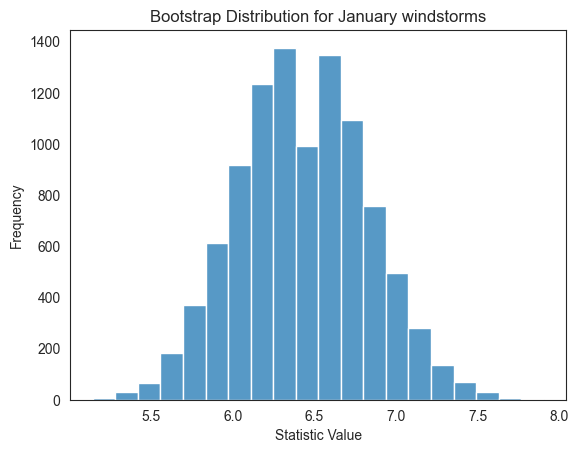

In [257]:
data = (storms_by_month[0],)
res = stats.bootstrap(data, np.mean, confidence_level=0.95, method='BCa')

fig, ax = plt.subplots()
sns.histplot(res.bootstrap_distribution, bins=20)
ax.set_title('Bootstrap Distribution for January windstorms')
ax.set_xlabel('Statistic Value')
ax.set_ylabel('Frequency')
plt.show()

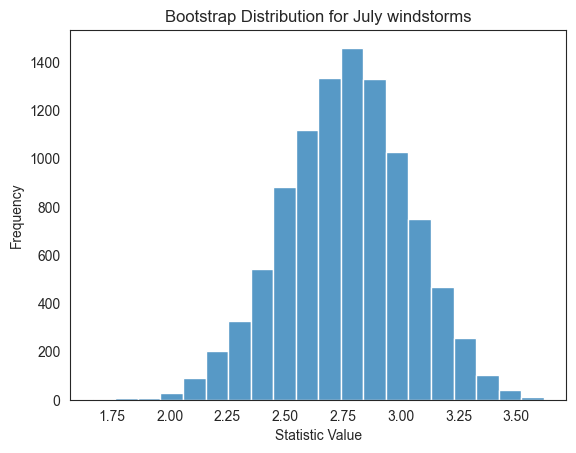

In [258]:
data = (storms_by_month[6],)
res = stats.bootstrap(data, np.mean, confidence_level=0.95, method='BCa')

fig, ax = plt.subplots()
sns.histplot(res.bootstrap_distribution, bins=20)
ax.set_title('Bootstrap Distribution for July windstorms')
ax.set_xlabel('Statistic Value')
ax.set_ylabel('Frequency')
plt.show()

#### Bootstrapping for monthly standard errors: windstorm durations

In [259]:
for i in range(12):
    print(shapiro(durations_by_month[i]))

ShapiroResult(statistic=0.8778965473175049, pvalue=0.013355066068470478)
ShapiroResult(statistic=0.9183775782585144, pvalue=0.08053644001483917)
ShapiroResult(statistic=0.9541618824005127, pvalue=0.40710628032684326)
ShapiroResult(statistic=nan, pvalue=1.0)
ShapiroResult(statistic=0.955665647983551, pvalue=0.4334641396999359)
ShapiroResult(statistic=0.8411723375320435, pvalue=0.003004159079864621)
ShapiroResult(statistic=nan, pvalue=1.0)
ShapiroResult(statistic=0.7208185195922852, pvalue=5.0613394705578685e-05)
ShapiroResult(statistic=0.9564699530601501, pvalue=0.4480668306350708)
ShapiroResult(statistic=0.9223839640617371, pvalue=0.09684798121452332)
ShapiroResult(statistic=0.9508805871009827, pvalue=0.3539152145385742)
ShapiroResult(statistic=0.940849781036377, pvalue=0.2264922559261322)


In [260]:
monthly_duration_CIs = []
for i in range(12):
    data = durations_by_month[i]
    monthly_duration_CIs.append(stats.t.interval(0.95, df=len(data)-1, loc=np.nanmean(data), scale=stats.sem(data,nan_policy='omit')))
# monthly_duration_CIs

In [261]:
monthly_dur_std = []
for i in months:
    monthly_dur_std.append(np.nanstd(durations_by_month[i-1]))
# monthly_dur_std

In [262]:
bootstrap_dur_CIs = []
for i in months:
    data = (durations_by_month[i-1],)
    res = stats.bootstrap(data, np.nanmean, confidence_level=0.95, method='BCa')
    bootstrap_dur_CIs.append(res.confidence_interval)
# bootstrap_dur_CIs

bootstrap_dur_stde = []
for i in months:
    data = (durations_by_month[i-1],)
    res = stats.bootstrap(data, np.nanmean, confidence_level=0.95, method='BCa')
    bootstrap_dur_stde.append(res.standard_error)
# bootstrap_dur_stde

#### Bootstrapping for monthly standard errors: windstorm wind speeds

In [263]:
for i in range(12):
    print(shapiro(speeds_by_month[i]))

ShapiroResult(statistic=0.9695168733596802, pvalue=0.7223137617111206)
ShapiroResult(statistic=0.9709401726722717, pvalue=0.7537691593170166)
ShapiroResult(statistic=0.9527158141136169, pvalue=0.38293230533599854)
ShapiroResult(statistic=nan, pvalue=1.0)
ShapiroResult(statistic=0.9229264259338379, pvalue=0.0993013083934784)
ShapiroResult(statistic=0.7993252873420715, pvalue=0.0006406736210919917)
ShapiroResult(statistic=nan, pvalue=1.0)
ShapiroResult(statistic=0.9569530487060547, pvalue=0.45700401067733765)
ShapiroResult(statistic=0.9101336598396301, pvalue=0.05524484068155289)
ShapiroResult(statistic=0.9718621969223022, pvalue=0.7738478779792786)
ShapiroResult(statistic=0.8938373327255249, pvalue=0.02662396803498268)
ShapiroResult(statistic=0.9151571393013, pvalue=0.06947596371173859)


In [264]:
monthly_speed_CIs = []
for i in range(12):
    data = speeds_by_month[i]
    monthly_speed_CIs.append(stats.t.interval(0.95, df=len(data)-1, loc=np.nanmean(data), scale=stats.sem(data,nan_policy='omit')))
# monthly_speed_CIs

In [265]:
monthly_spd_std = []
for i in months:
    monthly_spd_std.append(np.nanstd(speeds_by_month[i-1]))
# monthly_spd_std

In [266]:
bootstrap_spd_CIs = []
for i in months:
    data = (speeds_by_month[i-1],)
    res = stats.bootstrap(data, np.nanmean, confidence_level=0.95, method='BCa')
    bootstrap_spd_CIs.append(res.confidence_interval)
# bootstrap_spd_CIs

bootstrap_spd_stde = []
for i in months:
    data = (speeds_by_month[i-1],)
    res = stats.bootstrap(data, np.nanmean, confidence_level=0.95, method='BCa')
    bootstrap_spd_stde.append(res.standard_error)
# bootstrap_spd_stde

#### Bootstrapping for monthly standard errors: time over threshold

In [267]:
for i in range(12):
    print(shapiro(toth_by_month[i]))

ShapiroResult(statistic=0.8932899832725525, pvalue=0.025989895686507225)
ShapiroResult(statistic=0.9749589562416077, pvalue=0.8382530212402344)
ShapiroResult(statistic=0.9765365719795227, pvalue=0.8684002757072449)
ShapiroResult(statistic=0.9587199687957764, pvalue=0.4907248914241791)
ShapiroResult(statistic=0.9482731819152832, pvalue=0.3158504366874695)
ShapiroResult(statistic=0.9653589725494385, pvalue=0.6297638416290283)
ShapiroResult(statistic=0.981073796749115, pvalue=0.9398248791694641)
ShapiroResult(statistic=0.9498937129974365, pvalue=0.33907628059387207)
ShapiroResult(statistic=0.9802428483963013, pvalue=0.9287356734275818)
ShapiroResult(statistic=0.9095050096511841, pvalue=0.053689129650592804)
ShapiroResult(statistic=0.9523197412490845, pvalue=0.3765128552913666)
ShapiroResult(statistic=0.9758408665657043, pvalue=0.8553796410560608)


In [269]:
monthly_toth_CIs = []
for i in range(12):
    data = toth_by_month[i]
    monthly_toth_CIs.append(stats.t.interval(0.95, df=len(data)-1, loc=np.mean(data), scale=stats.sem(data)))
# monthly_toth_CIs

In [270]:
monthly_toth_std = []
for i in months:
    monthly_toth_std.append(np.std(toth_by_month[i-1]))
# monthly_toth_std

In [271]:
bootstrap_toth_CIs = []
for i in months:
    data = (toth_by_month[i-1],)
    res = stats.bootstrap(data, np.mean, confidence_level=0.95, method='BCa')
    bootstrap_toth_CIs.append(res.confidence_interval)
# bootstrap_toth_CIs

bootstrap_toth_stde = []
for i in months:
    data = (toth_by_month[i-1],)
    res = stats.bootstrap(data, np.mean, confidence_level=0.95, method='BCa')
    bootstrap_toth_stde.append(res.standard_error)
# bootstrap_toth_stde

#### Bootstrapping for monthly standard errors: windstorm hours

In [272]:
d_d_storm_hours = {'Year': np.arange(2002,2023), 'January': windstorm_hours_by_month[0], 'February': windstorm_hours_by_month[1], 'March': windstorm_hours_by_month[2], 'April': windstorm_hours_by_month[3], 'May': windstorm_hours_by_month[4], 'June': windstorm_hours_by_month[5], 'July': windstorm_hours_by_month[6], 'August': windstorm_hours_by_month[7], 'September': windstorm_hours_by_month[8], 'October': windstorm_hours_by_month[9], 'November': windstorm_hours_by_month[10], 'December': windstorm_hours_by_month[11]}

df_d_storm_hours = pd.DataFrame(data=d_d_storm_hours)
# df_d_storms.to_csv('full_monthly_windstorm_data.csv', index=False)

df_d_storm_hours

Year     January    February       March       April         May  \
0   2002  292.650000  237.533333  328.283333  215.033333   78.016667   
1   2003  397.283333   75.816667  409.866667   65.933333  117.600000   
2   2004  233.683333   12.550000  296.650000  103.566667  141.133333   
3   2005  183.400000  128.516667  123.850000  131.850000   46.366667   
4   2006  567.916667  324.983333  165.900000  227.516667  170.466667   
5   2007  172.716667  285.116667   84.316667  115.866667   25.666667   
6   2008  468.250000  281.633333  288.616667  281.666667  130.100000   
7   2009  443.150000  263.933333  288.333333   31.350000   89.866667   
8   2010  119.100000   40.750000   52.300000  181.250000  158.750000   
9   2011  462.000000  235.900000  325.016667  376.383333   37.066667   
10  2012  477.900000  198.666667  204.100000  156.200000  100.250000   
11  2013  137.616667  294.050000  250.250000  235.450000  146.033333   
12  2014  473.316667  290.616667  375.500000  174.883333   11.550000   
13  2015  252.333333  203.250000  164.383333   54.783333    9.533333   
14  2016  202.200000  412.716667  277.400000  139.066667   38.683333   
15  2017  258.833333  246.250000  287.333333   50.383333   40.800000   
16  2018  334.066667  223.650000  134.116667  183.483333   10.950000   
17  2019  229.116667  100.733333   83.283333  131.200000   37.083333   
18  2020  292.783333  201.183333  237.633333   97.816667   40.733333   
19  2021  205.433333  334.366667   97.166667    0.000000   57.466667   
20  2022  172.166667  201.166667  121.950000  284.233333   90.916667   

          June       July     August   September     October    November  \
0    38.800000  77.400000  55.333333  122.250000   71.450000  339.366667   
1    10.033333  58.833333  52.516667  104.350000  127.383333  340.416667   
2    88.066667  51.533333  13.750000  108.266667  151.766667  165.866667   
3    80.166667  21.650000  21.566667   54.900000   83.266667  307.166667   
4    12.183333  55.466667  16.450000  111.983333  168.533333  230.350000   
5    40.216667  15.550000  12.200000   27.166667  112.433333  144.533333   
6   166.883333  14.633333  49.483333   33.216667  118.700000  270.283333   
7    44.100000  34.000000   2.016667   74.516667  109.133333   43.633333   
8     1.300000  27.016667  44.266667   87.650000  228.166667  154.050000   
9    79.183333  20.066667  53.250000   27.733333   77.683333  243.866667   
10  179.716667  30.016667  82.366667   56.800000  209.883333  193.466667   
11   50.350000  18.083333   9.666667   70.000000  157.300000  241.533333   
12   68.883333  63.016667  22.150000   50.850000  123.133333  104.866667   
13    7.600000  19.133333  31.600000   10.966667   29.300000  208.600000   
14   43.200000  24.933333  60.233333   80.700000  153.933333  227.550000   
15   33.550000  22.616667   8.950000    6.183333  190.033333  266.333333   
16   42.233333   5.066667  48.466667   23.433333   85.333333  214.700000   
17   78.116667  21.650000  19.316667   87.250000  160.133333  241.283333   
18   32.433333   7.683333  34.433333   28.883333  128.466667  211.500000   
19   67.150000   0.000000  12.600000   36.066667  190.883333  299.066667   
20   22.983333   2.066667  86.183333   46.600000  145.850000   81.600000   

      December  
0   416.600000  
1   264.016667  
2   290.633333  
3   472.916667  
4   290.816667  
5   330.900000  
6   353.900000  
7   172.033333  
8   209.450000  
9   172.216667  
10  224.000000  
11  368.000000  
12   65.300000  
13  305.416667  
14  317.550000  
15  276.450000  
16  270.833333  
17  241.533333  
18  270.216667  
19  409.350000  
20  379.200000

In [273]:
for i in range(12):
    print(shapiro(windstorm_hours_by_month[i]))

ShapiroResult(statistic=0.9193423390388489, pvalue=0.08418899774551392)
ShapiroResult(statistic=0.9594101905822754, pvalue=0.5043231844902039)
ShapiroResult(statistic=0.9495481848716736, pvalue=0.3340053856372833)
ShapiroResult(statistic=0.9761765599250793, pvalue=0.8617191314697266)
ShapiroResult(statistic=0.9146900177001953, pvalue=0.06800626963376999)
ShapiroResult(statistic=0.8470579385757446, pvalue=0.0037814166862517595)
ShapiroResult(statistic=0.9049078822135925, pvalue=0.043608371168375015)
ShapiroResult(statistic=0.9217405915260315, pvalue=0.09401808679103851)
ShapiroResult(statistic=0.9507923722267151, pvalue=0.35256725549697876)
ShapiroResult(statistic=0.988079845905304, pvalue=0.9935760498046875)
ShapiroResult(statistic=0.9677011370658875, pvalue=0.6818070411682129)
ShapiroResult(statistic=0.9852591753005981, pvalue=0.9802325367927551)


In [275]:
monthly_windstorm_hours_CIs = []
for i in range(12):
    data = windstorm_hours_by_month[i]
    monthly_windstorm_hours_CIs.append(stats.t.interval(0.95, df=len(data)-1, loc=np.mean(data), scale=stats.sem(data)))
# monthly_windstorm_hours_CIs

In [276]:
monthly_storm_hours_std = []
for i in months:
    monthly_storm_hours_std.append(np.std(windstorm_hours_by_month[i-1]))
# monthly_storm_hours_std

In [277]:
bootstrap_windstorm_hours_CIs = []
for i in months:
    data = (windstorm_hours_by_month[i-1],)
    res = stats.bootstrap(data, np.mean, confidence_level=0.95, method='BCa')
    bootstrap_windstorm_hours_CIs.append(res.confidence_interval)

bootstrap_windstorm_hours_stde = []
for i in months:
    data = (windstorm_hours_by_month[i-1],)
    res = stats.bootstrap(data, np.mean, confidence_level=0.95, method='BCa')
    bootstrap_windstorm_hours_stde.append(res.standard_error)

### Implementing error bars on seasonal trends

In [365]:
# Now we have monthly storm, duration and speed : monthly_std, monthly_storm_CIs, bootstrap_CIs, bootstrap_stde, monthly_spd_std, monthly_speed_CIs, bootstrap_dur_CIs, monthly_dur_std, bootstrap_toth_stde, monthly_toth_std, monthly_toth_CIs

In [278]:
storm_speeds_monthly

array([7.1876513 , 7.03856412, 6.52091651, 6.45772113, 6.08050561,
       5.85264672, 5.78961926, 5.54525386, 5.81606895, 6.50385249,
       6.73181422, 6.84272327])

In [279]:
monthly_storm_hours

array([1028.06329365,  922.23054894,  761.69742063,  584.31219577,
        340.70763889,  283.36043831,  240.99888889,  292.27103175,
        308.27269841,  694.96531746,  829.13589286,  960.33581349])

In [280]:
d_d = {'Month': months, 'Month name': month_names, 'Season': season, 'Windstorms': monthly_storms, 'Average windstorms': monthly_storms/21, 'Windstorm standard deviation': monthly_std, 'Windstorm average wind speed (m/s)': storm_speeds_monthly, 'Wind speed standard deviation': monthly_spd_std, 'Windstorm average duration (hours)': storm_durations_monthly, 'Duration standard deviation': monthly_dur_std, 'Windstorm hours': monthly_storm_hours, 'Average windstorm hours': monthly_storm_hours/21, 'Windstorm hours standard deviation': monthly_storm_hours_std, 'Time over threshold': toth_monthly, 'Average time over threshold': toth_monthly/21, 'Time over threshold standard deviation': monthly_toth_std}

df_d = pd.DataFrame(data=d_d)
# df_d.to_csv(r'monthly_windstorms_data.csv', index=False)

df_d

Month Month name  Season  Windstorms  Average windstorms  \
0       1        Jan  Winter       135.0            6.428571   
1       2        Feb  Winter       109.0            5.190476   
2       3        Mar  Spring       124.0            5.904762   
3       4        Apr  Spring       111.0            5.285714   
4       5        May  Spring        93.0            4.428571   
5       6        Jun  Summer        91.0            4.333333   
6       7        Jul  Summer        58.0            2.761905   
7       8        Aug  Summer        66.0            3.142857   
8       9        Sep    Fall        82.0            3.904762   
9      10        Oct    Fall        93.0            4.428571   
10     11        Nov    Fall       122.0            5.809524   
11     12        Dec  Winter       138.0            6.571429   

    Windstorm standard deviation  Windstorm average wind speed (m/s)  \
0                       1.788094                            7.187651   
1                       1.942484                            7.038564   
2                       1.796949                            6.520917   
3                       2.163394                            6.457721   
4                       1.916630                            6.080506   
5                       2.416872                            5.852647   
6                       1.230747                            5.789619   
7                       1.958758                            5.545254   
8                       1.659167                            5.816069   
9                       1.706331                            6.503852   
10                      1.531232                            6.731814   
11                      1.761261                            6.842723   

    Wind speed standard deviation  Windstorm average duration (hours)  \
0                        0.793485                           48.955395   
1                        0.801016                           43.915740   
2                        0.747183                           36.271306   
3                        0.715227                           29.215610   
4                        0.518227                           16.224173   
5                        0.760472                           13.493354   
6                        0.632479                           12.049944   
7                        0.421067                           13.917668   
8                        0.793990                           14.679652   
9                        0.570077                           33.093587   
10                       0.616495                           39.482662   
11                       0.707951                           45.730277   

    Duration standard deviation  Windstorm hours  Average windstorm hours  \
0                     22.488043      1028.063294                48.955395   
1                     22.507642       922.230549                43.915740   
2                     13.073700       761.697421                36.271306   
3                     12.297442       584.312196                27.824390   
4                      8.136705       340.707639                16.224173   
5                     10.088056       283.360438                13.493354   
6                     13.399458       240.998889                11.476138   
7                     12.888188       292.271032                13.917668   
8                      5.748004       308.272698                14.679652   
9                     13.445735       694.965317                33.093587   
10                    18.535335       829.135893                39.482662   
11                    16.434686       960.335813                45.730277   

    Windstorm hours standard deviation  Time over threshold  \
0                           130.218611          4426.283333   
1                            98.295473          3229.850000   
2                           102.372826          3134.550000   
3                            9

In [284]:
months = np.arange(1,13)
month_names = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]

monthly_minutes_over_threshold = np.zeros(12)
for i in range(len(monthly_data)): 
    monthly_data[i] = monthly_data[i].reset_index()
    monthly_data[i] = monthly_data[i].rename(columns={'index': 'Overall index'})
    
    monthly_minutes_over_threshold[i] = count_over_thresholds(monthly_data[i]['Avg Wind Speed @ 10m [m/s]'], 4.5, monthly_data[i]['Avg Wind Direction @ 10m [deg]'], [240, 330])
                                                           
    print(f'Total hours over threshold in month {i+1}: {monthly_minutes_over_threshold[i]/60}')
    
monthly_hours_over_threshold = np.array(monthly_minutes_over_threshold)/60

Total hours over threshold in month 1: 4426.283333333334
Total hours over threshold in month 2: 3229.85
Total hours over threshold in month 3: 3134.55
Total hours over threshold in month 4: 2419.116666666667
Total hours over threshold in month 5: 1342.7166666666667
Total hours over threshold in month 6: 1150.4
Total hours over threshold in month 7: 1039.15
Total hours over threshold in month 8: 1171.8166666666666
Total hours over threshold in month 9: 1341.8833333333334
Total hours over threshold in month 10: 2442.4666666666667
Total hours over threshold in month 11: 3337.3333333333335
Total hours over threshold in month 12: 4068.5


In [287]:
storms_in_months = []

for i in range(len(months)):
    storms_in_months.append([months[i]]*int(monthly_storms[i]))
storms_in_months = np.concatenate(storms_in_months).ravel()

In [288]:
len(storms_in_months)

1222

In [290]:
storm_hours_in_months = []

for i in range(len(months)):
    storm_hours_in_months.append([months[i]]*int(monthly_storm_hours[i]))
storm_hours_in_months = np.concatenate(storm_hours_in_months).ravel()

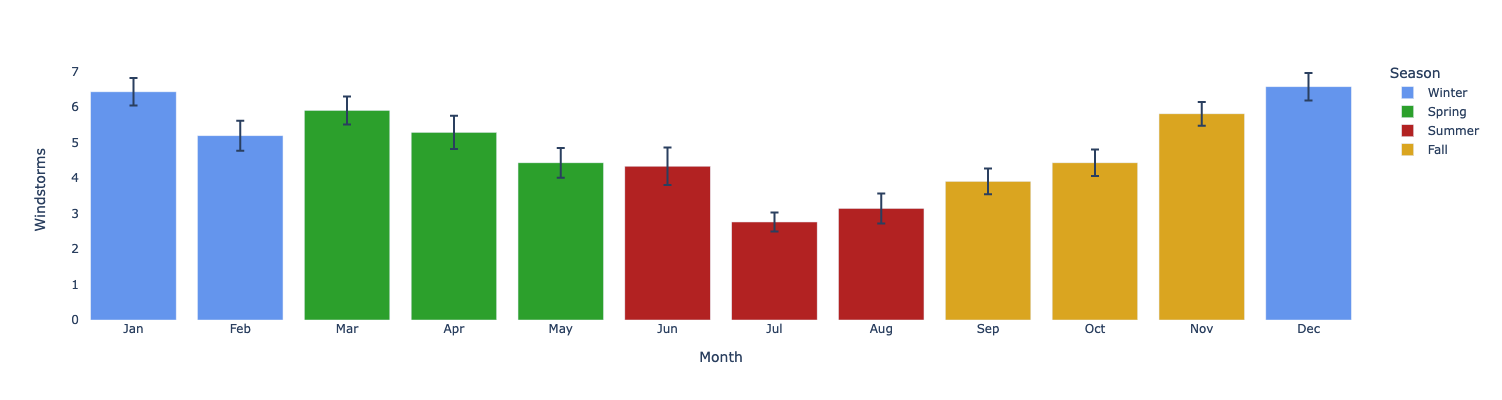

In [292]:
# std_error = df_d["Standard deviation"]/np.sqrt(21)
fig = px.bar(df_d, x='Month name', y='Average windstorms', color='Season', 
             color_discrete_map= {'Winter': 'cornflowerblue',
                                  'Spring': '#2CA02C',
                                  'Summer': 'firebrick',
                                  'Fall': 'goldenrod'}, 
             height=400, width=900,
             # error_y=std_error
             # error_y=CI_sizes
             # error_y=df_d["Standard deviation"]
             error_y=bootstrap_stde
             # error_y=BS_CI_sizes
            )
fig.update_layout(
    plot_bgcolor="white",
    xaxis_categoryarray=df_d['Month name'],
    xaxis_categoryorder="array",
    xaxis_title="Month",
    yaxis_title="Windstorms"
)
# margin=dict(t=10,l=10,b=10,r=10,
fig.write_image("bars.pdf", engine="kaleido")
fig.show()

In [293]:
# observed frequencies
observed_frequencies = df_d['Windstorms']

# number of observations
n = sum(observed_frequencies)
N = len(observed_frequencies)

# expected frequencies under the null hypothesis of a uniform distribution
expected_frequencies = [n/N for i in range(N)]

# compute the chi-squared statistic
chi_squared_statistic, p_value = chisquare(observed_frequencies, f_exp=expected_frequencies)

# if the p-value is less than the significance level (e.g. 0.05),
# we can reject the null hypothesis and conclude that the distribution is not uniform
if p_value < 0.05:
    print("The distribution is not uniform")
else:
    print("The distribution is uniform")
print(f'p-value: {p_value}')

The distribution is not uniform
p-value: 5.500522435078387e-11


In [294]:
print(scipy.stats.kstest(df_d['Average windstorms'], stats.uniform(loc=0.0, scale=5.0).cdf))

KstestResult(statistic=0.6166666666666666, pvalue=6.362494671580185e-05, statistic_location=4.333333333333333, statistic_sign=-1)


In [295]:
print(scipy.stats.kstest(df_d['Windstorms'], stats.uniform(loc=0.0, scale=100.0).cdf))

KstestResult(statistic=0.66, pvalue=1.1673591064158014e-05, statistic_location=91.0, statistic_sign=-1)


In [296]:
np.mean(df_d['Average windstorms'])

4.84920634920635

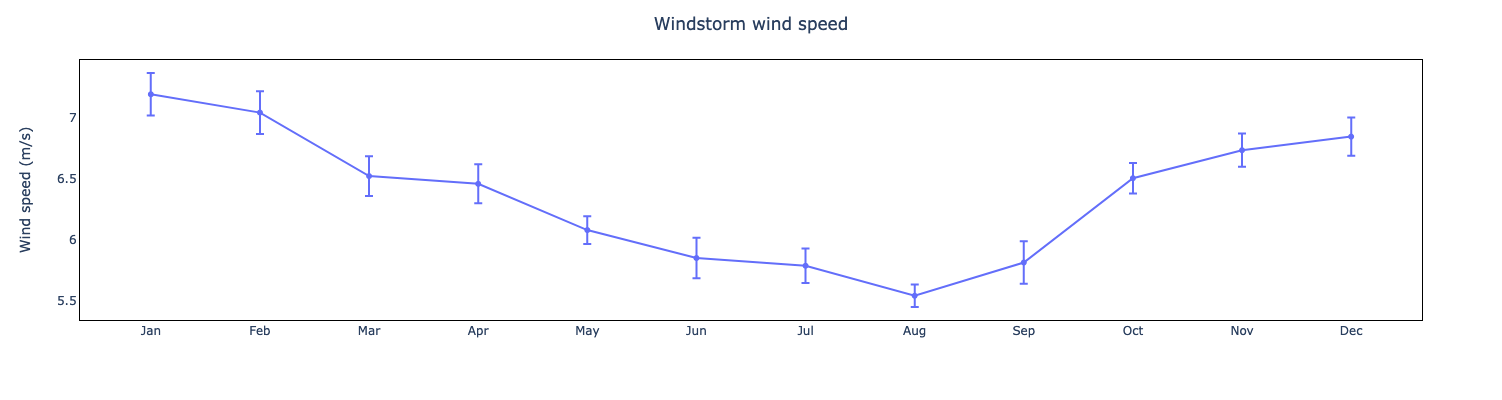

In [298]:
plt.rcParams['text.usetex'] = True
fig = px.line(df_d, x="Month name", y="Windstorm average wind speed (m/s)", height=400, width=600, markers=True, error_y=bootstrap_spd_stde)

fig.update_layout(
    plot_bgcolor="white",
    xaxis_title=" ",
    yaxis_title=f'Wind speed (m/s)',
    title_text='Windstorm wind speed', title_x=0.5 
)

fig.update_xaxes(
    mirror=True,
    showline=True,
    linecolor='black',
    # gridcolor='lightgrey'
)
fig.update_yaxes(
    mirror=True,
    showline=True,
    linecolor='black',
    # gridcolor='lightgrey'
)
fig.write_image("monthly_windspeed.pdf", engine="kaleido")
fig.show()

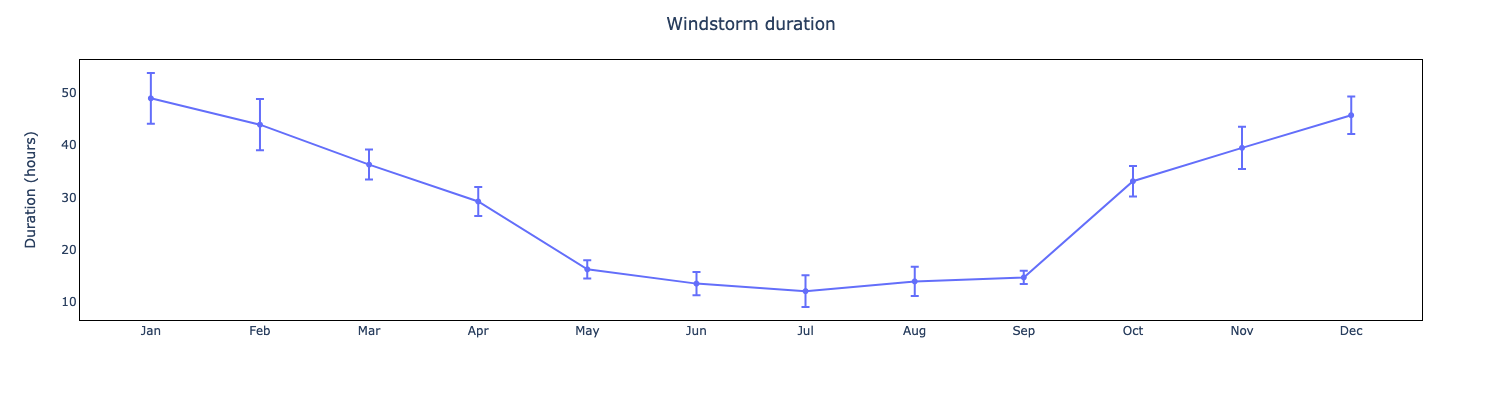

In [299]:
fig = px.line(df_d, x="Month name", y="Windstorm average duration (hours)", height=400, width=600, markers=True, error_y=bootstrap_dur_stde)

fig.update_layout(
    plot_bgcolor="white",
    xaxis_title=" ",
    yaxis_title="Duration (hours)",
    title_text='Windstorm duration', title_x=0.5 
)

fig.update_xaxes(
    mirror=True,
    showline=True,
    linecolor='black',
)
fig.update_yaxes(
    mirror=True,
    showline=True,
    linecolor='black',
)
fig.write_image("monthly_durations.pdf", engine="kaleido")
fig.show()

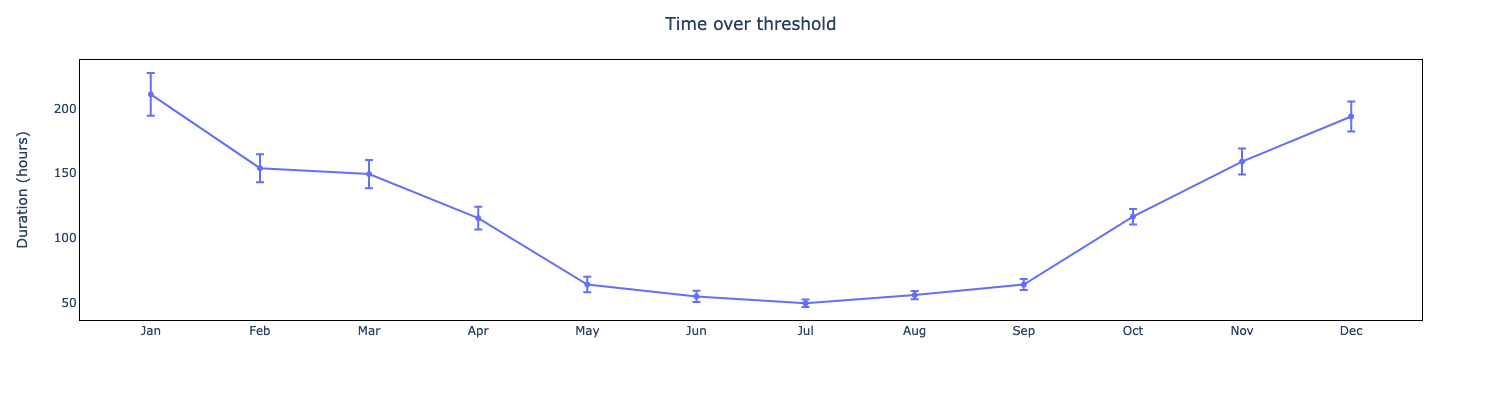

In [300]:
# are these error bars normalized by month or to the total cumulative over the years?

fig = px.line(df_d, x="Month name", y="Average time over threshold", height=400, width=600, markers=True, error_y=bootstrap_toth_stde)

fig.update_layout(
    plot_bgcolor="white",
    xaxis_title=" ",
    yaxis_title="Duration (hours)",
    title_text='Time over threshold', title_x=0.5 
)

fig.update_xaxes(
    mirror=True,
    showline=True,
    linecolor='black',
)
fig.update_yaxes(
    mirror=True,
    showline=True,
    linecolor='black',
)
fig.write_image("monthly_toth.pdf", engine="kaleido")
fig.show()

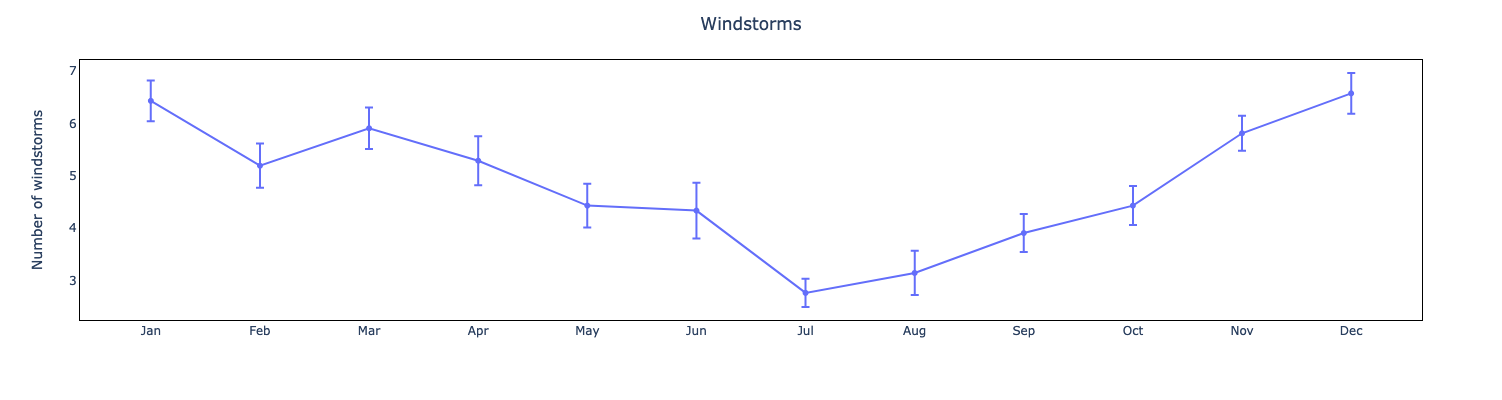

In [301]:
fig = px.line(df_d, x="Month name", y="Average windstorms", height=400, width=600, markers=True, error_y=bootstrap_stde)

fig.update_layout(
    plot_bgcolor="white",
    xaxis_title=" ",
    yaxis_title="Number of windstorms",
    title_text='Windstorms', title_x=0.5 
)

fig.update_xaxes(
    mirror=True,
    showline=True,
    linecolor='black',
)
fig.update_yaxes(
    mirror=True,
    showline=True,
    linecolor='black',
)
fig.write_image("monthly_windstorms.pdf", engine="kaleido")
fig.show()

In [302]:
bootstrap_stde[0]

0.38734913974638874

In [305]:
# normalize error bars by number of days in the month

# average_monthly_ws_stde = bootstrap_stde/21

average_daily_normalized_ws_stde = np.zeros(12)
average_daily_normalized_ws_stde[0] = bootstrap_stde[0]/31
average_daily_normalized_ws_stde[1] = bootstrap_stde[1]/28.25
average_daily_normalized_ws_stde[2] = bootstrap_stde[2]/31
average_daily_normalized_ws_stde[3] = bootstrap_stde[3]/30
average_daily_normalized_ws_stde[4] = bootstrap_stde[4]/31
average_daily_normalized_ws_stde[5] = bootstrap_stde[5]/30
average_daily_normalized_ws_stde[6] = bootstrap_stde[6]/31
average_daily_normalized_ws_stde[7] = bootstrap_stde[7]/31
average_daily_normalized_ws_stde[8] = bootstrap_stde[8]/30
average_daily_normalized_ws_stde[9] = bootstrap_stde[9]/31
average_daily_normalized_ws_stde[10] = bootstrap_stde[10]/30
average_daily_normalized_ws_stde[11] = bootstrap_stde[11]/31
average_daily_normalized_ws_stde

array([0.01249513, 0.01492949, 0.01273886, 0.01558827, 0.01345936,
       0.01769435, 0.00867721, 0.01364156, 0.01210322, 0.0120154 ,
       0.01119706, 0.01254338])

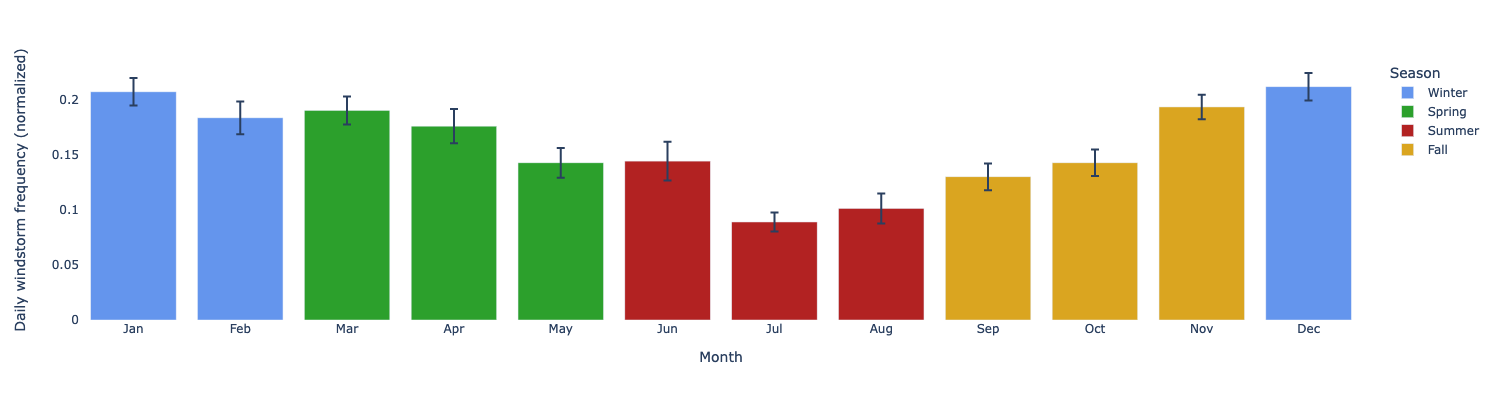

In [306]:
# Normalized by days in the month 

average_monthly_ws = df_d.Windstorms/21

average_daily_normalized_ws = np.zeros(12)
average_daily_normalized_ws[0] = average_monthly_ws[0]/31
average_daily_normalized_ws[1] = average_monthly_ws[1]/28.25
average_daily_normalized_ws[2] = average_monthly_ws[2]/31
average_daily_normalized_ws[3] = average_monthly_ws[3]/30
average_daily_normalized_ws[4] = average_monthly_ws[4]/31
average_daily_normalized_ws[5] = average_monthly_ws[5]/30
average_daily_normalized_ws[6] = average_monthly_ws[6]/31
average_daily_normalized_ws[7] = average_monthly_ws[7]/31
average_daily_normalized_ws[8] = average_monthly_ws[8]/30
average_daily_normalized_ws[9] = average_monthly_ws[9]/31
average_daily_normalized_ws[10] = average_monthly_ws[10]/30
average_daily_normalized_ws[11] = average_monthly_ws[11]/31
average_daily_normalized_ws

fig = px.bar(df_d, x='Month name', y=average_daily_normalized_ws, color='Season', 
             color_discrete_map= {'Winter': 'cornflowerblue',
                                  'Spring': '#2CA02C',
                                  'Summer': 'firebrick',
                                  'Fall': 'goldenrod'}, 
             height=400, width=900,
             # error_y=std_error
             # error_y=CI_sizes
             # error_y=df_d["Standard deviation"]
             error_y=average_daily_normalized_ws_stde
             # error_y=BS_CI_sizes
            )
fig.update_layout(
    plot_bgcolor="white",
    xaxis_categoryarray=df_d['Month name'],
    xaxis_categoryorder="array",
    xaxis_title="Month",
    yaxis_title="Daily windstorm frequency (normalized)"
)
# margin=dict(t=10,l=10,b=10,r=10,
# fig.write_image("monthly_normalized.pdf", engine="kaleido")
fig.show()

### Violin plots!

In [307]:
df_d_storms = df_d_storms.drop(columns=['Year'])

In [308]:
month_names == list(df_d_storms)

# d_d_storms, x='Month name', y='Average windstorms'

False

In [312]:
df_d_storms_short = df_d_storms.rename(columns={"January": "Jan", "February": "Feb", "March": "Mar", "April": "Apr", "May": "May", "June": "Jun", "July": "Jul", "August": "Aug", "September": "Sep", "October": "Oct", "November": "Nov", "December": "Dec"})
df_d_storms_short

Jan  Feb  Mar  Apr  May  Jun  Jul  Aug  Sep  Oct  Nov  Dec
0     9    9    9    8    4    6    4    7    5    5    5    7
1     5    2    7    5    7    3    2    1    7    5    4    5
2     6    3    7    5    6    2    3    1    7    5    5    6
3     6    4    4    7    3    5    2    2    2    3    5    5
4     5    4    7    5    6    1    5    1    5    4    9    5
5     5    7    4    8    4    2    3    3    2    3    6    9
6    10    6    7    8    8    5    3    7    3    2    6    7
7     6    6    5    4    4    6    2    1    5    4    4    6
8     4    2    4    6    8    1    4    4    6    5    8    6
9     6    8    9    9    2    8    3    5    2    6    4    4
10    9    4    4    4    4   11    3    7    5    3    8    9
11    4    6    5    5    4    5    3    2    5    8    7    9
12    7    5   10    4    2    7    1    2    3    5    3    4
13    6    5    5    4    1    2    4    4    2    1    8    5
14    7    8    7    5    4    4    4    4    4    7    5    8
15    4    6    5    2    4    2    4    3    1    7    6    7
16    6    5    5    5    3    4    1    4    2    3    5    6
17    9    6    4    8    2    3    3    3    4    4    7    8
18    7    7    6    3    6    4    3    1    4    3    6    4
19    9    3    4    0    6    6    0    2    4    6    5    9
20    5    3    6    6    5    4    1    2    4    4    6    9

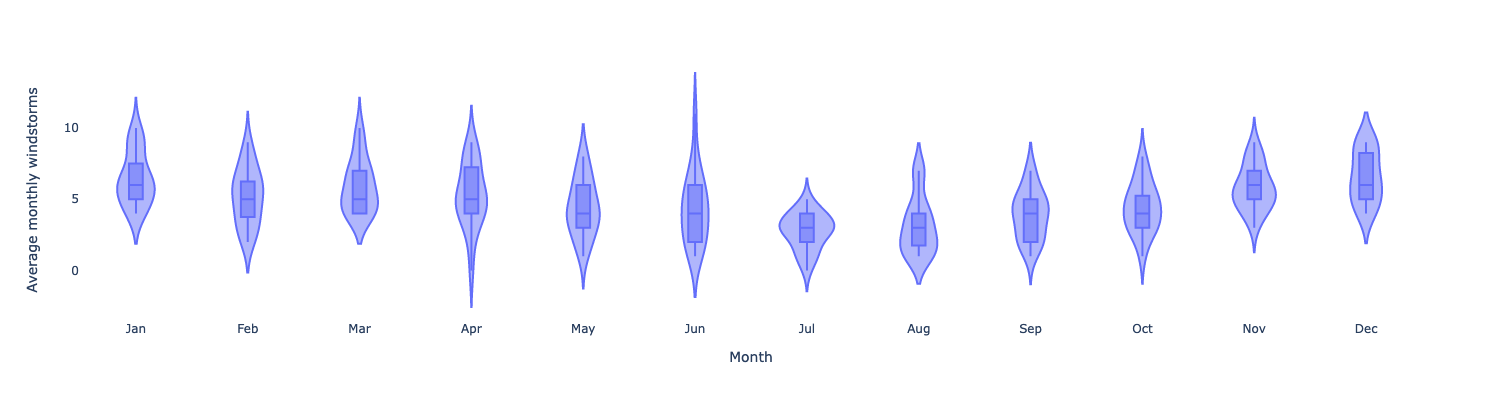

In [313]:
fig = px.violin(data_frame=df_d_storms_short,box=True,
                  height=400, width=800)
# points='all',  to add datapoints
fig.update_layout(
    plot_bgcolor="white",
    xaxis_title="Month",
    yaxis_title="Average monthly windstorms"
    # title_text='Windstorms', title_x=0.5 
)
    
fig.show()
# fig.write_image("violin.pdf")
# fig.write_image("monthly_violin.pdf", engine="kaleido")

In [314]:
df_d

Month Month name  Season  Windstorms  Average windstorms  \
0       1        Jan  Winter       135.0            6.428571   
1       2        Feb  Winter       109.0            5.190476   
2       3        Mar  Spring       124.0            5.904762   
3       4        Apr  Spring       111.0            5.285714   
4       5        May  Spring        93.0            4.428571   
5       6        Jun  Summer        91.0            4.333333   
6       7        Jul  Summer        58.0            2.761905   
7       8        Aug  Summer        66.0            3.142857   
8       9        Sep    Fall        82.0            3.904762   
9      10        Oct    Fall        93.0            4.428571   
10     11        Nov    Fall       122.0            5.809524   
11     12        Dec  Winter       138.0            6.571429   

    Windstorm standard deviation  Windstorm average wind speed (m/s)  \
0                       1.788094                            7.187651   
1                       1.942484                            7.038564   
2                       1.796949                            6.520917   
3                       2.163394                            6.457721   
4                       1.916630                            6.080506   
5                       2.416872                            5.852647   
6                       1.230747                            5.789619   
7                       1.958758                            5.545254   
8                       1.659167                            5.816069   
9                       1.706331                            6.503852   
10                      1.531232                            6.731814   
11                      1.761261                            6.842723   

    Wind speed standard deviation  Windstorm average duration (hours)  \
0                        0.793485                           48.955395   
1                        0.801016                           43.915740   
2                        0.747183                           36.271306   
3                        0.715227                           29.215610   
4                        0.518227                           16.224173   
5                        0.760472                           13.493354   
6                        0.632479                           12.049944   
7                        0.421067                           13.917668   
8                        0.793990                           14.679652   
9                        0.570077                           33.093587   
10                       0.616495                           39.482662   
11                       0.707951                           45.730277   

    Duration standard deviation  Windstorm hours  Average windstorm hours  \
0                     22.488043      1028.063294                48.955395   
1                     22.507642       922.230549                43.915740   
2                     13.073700       761.697421                36.271306   
3                     12.297442       584.312196                27.824390   
4                      8.136705       340.707639                16.224173   
5                     10.088056       283.360438                13.493354   
6                     13.399458       240.998889                11.476138   
7                     12.888188       292.271032                13.917668   
8                      5.748004       308.272698                14.679652   
9                     13.445735       694.965317                33.093587   
10                    18.535335       829.135893                39.482662   
11                    16.434686       960.335813                45.730277   

    Windstorm hours standard deviation  Time over threshold  \
0                           130.218611          4426.283333   
1                            98.295473          3229.850000   
2                           102.372826          3134.550000   
3                            9

In [ ]:
df_d_storms

January  February  March  April  May  June  July  August  September  \
0         9         9      9      8    4     6     4       7          5   
1         5         2      7      5    7     3     2       1          7   
2         6         3      7      5    6     2     3       1          7   
3         6         4      4      7    3     5     2       2          2   
4         5         4      7      5    6     1     5       1          5   
5         5         7      4      8    4     2     3       3          2   
6        10         6      7      8    8     5     3       7          3   
7         6         6      5      4    4     6     2       1          5   
8         4         2      4      6    8     1     4       4          6   
9         6         8      9      9    2     8     3       5          2   
10        9         4      4      4    4    11     3       7          5   
11        4         6      5      5    4     5     3       2          5   
12        7         5     10      4    2     7     1       2          3   
13        6         5      5      4    1     2     4       4          2   
14        7         8      7      5    4     4     4       4          4   
15        4         6      5      2    4     2     4       3          1   
16        6         5      5      5    3     4     1       4          2   
17        9         6      4      8    2     3     3       3          4   
18        7         7      6      3    6     4     3       1          4   
19        9         3      4      0    6     6     0       2          4   
20        5         3      6      6    5     4     1       2          4   

    October  November  December  
0         5         5         7  
1         5         4         5  
2         5         5         6  
3         3         5         5  
4         4         9         5  
5         3         6         9  
6         2         6         7  
7         4         4         6  
8         5         8         6  
9         6         4         4  
10        3         8         9  
11        8         7         9  
12        5         3         4  
13        1         8         5  
14        7         5         8  
15        7         6         7  
16        3         5         6  
17        4         7         8  
18        3         6         4  
19        6         5         9  
20        4         6         9

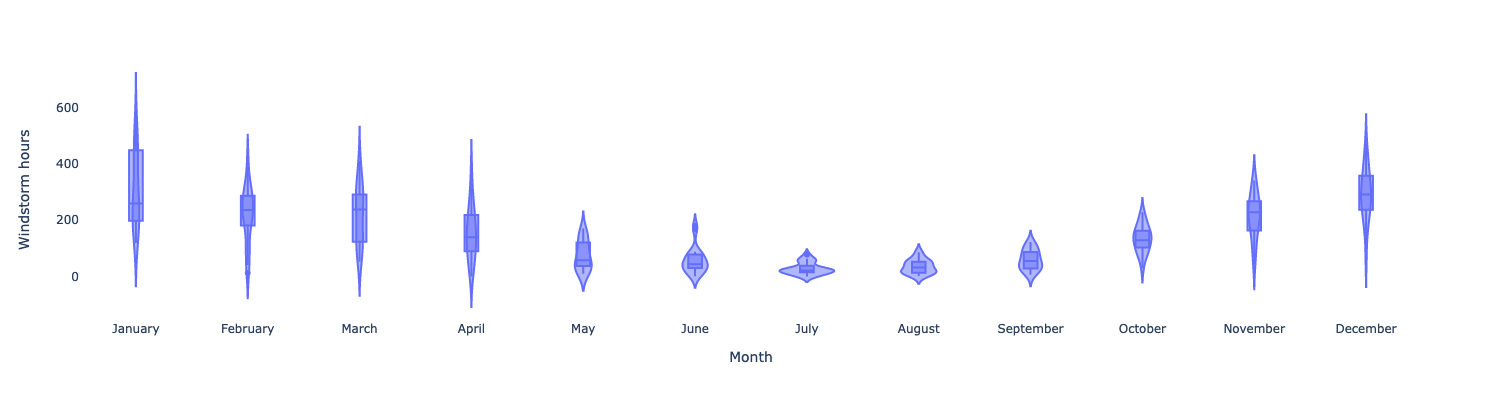

In [317]:
df_d_storm_hours = df_d_storm_hours.drop(columns=['Year'])

fig = px.violin(data_frame=df_d_storm_hours,box=True, 
                  height=400, width=800)
# points='all',  to add datapoints
fig.update_layout(
    plot_bgcolor="white",
    xaxis_title="Month",
    yaxis_title="Windstorm hours"
    # title_text='Windstorms', title_x=0.5 
)
    
fig.show()
# fig.write_image("violin.pdf")
# fig.write_image("violin.pdf", engine="kaleido")

<Axes: >

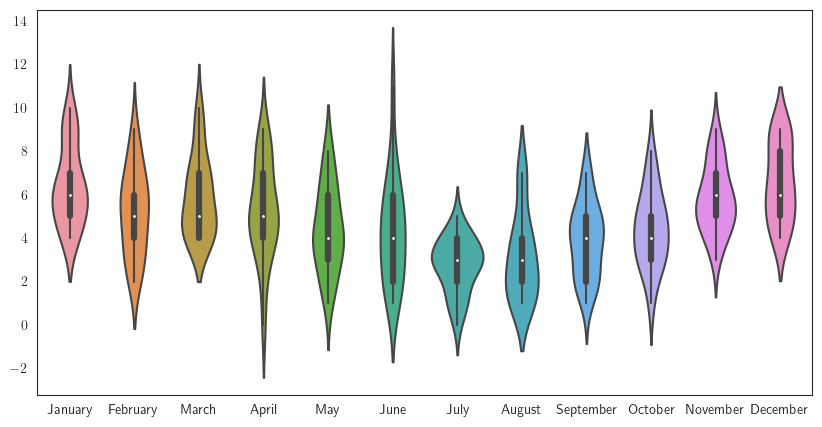

In [319]:
fig, axes = plt.subplots(figsize=(10,5))
sns.set(style="whitegrid")
sns.violinplot(data=df_d_storms, ax = axes, orient ='v')

<Axes: >

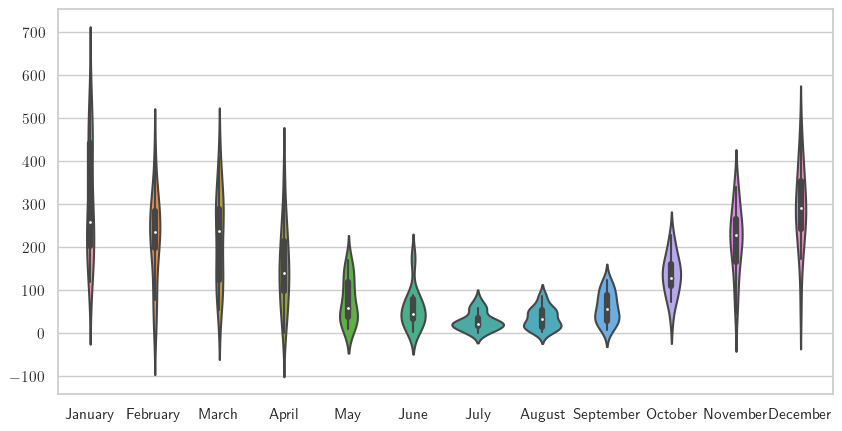

In [320]:
fig, axes = plt.subplots(figsize=(10,5))
sns.set(style="whitegrid")
sns.violinplot(data=df_d_storm_hours, ax = axes, orient ='v')

#### Data for seasonal plots

In [321]:
d_d = {'Storms': storms_in_months}

df_d = pd.DataFrame(data=d_d)
df_d.to_csv(r'monthly_distributions.csv', index=False)

df_d

Storms
0          1
1          1
2          1
3          1
4          1
...      ...
1217      12
1218      12
1219      12
1220      12
1221      12

[1222 rows x 1 columns]

In [322]:
dfm = {'Month': months, 'Number of storms': monthly_storms}
dfm = pd.DataFrame(data=dfm)
# dfm = dfm.set_index('Month')
dfm

Month  Number of storms
0       1             135.0
1       2             109.0
2       3             124.0
3       4             111.0
4       5              93.0
5       6              91.0
6       7              58.0
7       8              66.0
8       9              82.0
9      10              93.0
10     11             122.0
11     12             138.0

In [323]:
dfm_avg = {'Month': months, 'Number of storms': np.array(monthly_storms)/len(years)}
dfm_avg = pd.DataFrame(data=dfm_avg)
# dfm = dfm.set_index('Month')
dfm_avg

Month  Number of storms
0       1          6.428571
1       2          5.190476
2       3          5.904762
3       4          5.285714
4       5          4.428571
5       6          4.333333
6       7          2.761905
7       8          3.142857
8       9          3.904762
9      10          4.428571
10     11          5.809524
11     12          6.571429

In [327]:
month_abbrev = ['J','F','M','A','M','J','J','A','S','O','N','D']

### Prep for deseasonalizing -- run classifier every month throughout time series

In [330]:
subset = ['Year', 'DOY', 'MST', f'Avg Wind Speed @ {height} [m/s]', f'Avg Wind Direction @ {height} [deg]']
yearly_monthly_storms = [] 

for i in np.arange(2002,2023,1): 
    year = i

    df = pd.read_csv(f'/Users/serena/Documents/Research/Data/{year}_data.csv', usecols=lambda x: x in subset)
    df.insert(2, 'Date (MM/DD/YYYY)', df['DOY'].apply(doy_to_date, args=(year,))) 
    df = df.replace(-99999.0, np.nan)
    df['Date (MM/DD/YYYY)'] = pd.to_datetime(df['Date (MM/DD/YYYY)'], format='%m/%d/%Y') # convert date column to DateTime
    df.set_index('Date (MM/DD/YYYY)')
    
    sort = list(df.groupby(df['Date (MM/DD/YYYY)'].dt.month))
    monthly_data = []
    
    for k in range(len(sort)): #12
        monthly_data.append(sort[k][1])    
    
    monthly_storms = np.zeros(12)

    for j in range(len(monthly_data)): #12
        monthly_data[j] = monthly_data[j].reset_index()
        monthly_data[j] = monthly_data[j].rename(columns={'index': 'Overall index'})
        storms_with_lulls = [storm                                                       
                     for storm in                                                
                     WindstormWithLulls.storms_by_threshold(monthly_data[j], 4.5, 12*60, [240, 330])         
                     if storm.duration >= 60 and np.median(storm.speed) >= 4.5 and np.mean(storm.speed) >= 4.5]   
        
        # monthly_storms[j] = len(storms_with_lulls)    
        yearly_monthly_storms.append(len(storms_with_lulls))
    
    print(f'Finished {year}')

Finished 2002
Finished 2003
Finished 2004
Finished 2005
Finished 2006
Finished 2007
Finished 2008
Finished 2009
Finished 2010
Finished 2011
Finished 2012
Finished 2013
Finished 2014
Finished 2015
Finished 2016
Finished 2017
Finished 2018
Finished 2019
Finished 2020
Finished 2021
Finished 2022


In [331]:
full_months = np.arange(1,253,1)
len(full_months)
# len(yearly_monthly_storms)

252

In [332]:
d_d = {'Month': full_months, 'Windstorms': yearly_monthly_storms}

df_d = pd.DataFrame(data=d_d)
# df_d.to_csv(r'full_monthly_storms.csv', index=False)

df_d

Month  Windstorms
0        1           9
1        2           9
2        3           9
3        4           8
4        5           4
..     ...         ...
247    248           2
248    249           4
249    250           4
250    251           6
251    252           9

[252 rows x 2 columns]

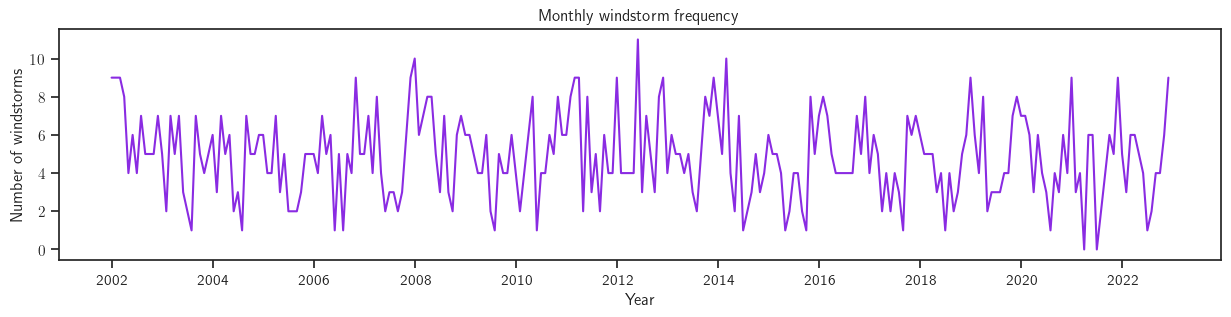

Slope of best fit: -0.002551810450649868


In [333]:
y = yearly_monthly_storms
x = np.arange(len(y))
x = sm.add_constant(x)

mod = sm.OLS(y, x)
result = mod.fit()

plt.figure(figsize=(15,3)) # alternate colors with every other year for visibility? https://stackoverflow.com/questions/37787632/different-color-for-line-depending-on-corresponding-values-in-pyplot
plt.plot(yearly_monthly_storms,'-', color='blueviolet', label='Observations')

trend = np.polyfit(full_months,yearly_monthly_storms, 1)
trendpoly = np.poly1d(trend) 

# plt.plot(full_months,trendpoly(full_months), color='teal',label=f'First order fit: $m={np.round(trend[0],3)}, p={np.round(result.pvalues[1],3)}$')
plt.xlabel("Year")
plt.ylabel("Number of windstorms")
plt.xticks(ticks = np.arange(0,253,24), labels=years[::2])
# plt.legend(loc="best",prop={'size': 12}) 
plt.title(f"Monthly windstorm frequency")
# plt.savefig(f'full_monthly_windstorms.pdf',bbox_inches='tight')
plt.show()
print(f'Slope of best fit: {trend[0]}')

In [334]:
scipy.stats.spearmanr(full_months, yearly_monthly_storms) 

SignificanceResult(statistic=-0.08797977636654387, pvalue=0.1638032812966889)

In [335]:
x = full_months
y = yearly_monthly_storms

# Fit the Ordinary Least Squares Regression model
model = sm.OLS(y, sm.add_constant(x))
ols_result = model.fit()

# Extract the model parameters
ols_params = ols_result.params

# Print the model equation
ols_equation = "y = {:.4f}x + {:.2f}".format(ols_params[1], ols_params[0])
print(ols_equation)

# Print the summary of the model
print(ols_result.summary())

y = -0.0026x + 5.17
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.813
Date:                Sat, 28 Oct 2023   Prob (F-statistic):              0.179
Time:                        10:55:57   Log-Likelihood:                -553.96
No. Observations:                 252   AIC:                             1112.
Df Residuals:                     250   BIC:                             1119.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.1720      0.277

In [336]:
# Fit the Generalized Least Squares Regression model
model = sm.GLS(y, sm.add_constant(x))
gls_result = model.fit()

# Extract the model parameters
gls_params = gls_result.params

# Print the model equation
gls_equation = "y = {:.4f}x + {:.2f}".format(gls_params[1], gls_params[0])
print(gls_equation)

# Print the summary of the model
print(gls_result.summary())

y = -0.0026x + 5.17
                            GLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.007
Model:                            GLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.813
Date:                Sat, 28 Oct 2023   Prob (F-statistic):              0.179
Time:                        10:55:59   Log-Likelihood:                -553.96
No. Observations:                 252   AIC:                             1112.
Df Residuals:                     250   BIC:                             1119.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.1720      0.277

In [337]:
# Fit the Poisson Regression model
model = sm.GLM(y, sm.add_constant(x), family=sm.families.Poisson())
pois_result = model.fit()

# Extract the model parameters
poisson_params = pois_result.params

# Print the model equation
poisson_equation = "y = exp({:.4f}x + {:.2f})".format(poisson_params[1], poisson_params[0])
print(poisson_equation)

# Print the summary of the model
print(pois_result.summary())

y = exp(-0.0005x + 1.64)
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  252
Model:                            GLM   Df Residuals:                      250
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -552.37
Date:                Sat, 28 Oct 2023   Deviance:                       267.59
Time:                        10:56:00   Pearson chi2:                     247.
No. Iterations:                     4   Pseudo R-squ. (CS):           0.007082
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.6447      

In [338]:
# Fit the Negative Binomial Regression model
model = sm.GLM(y, sm.add_constant(x), family=sm.families.NegativeBinomial())
nb_result = model.fit()

# Extract the model parameters
nb_params = nb_result.params

# Print the model equation
print("y = exp({:.4f}x + {:.2f})".format(nb_params[1], nb_params[0]))

# Print the summary of the model
print(nb_result.summary())

y = exp(-0.0005x + 1.64)
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  252
Model:                            GLM   Df Residuals:                      250
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -674.07
Date:                Sat, 28 Oct 2023   Deviance:                       54.452
Time:                        10:56:01   Pearson chi2:                     42.4
No. Iterations:                     4   Pseudo R-squ. (CS):           0.001218
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.6449      

In [339]:
np.mean(yearly_monthly_storms)

4.849206349206349

In [340]:
(np.std(yearly_monthly_storms))**2

4.786785084404132

In [341]:
# Fit Poisson GLM model
# model = sm.GLM(y, sm.add_constant(x), family=sm.families.Poisson()).fit()
model = pois_result

# Calculate Pearson chi-square test statistic and p-value
pearson_chi2 = model.pearson_chi2
pearson_df = model.df_resid
pearson_p = 1 - stats.chi2.cdf(pearson_chi2, pearson_df)

# Print results
if pearson_p < 0.05:
    print(f"Observed deviance is significantly larger than expected, indicating overdispersion (Pearson chi-square test: chi2 = {pearson_chi2}, df = {pearson_df}, p = {pearson_p})")
else:
    print(f"Observed deviance is not significantly different from expected (Pearson chi-square test: chi2 = {pearson_chi2}, df = {pearson_df}, p = {pearson_p})")


Observed deviance is not significantly different from expected (Pearson chi-square test: chi2 = 247.46213101884905, df = 250, p = 0.5334869129488955)


In [342]:
storms_df = {'Month': np.concatenate([months]*21).ravel(), 'Year': np.repeat((years), 12), 'Windstorms': yearly_monthly_storms}
storms_df = pd.DataFrame(data=storms_df)
storms_df

Month  Year  Windstorms
0        1  2002           9
1        2  2002           9
2        3  2002           9
3        4  2002           8
4        5  2002           4
..     ...   ...         ...
247      8  2022           2
248      9  2022           4
249     10  2022           4
250     11  2022           6
251     12  2022           9

[252 rows x 3 columns]

#### Windstorm hours

In [343]:
subset = ['Year', 'DOY', 'MST', f'Avg Wind Speed @ {height} [m/s]', f'Avg Wind Direction @ {height} [deg]']
yearly_monthly_storms = [] 
yearly_monthly_storm_hours = [] 

for i in np.arange(2002,2023,1): 
    year = i

    df = pd.read_csv(f'/Users/serena/Documents/Research/Data/{year}_data.csv', usecols=lambda x: x in subset)
    df.insert(2, 'Date (MM/DD/YYYY)', df['DOY'].apply(doy_to_date, args=(year,))) 
    df = df.replace(-99999.0, np.nan)
    df['Date (MM/DD/YYYY)'] = pd.to_datetime(df['Date (MM/DD/YYYY)'], format='%m/%d/%Y') # convert date column to DateTime
    df.set_index('Date (MM/DD/YYYY)')
    
    sort = list(df.groupby(df['Date (MM/DD/YYYY)'].dt.month))
    monthly_data = []
    
    for k in range(len(sort)): #12
        monthly_data.append(sort[k][1])  
        
    monthly_storms = np.zeros(12)
    monthly_storm_hours = np.zeros(12)

    for j in range(len(monthly_data)): #12
        monthly_data[j] = monthly_data[j].reset_index()
        monthly_data[j] = monthly_data[j].rename(columns={'index': 'Overall index'})
        
        storms_with_lulls = [storm                                                       
                     for storm in                                                
                     WindstormWithLulls.storms_by_threshold(monthly_data[j], 4.5, 12*60, [240, 330])         
                     if storm.duration >= 60 and np.median(storm.speed) >= 4.5 and np.mean(storm.speed) >= 4.5]   
        
        storm_durations = [storm.duration for storm in storms_with_lulls]       
        yearly_monthly_storms.append(len(storms_with_lulls))
        yearly_monthly_storm_hours.append(np.sum(storm_durations)/60)
    
    print(f'Finished {year}')

Finished 2002
Finished 2003
Finished 2004
Finished 2005
Finished 2006
Finished 2007
Finished 2008
Finished 2009
Finished 2010
Finished 2011
Finished 2012
Finished 2013
Finished 2014
Finished 2015
Finished 2016
Finished 2017
Finished 2018
Finished 2019
Finished 2020
Finished 2021
Finished 2022


In [344]:
len(yearly_monthly_storm_hours)

252

In [345]:
d_d2 = {'Month': full_months, 'Windstorms': yearly_monthly_storms, 'Windstorm hours': yearly_monthly_storm_hours}

df_d2 = pd.DataFrame(data=d_d2)
df_d2.to_csv(r'full_monthly_storms_w_hours.csv', index=False)

df_d2

Month  Windstorms  Windstorm hours
0        1           9       292.650000
1        2           9       237.533333
2        3           9       328.283333
3        4           8       215.033333
4        5           4        78.016667
..     ...         ...              ...
247    248           2        86.183333
248    249           4        46.600000
249    250           4       145.850000
250    251           6        81.600000
251    252           9       379.200000

[252 rows x 3 columns]

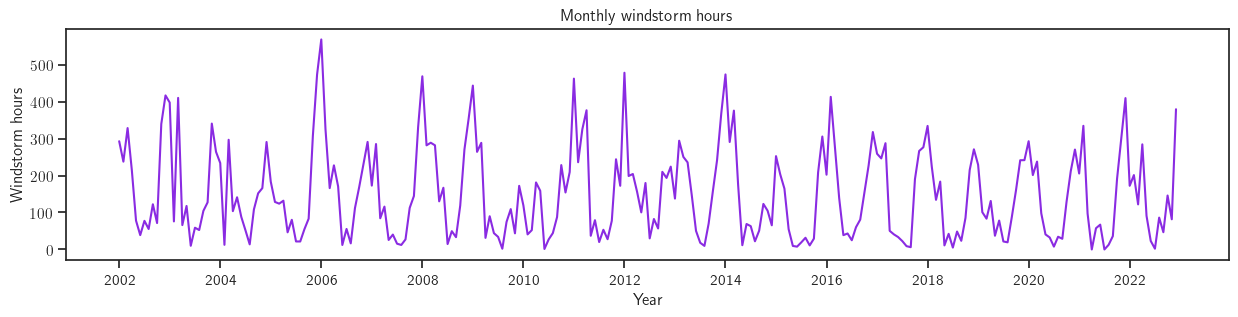

In [346]:
y = yearly_monthly_storm_hours
x = np.arange(len(y))
x = sm.add_constant(x)

mod = sm.GLS(y, x)
result = mod.fit()

plt.figure(figsize=(15,3))
plt.plot(yearly_monthly_storm_hours,'-', color='blueviolet', label='Observations')

# plt.plot(full_months,trendpoly(full_months), color='teal',label=f'First order fit: $m={np.round(trend[0],3)}, p={np.round(result.pvalues[1],3)}$')
plt.xlabel("Year")
plt.ylabel("Windstorm hours")
plt.xticks(ticks = np.arange(0,253,24), labels=years[::2])
# plt.legend(loc="best",prop={'size': 12}) 
plt.title(f"Monthly windstorm hours")
# plt.savefig(f'full_monthly_windstorms.pdf',bbox_inches='tight')
plt.show()

In [347]:
spearman = scipy.stats.spearmanr(yearly_monthly_storm_hours, yearly_monthly_storms) 

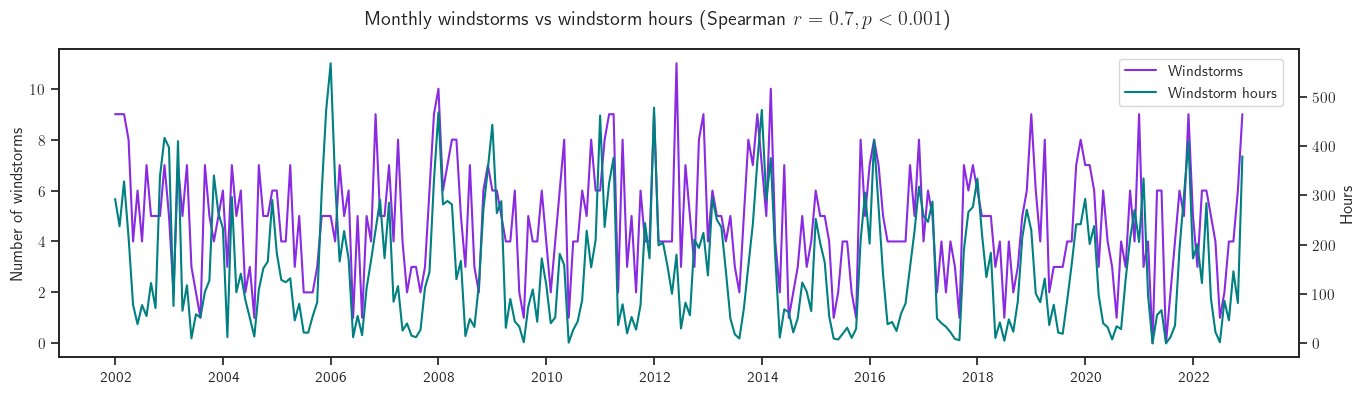

In [348]:
fig, ax1 = plt.subplots(figsize=(16, 4))
ax2 = ax1.twinx()

ax1.plot(yearly_monthly_storms,'-', color='blueviolet', label='Windstorms')
ax2.plot(yearly_monthly_storm_hours,'-', color='teal', label='Windstorm hours')

# ax1.set_xlabel("Year")
ax1.set_xticks(ticks = np.arange(0,253,24), labels = np.arange(2002,2023,2))
ax1.set_ylabel("Number of windstorms")
ax1.tick_params(axis="y")

ax2.set_ylabel("Hours")
ax2.tick_params(axis="y")
fig.legend(loc='upper right', bbox_to_anchor=(0.895, 0.875))

# fig.suptitle("Yearly windstorms vs windstorm hours")
fig.suptitle(f"Monthly windstorms vs windstorm hours (Spearman $r={np.round(spearman[0],2)}, p<0.001$)")
# fig.savefig('yearly_comparison.pdf')
plt.show()

### FFT

In [362]:
## Calculate the power spectrum of red noise with lag1_r to use for significance testing
alpha = 0.95 ## set statistical significance level
data = yearly_monthly_storms
var_str = "Windstorm events"

### step 1: calculate lag-1 autocorrelation (lag1_r, rho) and the associated p value (lag1_p)
lag1_r,lag1_p = stats.pearsonr(data[0:len(data)-1],data[1:len(data)])
print(lag1_p)

### step 2: Calculate e-folding time for a red-noise process with this lag-1 autocorrelation
Te = -1./np.log(lag1_r) # After Hartman 6.62 with delta t = 1
print(var_str,'lag-1 autocorrelation =',round(lag1_r,2),'and Te =',round(Te,0))

## calculate the power spectrum of red noise with lag1_r to use for significance testing
red_fit_n = create_normalized_redfit(len(data),Te)
dof_entirewindow=2 ### note dof=2 because using whole record for FFT with no chunking
f_bounds = create_f_bounds(alpha,dof_entirewindow,red_fit_n)  ## using f-test for variance, see function

## multiple DOF by 1.2 to account for extra smoothing Hanning (Barnes Ch. 4 Eq. 59)
f_bounds_hanning = create_f_bounds(alpha,dof_entirewindow*1.2,red_fit_n)  

## Method #1: Numpy Method - Calculate Power Spectrum
freq = np.fft.rfftfreq(len(data),d=1.)  ### 
#print(freq)
A = np.fft.rfft(data) ### r = real
ps = (np.abs(A)**2)/2.
ps_n = (np.abs(A)**2)/np.sum(np.abs(A)**2)  ## normalizing - calculate percent of the total  

0.0010262040882871352
Windstorm events lag-1 autocorrelation = 0.21 and Te = 1.0


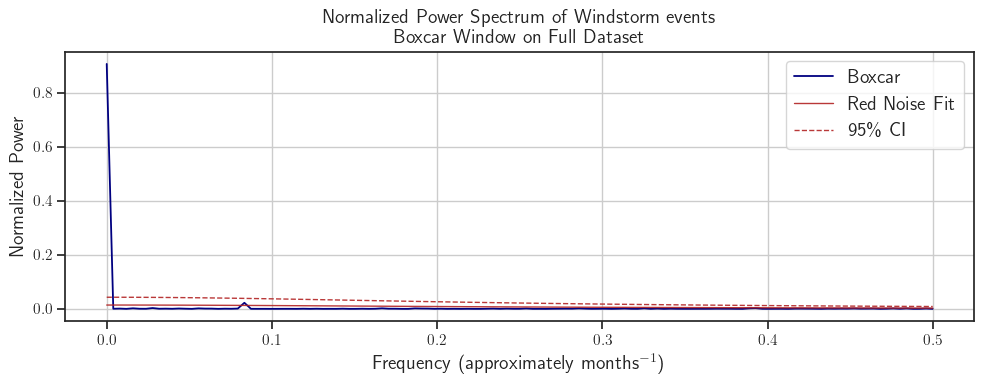

In [363]:
### Plot the results -- (Petit et al. 1999)
fig = plt.figure(figsize=(10,4))
method_str = "Boxcar Window on Full Dataset"
plt.plot(freq,ps_n, color='navy', lw=1.3, label='Boxcar')
plt.plot(freq,red_fit_n, color='firebrick', lw=1, alpha=0.9, label='Red Noise Fit') # freq plots 0...0.5
plt.plot(freq,f_bounds, color='firebrick', lw=1, ls='--', alpha=0.9, label=str(int(alpha*100))+'\% CI')
# plt.ylim(0.0,0.3)
# plt.xlim(0.0,0.06)
plt.xlabel("Frequency (approximately months$^{-1}$)",fontsize=14)
plt.ylabel("Normalized Power",fontsize=14)
plt.title("Normalized Power Spectrum of "+var_str+"\n"+method_str,fontsize=14)
plt.legend(loc='upper right',fontsize=14)
plt.grid()
fig.tight_layout()

In [364]:
# Find the significant spectral peaks
for i in range(len(ps_n)):
    if (ps_n[i] - f_bounds[i]) > 0:
        print('Found a spectral peak that exceeds red noise:')
        print('exceeds by...',ps_n[i]-f_bounds[i])
        print('at frequency....',freq[i])
        # print('which in years is...',(1.0/(freq[i]))/12.0)

Found a spectral peak that exceeds red noise:
exceeds by... 0.8645376708404864
at frequency.... 0.0


In [365]:
print('* For reference *')
print('monthly in frequency:',round(1/1,3))
print('seasonally in frequency:',round(1/3,3))
print('yearly in frequency:',round(1/12,3))
print('every 4 years in frequency:',round(1/(12*4),3))
print('every 8 years in frequency:',round(1/(12*8),5))  

* For reference *
monthly in frequency: 1.0
seasonally in frequency: 0.333
yearly in frequency: 0.083
every 4 years in frequency: 0.021
every 8 years in frequency: 0.01042


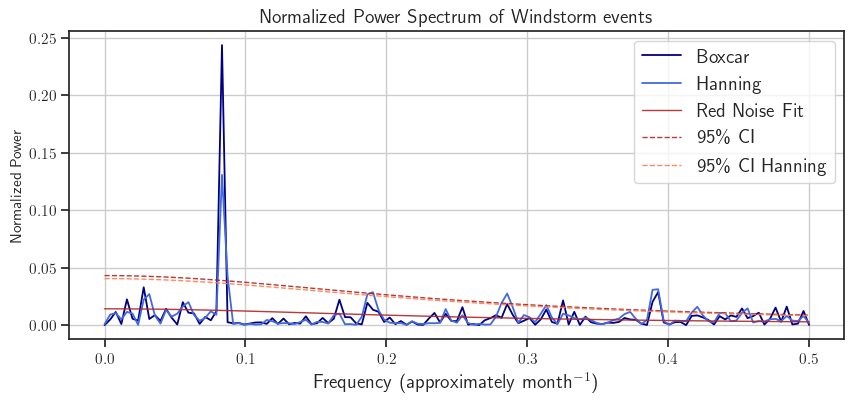

In [366]:
# Scipy Method... Compare Boxcar (sqaure) Window with a Hanning (tapered) Window

## Use Boxcar Window
f,Pxx = signal.periodogram(data,fs=1.,window='boxcar',nfft=None,return_onesided=True,scaling='spectrum')
Pxx_n = Pxx/np.sum(Pxx)

## Use Hanning Window
f_h,Pxx_h = signal.periodogram(data,fs=1.,window='hann',nfft=None,return_onesided=True,scaling='spectrum')
Pxx_h_n = Pxx_h/np.sum(Pxx_h)

fig = plt.figure(figsize=(10,4))
plt.plot(f,Pxx_n, color='navy', lw=1.3, label='Boxcar')
plt.plot(f_h,Pxx_h_n, color='royalblue', lw=1.3, label='Hanning')
plt.plot(freq,red_fit_n, color='firebrick', lw=1, alpha=0.9, label='Red Noise Fit')
plt.plot(freq,f_bounds, color='firebrick', lw=1, ls='--', alpha=0.9, label=str(int(alpha*100))+'\% CI')
plt.plot(freq,f_bounds_hanning, color='coral', lw=1, ls='--', alpha=0.9, label=str(int(alpha*100))+'\% CI Hanning')
# plt.ylim(0.0,0.3)
# plt.xlim(0.0,0.06)
plt.xlabel("Frequency (approximately month$^{-1}$)",fontsize=14)
plt.ylabel("Normalized Power",fontsize=11)
plt.title("Normalized Power Spectrum of "+var_str,fontsize=14)
plt.legend(loc='upper right',fontsize=14)
plt.grid()

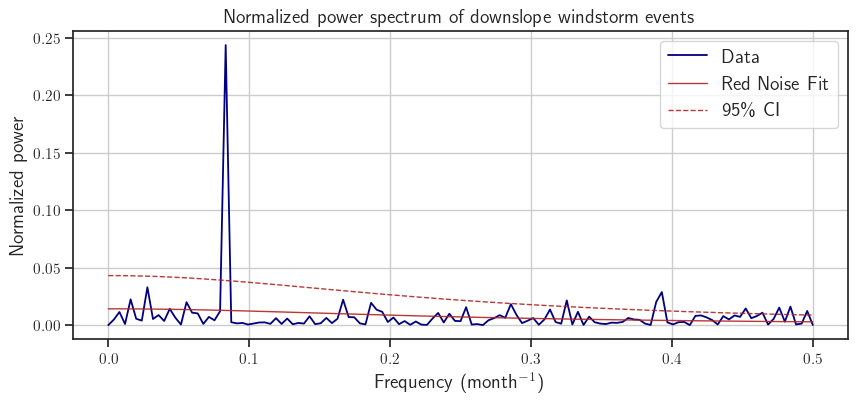

In [367]:
## Use Boxcar Window
alpha_level = 0.95 ## set statistical significance level

f,Pxx = signal.periodogram(data,fs=1.,window='boxcar',nfft=None,return_onesided=True,scaling='spectrum')
Pxx_n = Pxx/np.sum(Pxx)

fig = plt.figure(figsize=(10,4))
plt.plot(f,Pxx_n, color='navy', lw=1.3, label='Data')
plt.plot(freq,red_fit_n, color='firebrick', lw=1, alpha=0.9, label='Red Noise Fit')
plt.plot(freq,f_bounds, color='firebrick', lw=1, ls='--', alpha=0.9, label=str(int(alpha_level*100))+'\% CI')
# plt.ylim(0.0,0.3)
# plt.xlim(0.0,0.06)
plt.xlabel("Frequency (month$^{-1}$)",fontsize=14)
plt.ylabel("Normalized power",fontsize=14)
plt.title("Normalized power spectrum of downslope windstorm events",fontsize=14)
plt.legend(loc='upper right',fontsize=14)
plt.grid()
# plt.savefig('spectral_analysis.pdf',bbox_inches='tight')

In [368]:
np.max(Pxx_n)

0.2435112901809936

In [369]:
# Find the significant spectral peaks
for i in range(len(Pxx_n)):
    if (Pxx_n[i] - f[i]) > 1e-12:
        print('\nFound a spectral peak that exceeds red noise:')
        print('exceeds by...',np.round(Pxx_n[i]-f[i],5))
        print('at frequency....',np.round(f[i],5))
        print('which in months is...',np.round((1.0/(f[i]))/1.0,2))


Found a spectral peak that exceeds red noise:
exceeds by... 0.00086
at frequency.... 0.00397
which in months is... 252.0

Found a spectral peak that exceeds red noise:
exceeds by... 0.00347
at frequency.... 0.00794
which in months is... 126.0

Found a spectral peak that exceeds red noise:
exceeds by... 0.00653
at frequency.... 0.01587
which in months is... 63.0

Found a spectral peak that exceeds red noise:
exceeds by... 0.0051
at frequency.... 0.02778
which in months is... 36.0

Found a spectral peak that exceeds red noise:
exceeds by... 0.16018
at frequency.... 0.08333
which in months is... 12.0


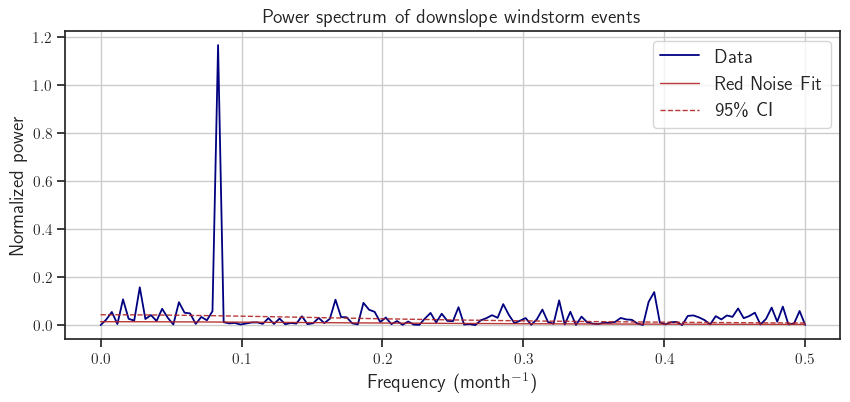

In [370]:
## Not normalized
alpha_level = 0.95 ## set statistical significance level

f,Pxx = signal.periodogram(data,fs=1.,window='boxcar',nfft=None,return_onesided=True,scaling='spectrum')
# Pxx_n = Pxx/np.sum(Pxx)

fig = plt.figure(figsize=(10,4))
plt.plot(f,Pxx, color='navy', lw=1.3, label='Data')
plt.plot(freq,red_fit_n, color='firebrick', lw=1, alpha=0.9, label='Red Noise Fit')
plt.plot(freq,f_bounds, color='firebrick', lw=1, ls='--', alpha=0.9, label=str(int(alpha_level*100))+'\% CI')
# plt.ylim(0.0,0.3)
# plt.xlim(0.0,0.06)
plt.xlabel("Frequency (month$^{-1}$)",fontsize=14)
plt.ylabel("Normalized power",fontsize=14)
plt.title("Power spectrum of downslope windstorm events",fontsize=14)
plt.legend(loc='upper right',fontsize=14)
plt.grid()
# plt.savefig('spectral_analysis_nn.pdf',bbox_inches='tight')

In [360]:
# Find the significant spectral peaks
for i in range(len(Pxx_n)):
    if (Pxx_n[i] - f[i]) > 1e-02:
        print('\nFound a spectral peak that exceeds red noise:')
        print('exceeds by...',np.round(Pxx_n[i]-f[i],5))
        print('at frequency....',np.round(f[i],5))
        print('which in years is...',np.round((1.0/(f[i]))/1.0,2))


Found a spectral peak that exceeds red noise:
exceeds by... 0.03797
at frequency.... 0.09524
which in years is... 10.5


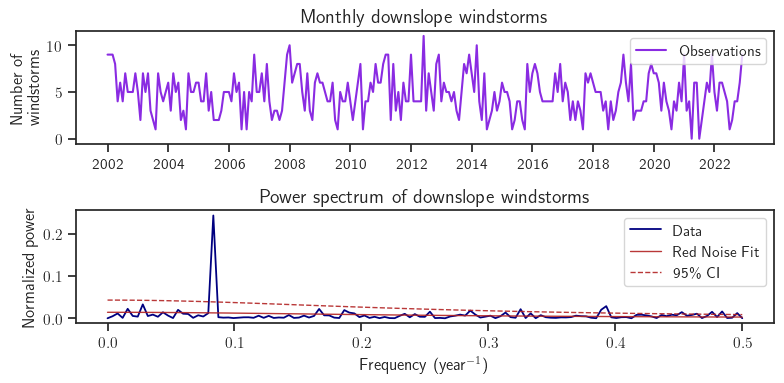

In [371]:
fig, ax = plt.subplots(2, sharex=False, sharey=False, figsize=(8,4))

ax[0].plot(yearly_monthly_storms, color='blueviolet', label='Observations')

ax[0].set_xticks(ticks = np.arange(0,253,24), labels=np.arange(2002,2023,2))
ax[0].set_ylabel("Number of\nwindstorms",fontsize=12)
ax[0].tick_params(axis="y")
ax[0].set_title("Monthly downslope windstorms",fontsize=14)
ax[0].legend(loc='upper right')

ax[1].plot(f,Pxx_n, color='navy', lw=1.3, label='Data')
ax[1].plot(freq,red_fit_n, color='firebrick', lw=1, alpha=0.9, label='Red Noise Fit')
ax[1].plot(freq,f_bounds, color='firebrick', lw=1, ls='--', alpha=0.9, label=str(int(alpha_level*100))+'\% CI')
# plt.ylim(0.0,0.3)
# plt.xlim(0.0,0.06)
ax[1].set_xlabel("Frequency (year$^{-1}$)",fontsize=12)
ax[1].set_ylabel(f"Normalized power",fontsize=12)
ax[1].set_title("Power spectrum of downslope windstorms",fontsize=14)
ax[1].legend(loc='upper right')
# plt.grid()
fig.tight_layout()
# fig.suptitle("Deseasonalized trends: windstorms vs time over threshold")
# fig.savefig('windstorm_FFT.pdf',bbox_inches='tight')

#### For windstorm hours

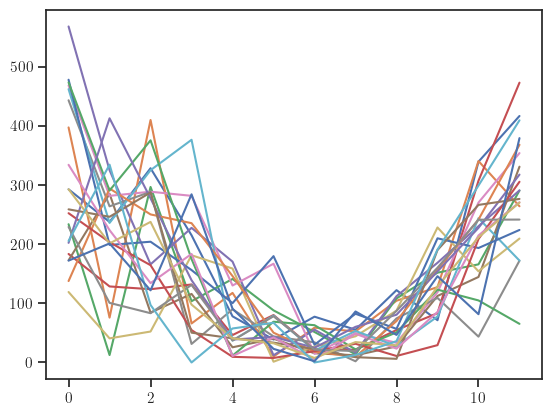

In [372]:
plt.plot(windstorm_hours_by_month)
plt.show()

In [373]:
df_d2['Windstorm hours']

0      292.650000
1      237.533333
2      328.283333
3      215.033333
4       78.016667
          ...    
247     86.183333
248     46.600000
249    145.850000
250     81.600000
251    379.200000
Name: Windstorm hours, Length: 252, dtype: float64

In [374]:
## Calculate the power spectrum of red noise with lag1_r to use for significance testing
alpha = 0.95 ## set statistical significance level
data = yearly_monthly_storm_hours
var_str = "Windstorm hours"

### step 1: calculate lag-1 autocorrelation (lag1_r, rho) and the associated p value (lag1_p)
lag1_r,lag1_p = stats.pearsonr(data[0:len(data)-1],data[1:len(data)])

### step 2: Calculate e-folding time for a red-noise process with this lag-1 autocorrelation
Te = -1./np.log(lag1_r) # After Hartman 6.62 with delta t = 1
print(var_str,'lag-1 autocorrelation =',round(lag1_r,2),'and Te =',round(Te,0))

## calculate the power spectrum of red noise with lag1_r to use for significance testing
red_fit_n = create_normalized_redfit(len(data),Te)
dof_entirewindow=2 ### note dof=2 because using whole record for FFT with no chunking
f_bounds = create_f_bounds(alpha,dof_entirewindow,red_fit_n)  ## using f-test for variance, see function

## multiple DOF by 1.2 to account for extra smoothing Hanning (Barnes Ch. 4 Eq. 59)
f_bounds_hanning = create_f_bounds(alpha,dof_entirewindow*1.2,red_fit_n)  

## Method #1: Numpy Method - Calculate Power Spectrum
freq = np.fft.rfftfreq(len(data),d=1.)  ### 
#print(freq)
A = np.fft.rfft(data) ### r = real
ps = (np.abs(A)**2)/2.
ps_n = (np.abs(A)**2)/np.sum(np.abs(A)**2)  ## normalizing - calculate percent of the total  

Windstorm hours lag-1 autocorrelation = 0.58 and Te = 2.0


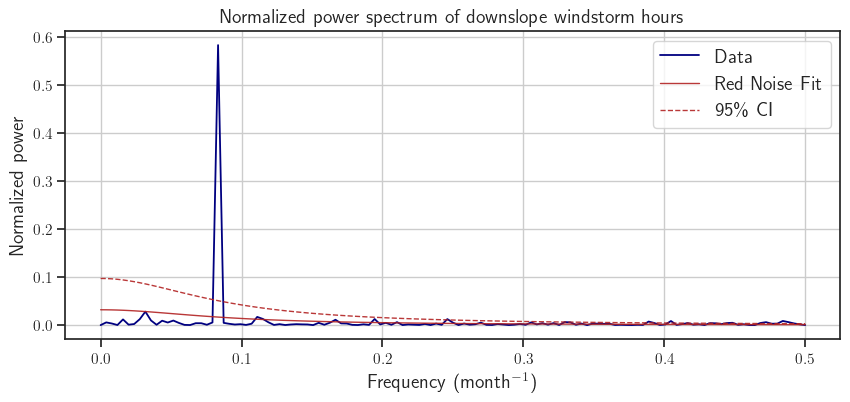

In [375]:
## Use Boxcar Window
alpha_level = 0.95 ## set statistical significance level

f,Pxx = signal.periodogram(data,fs=1.,window='boxcar',nfft=None,return_onesided=True,scaling='spectrum')
Pxx_n = Pxx/np.sum(Pxx)

fig = plt.figure(figsize=(10,4))
plt.plot(f,Pxx_n, color='navy', lw=1.3, label='Data')
plt.plot(freq,red_fit_n, color='firebrick', lw=1, alpha=0.9, label='Red Noise Fit')
plt.plot(freq,f_bounds, color='firebrick', lw=1, ls='--', alpha=0.9, label=str(int(alpha_level*100))+'\% CI')
# plt.ylim(0.0,0.3)
# plt.xlim(0.0,0.06)
plt.xlabel("Frequency (month$^{-1}$)",fontsize=14)
plt.ylabel("Normalized power",fontsize=14)
plt.title("Normalized power spectrum of downslope windstorm hours",fontsize=14)
plt.legend(loc='upper right',fontsize=14)
plt.grid()
# plt.savefig('spectral_analysis.pdf',bbox_inches='tight')
# power over total power, almost 60% of total variance explained

In [376]:
np.max(Pxx_n)

0.5834860744526777

In [377]:
# Find the significant spectral peaks
for i in range(len(Pxx_n)):
    if (Pxx_n[i] - f[i]) > 1e-02:
        print('\nFound a spectral peak that exceeds red noise:')
        print('exceeds by...',np.round(Pxx_n[i]-f[i],5))
        print('at frequency....',np.round(f[i],5))
        print('which in months is...',np.round((1.0/(f[i]))/1.0,2))


Found a spectral peak that exceeds red noise:
exceeds by... 0.50015
at frequency.... 0.08333
which in months is... 12.0


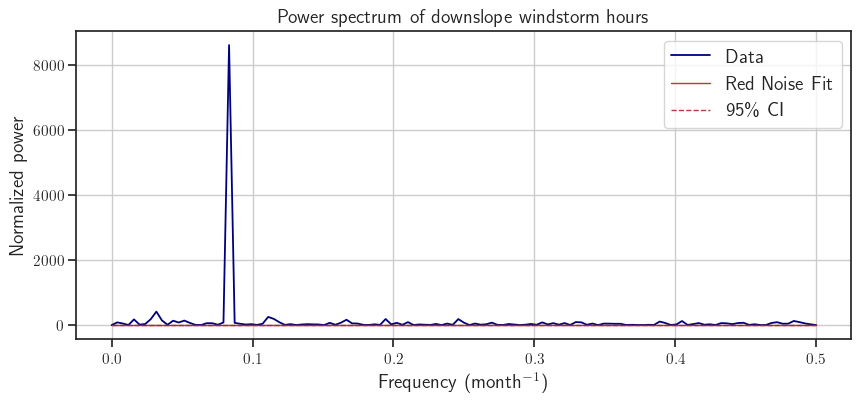

In [378]:
## Not normalized
alpha_level = 0.95 ## set statistical significance level

f,Pxx = signal.periodogram(data,fs=1.,window='boxcar',nfft=None,return_onesided=True,scaling='spectrum')
# Pxx_n = Pxx/np.sum(Pxx)

fig = plt.figure(figsize=(10,4))
plt.plot(f,Pxx, color='navy', lw=1.3, label='Data')
plt.plot(freq,red_fit_n, color='firebrick', lw=1, alpha=0.9, label='Red Noise Fit')
plt.plot(freq,f_bounds, color='firebrick', lw=1, ls='--', alpha=0.9, label=str(int(alpha_level*100))+'\% CI')
# plt.ylim(0.0,0.3)
# plt.xlim(0.0,0.06)
plt.xlabel("Frequency (month$^{-1}$)",fontsize=14)
plt.ylabel("Normalized power",fontsize=14)
plt.title("Power spectrum of downslope windstorm hours",fontsize=14)
plt.legend(loc='upper right',fontsize=14)
plt.grid()
# plt.savefig('spectral_analysis_nn.pdf',bbox_inches='tight')

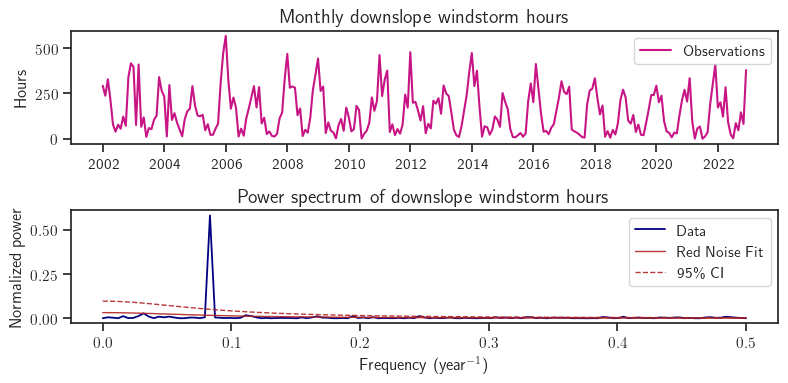

In [379]:
fig, ax = plt.subplots(2, sharex=False, sharey=False, figsize=(8,4))

ax[0].plot(yearly_monthly_storm_hours, color='mediumvioletred', label='Observations')

ax[0].set_xticks(ticks = np.arange(0,253,24), labels=np.arange(2002,2023,2))
ax[0].set_ylabel("Hours",fontsize=12)
ax[0].tick_params(axis="y")
ax[0].set_title("Monthly downslope windstorm hours",fontsize=14)
ax[0].legend(loc='upper right')

ax[1].plot(f,Pxx_n, color='navy', lw=1.3, label='Data')
ax[1].plot(freq,red_fit_n, color='firebrick', lw=1, alpha=0.9, label='Red Noise Fit')
ax[1].plot(freq,f_bounds, color='firebrick', lw=1, ls='--', alpha=0.9, label=str(int(alpha_level*100))+'\% CI')
# plt.ylim(0.0,0.3)
# plt.xlim(0.0,0.06)
ax[1].set_xlabel("Frequency (year$^{-1}$)",fontsize=12)
ax[1].set_ylabel(f"Normalized power",fontsize=12)
ax[1].set_title("Power spectrum of downslope windstorm hours",fontsize=14)
ax[1].legend(loc='upper right')
# plt.grid()
fig.tight_layout()
# fig.suptitle("Deseasonalized trends: windstorms vs time over threshold")
fig.savefig('windstorm_hours_FFT.pdf',bbox_inches='tight')

### Deseasonalizing

In [380]:
storms_df[['Windstorms']]

Windstorms
0             9
1             9
2             9
3             8
4             4
..          ...
247           2
248           4
249           4
250           6
251           9

[252 rows x 1 columns]

In [381]:
analysis = df_d2[['Windstorms']].copy()

s_dec_additive = seasonal_decompose(analysis, model = "additive", period=12, extrapolate_trend='freq')

observed_sd = s_dec_additive.observed
trend_sd = s_dec_additive.trend
seasonal_sd = s_dec_additive.seasonal
residual_sd = s_dec_additive.resid

decomposed_df_ws = pd.DataFrame({"Observed":observed_sd, "Trend":trend_sd, "Seasonal":seasonal_sd, "Residual":residual_sd})
decomposed_df_ws

Observed     Trend  Seasonal  Residual
0         9.0  6.863248  1.525847  0.610905
1         9.0  6.714209  0.310722  1.975068
2         9.0  6.565171  1.044010  1.390819
3         8.0  6.416132  0.436028  1.147840
4         4.0  6.267094 -0.414018 -1.853076
..        ...       ...       ...       ...
247       2.0  4.828429 -1.704637 -1.123791
248       4.0  4.865433 -0.926638  0.061204
249       4.0  4.902438 -0.394670 -0.507768
250       6.0  4.939443  0.986505  0.074053
251       9.0  4.976447  1.748632  2.274921

[252 rows x 4 columns]

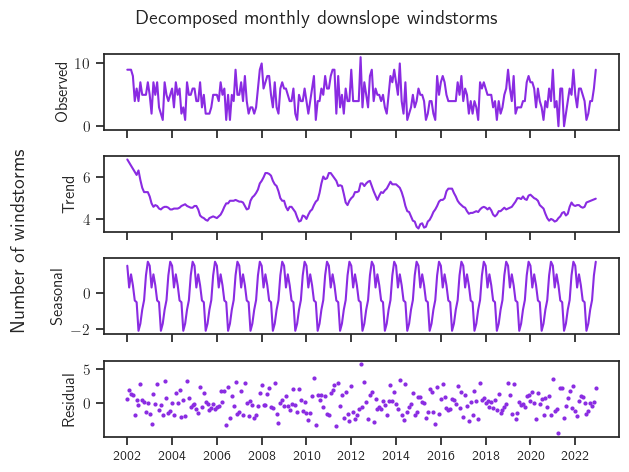

In [382]:
fig, ax = plt.subplots(4, 
           sharex='col', sharey='row')

ax[0].plot(decomposed_df_ws['Observed'], color='blueviolet')
ax[0].set(ylabel='Observed')

ax[1].plot(decomposed_df_ws['Trend'], color='blueviolet')
ax[1].set(ylabel='Trend')

ax[2].plot(decomposed_df_ws['Seasonal'], color='blueviolet')
ax[2].set(ylabel='Seasonal')
# ax[2].set_ylim([-2.5, 3])

ax[3].plot(decomposed_df_ws['Residual'], 'o', markersize=2, color='blueviolet')
ax[3].set(ylabel='Residual')
ax[3].set_xticks(np.arange(0,252,24))
ax[3].set_xticklabels(np.arange(2002,2023,2), fontsize=10)

fig.supylabel("Number of windstorms")
fig.suptitle("Decomposed monthly downslope windstorms")
fig.tight_layout()
plt.show()

fig.savefig("decomposed_windstorms.pdf",bbox_inches="tight")

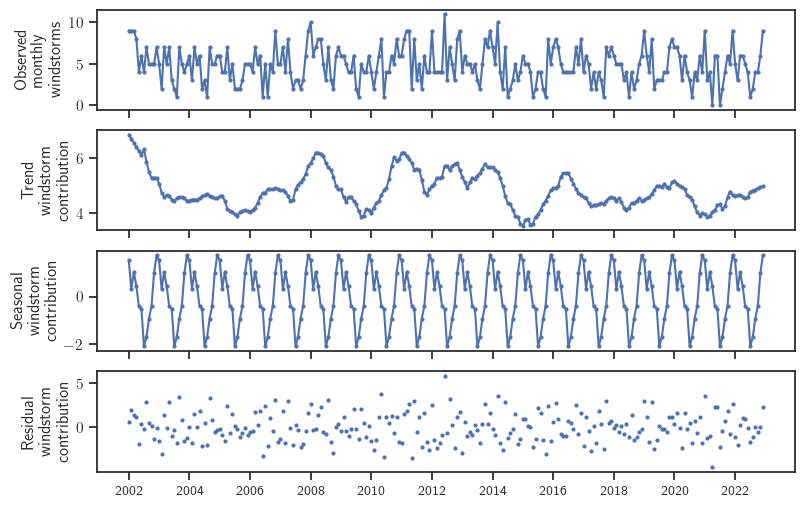

In [384]:
fig, ax = plt.subplots(4, 
           sharex='col', sharey='row', figsize=(9,6))

ax[0].plot(decomposed_df_ws['Observed'],'o-',markersize=2)
ax[0].set(ylabel='Observed\n monthly\nwindstorms')

ax[1].plot(decomposed_df_ws['Trend'],'o-',markersize=2)
ax[1].set(ylabel='Trend\nwindstorm\ncontribution')

ax[2].plot(decomposed_df_ws['Seasonal'],'o-',markersize=2)
ax[2].set(ylabel='Seasonal\nwindstorm\ncontribution')
# ax[2].set_ylim([-2.5, 3])

ax[3].plot(decomposed_df_ws['Residual'], 'o', markersize=2)
ax[3].set(ylabel='Residual\nwindstorm\ncontribution')
ax[3].set_xticks(np.arange(0,252,24))
ax[3].set_xticklabels(np.arange(2002,2023,2), fontsize=10)

plt.show()

fig.savefig("detrended.pdf",bbox_inches="tight")

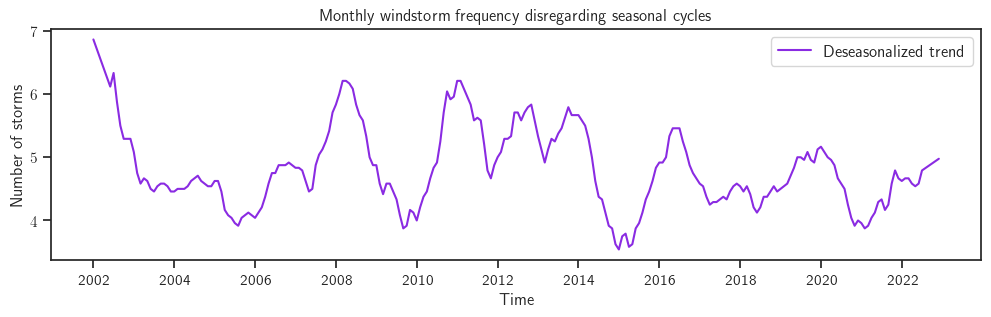

In [385]:
windstorm_trend = trend_sd
y = windstorm_trend
x = np.arange(len(y))
mod = sm.GLS(y, sm.add_constant(x))
result = mod.fit()

plt.figure(figsize=(12,3))
plt.plot(windstorm_trend, color='blueviolet', label='Deseasonalized trend')

trend = np.polyfit(x=np.arange(0,252,1) , y=windstorm_trend, deg=1)
trendpoly = np.poly1d(trend) 

# plt.plot(np.arange(0,252,1),trendpoly(np.arange(0,252,1)), color='teal',label=f'First order fit: $m={np.round(trend[0],3)}, p={np.round(result.pvalues[1],7)}$')
plt.xlabel(f"Time")
plt.ylabel("Number of storms")
plt.xticks(np.arange(0,252,24),np.arange(2002,2023,2))
plt.legend(loc="best",prop={'size': 12}) 
plt.title(f"Monthly windstorm frequency disregarding seasonal cycles")
# plt.savefig(f'full_des_windstorms.pdf',bbox_inches='tight')
plt.show()

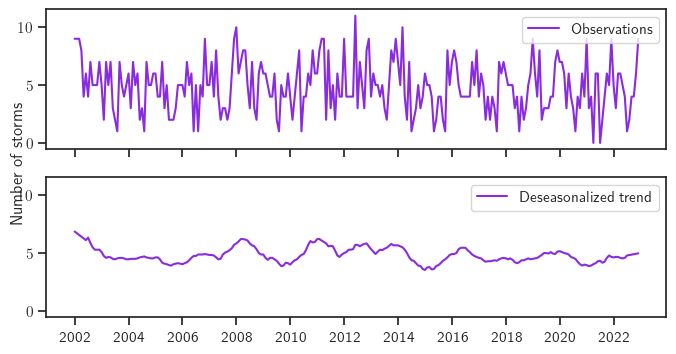

In [386]:
fig, ax = plt.subplots(2, sharex=True, sharey=True, figsize=(8,4))

ax[0].plot(yearly_monthly_storms, color='blueviolet', label='Observations')
ax[1].plot(windstorm_trend, color='blueviolet', label='Deseasonalized trend')

ax[0].set_xticks(ticks = np.arange(0,253,24), labels=np.arange(2002,2023,2))
# ax[0].set_ylabel("Number of storms")
ax[0].tick_params(axis="y")
ax[0].legend(loc='upper right')

ax[1].set_ylabel("Number of storms")
ax[1].yaxis.set_label_coords(-0.035, 1.1)
ax[1].tick_params(axis="y")
ax[1].legend(loc='upper right')
# fig.supylabel('Number of storms')

# fig.suptitle("Deseasonalized trends: windstorms vs time over threshold")
# fig.savefig('full_monthly_comparison.pdf')

Text(0.5, 1.0, 'Monthly windstorm frequency')

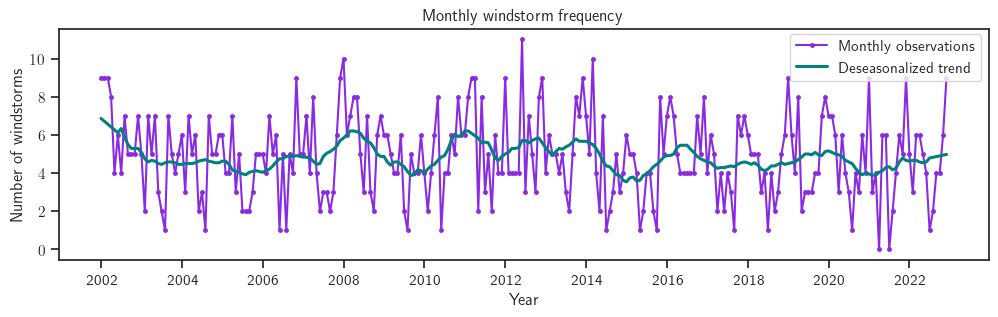

In [387]:
fig, ax1 = plt.subplots(figsize=(12,3))

ax1.plot(yearly_monthly_storms, 'o-', markersize=2.5, color='blueviolet', label='Monthly observations')
ax1.plot(windstorm_trend, color='teal', linewidth=2.2, label='Deseasonalized trend')

ax1.set_xlabel("Year")
ax1.set_xticks(ticks = np.arange(0,253,24), labels=np.arange(2002,2023,2))
ax1.set_ylabel("Number of windstorms")
ax1.tick_params(axis="y")

fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.89))

# ax1.set_title("Windstorms with deseasonalized trend")
ax1.set_title("Monthly windstorm frequency")
# fig.savefig('deseas_smoothed.pdf',bbox_inches="tight")

In [388]:
scipy.stats.spearmanr(full_months, windstorm_trend) 

SignificanceResult(statistic=-0.18197162084245144, pvalue=0.0037484717348953756)

#### Windstorm hours

In [389]:
df_d2[['Windstorm hours']]

Windstorm hours
0         292.650000
1         237.533333
2         328.283333
3         215.033333
4          78.016667
..               ...
247        86.183333
248        46.600000
249       145.850000
250        81.600000
251       379.200000

[252 rows x 1 columns]

In [390]:
analysis = df_d2[['Windstorm hours']].copy()

s_dec_additive = seasonal_decompose(analysis, model = "additive", period=12, extrapolate_trend='freq')

observed_sd = s_dec_additive.observed
trend_sd = s_dec_additive.trend
seasonal_sd = s_dec_additive.seasonal
residual_sd = s_dec_additive.resid

decomposed_df_wsh = pd.DataFrame({"Observed":observed_sd, "Trend":trend_sd, "Seasonal":seasonal_sd, "Residual":residual_sd})
decomposed_df_wsh

Observed       Trend    Seasonal    Residual
0    292.650000  198.932488  153.662671  -59.945158
1    237.533333  197.505458   68.936345  -28.908470
2    328.283333  196.078428   69.229696   62.975210
3    215.033333  194.651398    4.617590   15.764345
4     78.016667  193.224368  -73.945078  -41.262624
..          ...         ...         ...         ...
247   86.183333  166.454025 -114.097482   33.826790
248   46.600000  168.664187  -89.294196  -32.769991
249  145.850000  170.874348  -14.222590  -10.801759
250   81.600000  173.084510   66.807680 -158.292190
251  379.200000  175.294672  141.532031   62.373297

[252 rows x 4 columns]

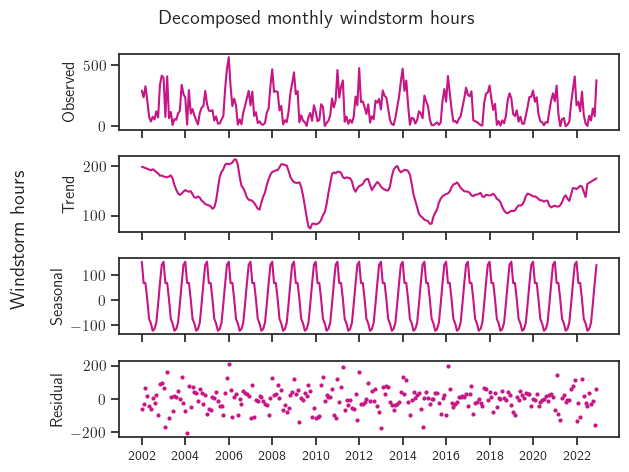

In [391]:
fig, ax = plt.subplots(4, 
           sharex='col', sharey='row')

ax[0].plot(decomposed_df_wsh['Observed'], color='mediumvioletred')
ax[0].set(ylabel='Observed')

ax[1].plot(decomposed_df_wsh['Trend'], color='mediumvioletred')
ax[1].set(ylabel='Trend')

ax[2].plot(decomposed_df_wsh['Seasonal'], color='mediumvioletred')
ax[2].set(ylabel='Seasonal')
# ax[2].set_ylim([-2.5, 3])

ax[3].plot(decomposed_df_wsh['Residual'], 'o', markersize=2, color='mediumvioletred')
ax[3].set(ylabel='Residual')
ax[3].set_xticks(np.arange(0,252,24))
ax[3].set_xticklabels(np.arange(2002,2023,2), fontsize=10)
fig.supylabel("Windstorm hours")
fig.suptitle("Decomposed monthly windstorm hours")
fig.tight_layout()

plt.show()

fig.savefig("decomposed_windstorm_hours.pdf",bbox_inches="tight")

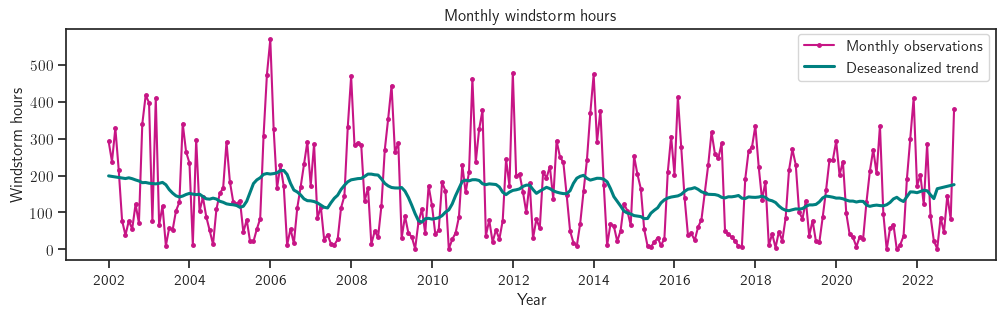

In [392]:
fig, ax1 = plt.subplots(figsize=(12,3))

ax1.plot(yearly_monthly_storm_hours, 'o-', markersize=2.5, color='mediumvioletred', label='Monthly observations')
ax1.plot(decomposed_df_wsh['Trend'], color='teal', linewidth=2.2, label='Deseasonalized trend')

ax1.set_xlabel("Year")
ax1.set_xticks(ticks = np.arange(0,253,24), labels=np.arange(2002,2023,2))
ax1.set_ylabel("Windstorm hours")
ax1.tick_params(axis="y")

fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.89))

# ax1.set_title("Windstorms with deseasonalized trend")
ax1.set_title("Monthly windstorm hours")
fig.savefig('deseas_smoothed_wsh.pdf',bbox_inches="tight")

# Time over threshold

### Yearly

In [393]:
height='10m'
yearly_minutes_over_threshold = np.zeros(len(years))
yearly_hours_over_threshold = np.zeros(len(years))
subset = ['Year', 'DOY', 'MST', f'Avg Wind Speed @ {height} [m/s]', f'Avg Wind Direction @ {height} [deg]']

for i in np.arange(2002,2023,1): 
    year = i

    df = pd.read_csv(f'/Users/serena/Documents/Research/Data/{year}_data.csv', usecols=lambda x: x in subset)
    df.insert(2, 'Date', df['DOY'].apply(doy_to_date, args=(year,))) 
    df = df.replace(-99999.0, np.nan)
    df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y') # convert date column to DateTime
    df.set_index('Date')

    yearly_minutes_over_threshold[int(year)-2002] = count_over_thresholds(df['Avg Wind Speed @ 10m [m/s]'], 4.5, df['Avg Wind Direction @ 10m [deg]'], [240, 330])
    yearly_hours_over_threshold[int(year)-2002] = yearly_minutes_over_threshold[int(year)-2002]/60
    
    print(f"Hours over threshold in {year}: {yearly_hours_over_threshold[int(year)-2002]}")

Hours over threshold in 2002: 1464.0
Hours over threshold in 2003: 1495.8
Hours over threshold in 2004: 1338.3166666666666
Hours over threshold in 2005: 1403.6333333333334
Hours over threshold in 2006: 1771.4666666666667
Hours over threshold in 2007: 1249.6833333333334
Hours over threshold in 2008: 1752.45
Hours over threshold in 2009: 1400.15
Hours over threshold in 2010: 1071.3166666666666
Hours over threshold in 2011: 1635.6833333333334
Hours over threshold in 2012: 1558.8166666666666
Hours over threshold in 2013: 1528.0666666666666
Hours over threshold in 2014: 1504.85
Hours over threshold in 2015: 1148.05
Hours over threshold in 2016: 1401.55
Hours over threshold in 2017: 1160.4333333333334
Hours over threshold in 2018: 1147.8666666666666
Hours over threshold in 2019: 1141.75
Hours over threshold in 2020: 1338.6833333333334
Hours over threshold in 2021: 1252.4
Hours over threshold in 2022: 1339.1


y = -14.10x + 29758.11
                            GLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.193
Model:                            GLS   Adj. R-squared:                  0.150
Method:                 Least Squares   F-statistic:                     4.537
Date:                Sat, 28 Oct 2023   Prob (F-statistic):             0.0465
Time:                        11:05:50   Log-Likelihood:                -138.23
No. Observations:                  21   AIC:                             280.5
Df Residuals:                      19   BIC:                             282.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.976e+04   1.33e

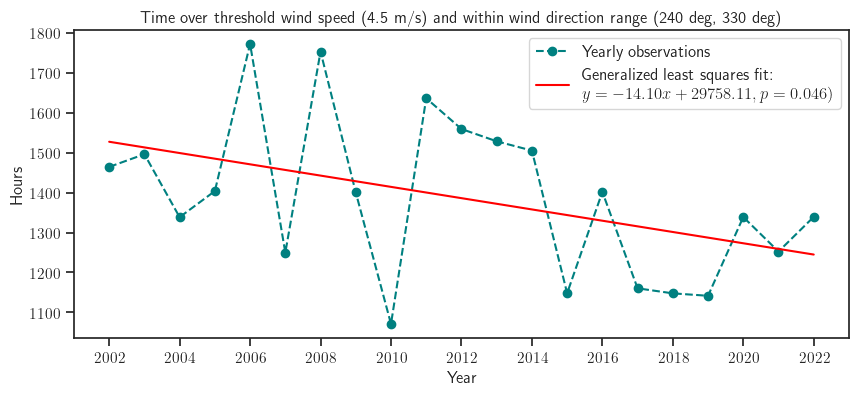

In [394]:
# Fit the Generalized Least Squares Regression model
y = yearly_hours_over_threshold
x = years
model = sm.GLS(y, sm.add_constant(x))
gls_result = model.fit()

# Extract the model parameters
gls_params = gls_result.params

# Print the model equation
gls_equation = "y = {:.2f}x + {:.2f}".format(gls_params[1], gls_params[0])
print(gls_equation)

# Print the summary of the model
print(gls_result.summary())

plt.figure(figsize=(10,4))
plt.plot(years, yearly_hours_over_threshold,'o--', color='teal', label='Yearly observations')

trendpoly = gls_params[1]*x + gls_params[0]

plt.plot(years,trendpoly, color='red',label=f'Generalized least squares fit: \n${gls_equation}, p={np.round(gls_result.pvalues[1],3)})$')
plt.xlabel(f"Year")
plt.ylabel("Hours")
plt.xticks(years[::2])
plt.legend(loc="best",prop={'size': 12}) 
plt.title(f"Time over threshold wind speed (4.5 m/s) and within wind direction range (240 deg, 330 deg)")
plt.savefig('toth_annual.pdf',bbox_inches='tight')
plt.show()

# e.g. r-squared of 0.20 indicates that 20% of the variability observed in the target variable is explained by the regression model

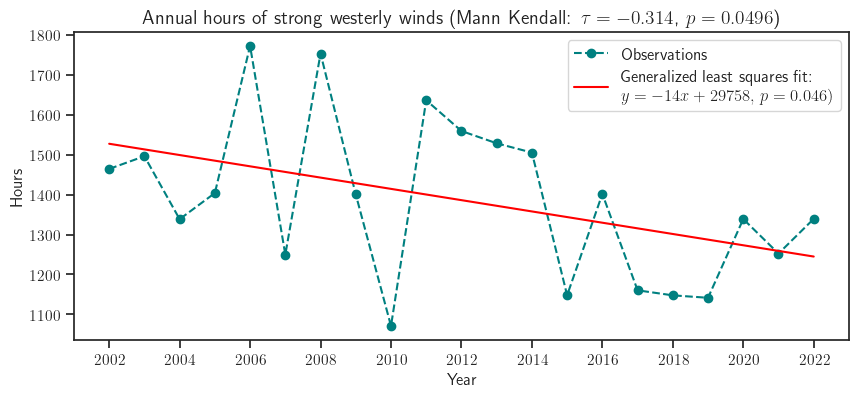

In [395]:
plt.figure(figsize=(10,4))
sns.set_style("ticks")
plt.plot(years, yearly_hours_over_threshold,'o--', color='teal', label='Observations')

trendpoly2 = gls_params[0]+x*gls_params[1]

# plt.plot(years,trendpoly,'-',color='orange',label=f'Negative binomial model fit: \n$y = exp({np.round(nb_params[1],3)}x +{np.round(nb_params[0],3)})$')
# plt.plot(years,trendpoly2,'-',color='red',label=f'Generalized least squares fit: \n$y = {np.round(gls_params[1],1)}x +{np.round(gls_params[0],1)}, p={np.round(gls_result.pvalues[1],3)})$')
plt.plot(years,trendpoly2,'-',color='red',label=f'Generalized least squares fit: \n$y = -14x + 29758, \, p={np.round(gls_result.pvalues[1],3)})$')
plt.xlabel(f"Year",fontsize=12)
plt.ylabel("Hours",fontsize=12)
plt.xticks(years[::2])
plt.legend(loc="best",prop={'size': 12}) 
plt.title(r"Annual hours of strong westerly winds (Mann Kendall: $\tau=-0.314$, $p=0.0496$)",fontsize=14)
plt.savefig('toth_annual_v2.pdf',bbox_inches='tight')
plt.show()

In [396]:
# after an update the MK test doesn't run currently - try again when resolved
mk_result = "Mann_Kendall_Test(trend='decreasing', h=True, p=0.049669425323142224, z=-1.9627999354560155, Tau=-0.3142857142857143, s=-66.0, var_s=1096.6666666666667, slope=-13.720924908186815, intercept=1533.8259157518683)"
print(mk_result)

Mann_Kendall_Test(trend='decreasing', h=True, p=0.049669425323142224, z=-1.9627999354560155, Tau=-0.3142857142857143, s=-66.0, var_s=1096.6666666666667, slope=-13.720924908186815, intercept=1533.8259157518683)


In [397]:
# yearly_hours_over_threshold # max: 365*24 = 8,760
windstorm_hours

array([2335.18333333, 2059.8       , 1675.73333333, 1622.16666667,
       2334.48333333, 1362.1       , 2451.26666667, 1604.73333333,
       1325.03333333, 2100.43333333, 2110.18333333, 2065.7       ,
       1824.08333333, 1283.88333333, 1965.76666667, 1674.93333333,
       1645.1       , 1430.71666667, 1564.18333333, 1709.93333333,
       1634.91666667])

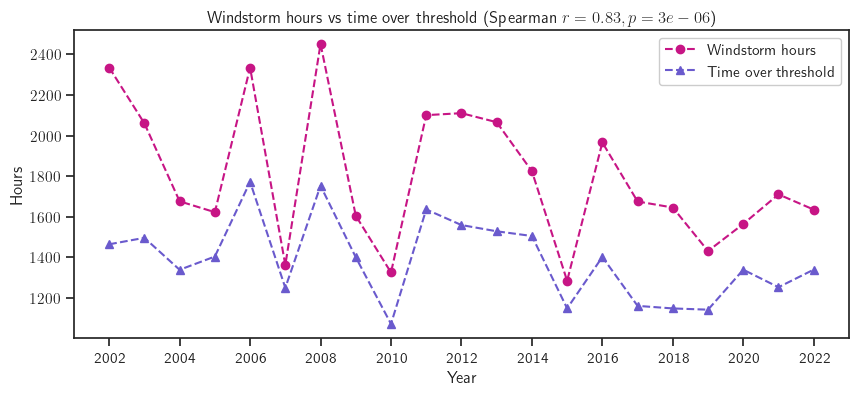

In [398]:
spearman = scipy.stats.spearmanr(yearly_hours_over_threshold, windstorm_hours) 
sns.set_style("ticks")

plt.figure(figsize=(10,4))

plt.plot(windstorm_hours,'o--', color='mediumvioletred', label='Windstorm hours')
plt.plot(yearly_hours_over_threshold,'^--', color='slateblue', label='Time over threshold')

plt.xlabel("Year")
plt.ylabel("Hours")
plt.xticks(ticks=np.arange(0,21,2),labels=years[::2])
plt.legend(prop={'size': 11},loc='upper right',fancybox=True, framealpha=1) 
plt.title(f"Windstorm hours vs time over threshold (Spearman $r={np.round(spearman[0],2)}, p={np.round(spearman[1],6)}$)")
# plt.savefig(f'MFA_figures/windstorm_durations.pdf',bbox_inches='tight')
plt.show()

In [400]:
y = windstorms_1min
model = sm.GLS(y, sm.add_constant(x))
gls_result = model.fit()
gls_params = gls_result.params

y = windstorms_1min
model = sm.GLM(y, sm.add_constant(x), family=sm.families.Poisson())
pois_result = model.fit()
poisson_params = pois_result.params

trendpoly = gls_params[0]+x*gls_params[1]
trendpoly2 = np.exp(poisson_params[1]*x+poisson_params[0])

windstorm_residuals = windstorms_1min-trendpoly #gls
windstorm_residuals2 = windstorms_1min-trendpoly2 #poisson

In [401]:
y = yearly_hours_over_threshold
model = sm.GLS(y, sm.add_constant(x))
gls_result = model.fit()
gls_params = gls_result.params

trendpoly = gls_params[0]+x*gls_params[1]

toth_residuals_gls = yearly_hours_over_threshold-trendpoly #gls

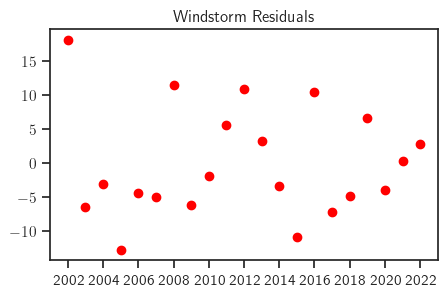

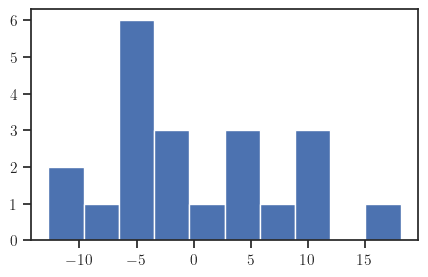

ShapiroResult(statistic=0.9477444291114807, pvalue=0.30857399106025696)

In [402]:
plt.figure(figsize=(5,3))
plt.plot(windstorm_residuals, 'o',color='red')
plt.xticks(np.arange(0,22,2),years[::2])
plt.title(f"Windstorm Residuals")
plt.show()
plt.figure(figsize=(5,3))
plt.hist(windstorm_residuals)
plt.show()

# conduct the  Shapiro-Wilk Test
shapiro(windstorm_residuals)

the p-value is 0.9477 which is more than the threshold (0.05) which is the alpha (0.05) so we fail to reject the null hypothesis i.e. we do not have sufficient evidence to say that sample does not come from a normal distribution

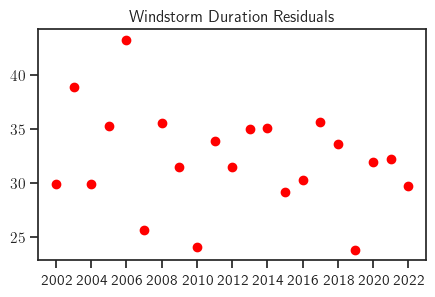

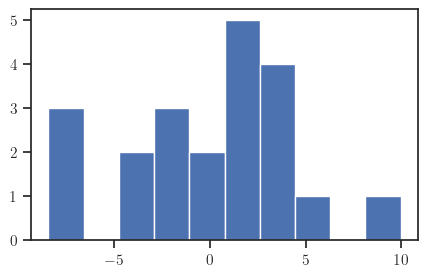

ShapiroResult(statistic=0.9660815596580505, pvalue=0.6457398533821106)

In [403]:
x = years
y = storm_durations_mean

gls_model = sm.GLS(y, sm.add_constant(x))
gls_result = gls_model.fit()
gls_params = gls_result.params
trendpoly = gls_params[0]+x*gls_params[1]
dur_residuals = storm_durations_mean-trendpoly #gls

plt.figure(figsize=(5,3))
sns.set_style("ticks")
plt.plot(years, storm_durations_mean,'o', color='red', label='Observations')
plt.xticks(np.arange(2002,2023,2),years[::2])
plt.title(f"Windstorm Duration Residuals")
plt.show()

plt.figure(figsize=(5,3))
plt.hist(dur_residuals)
plt.show()

# conduct the  Shapiro-Wilk Test on the residuals to test for normal distribution
shapiro(dur_residuals)

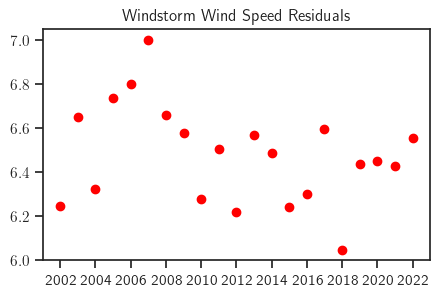

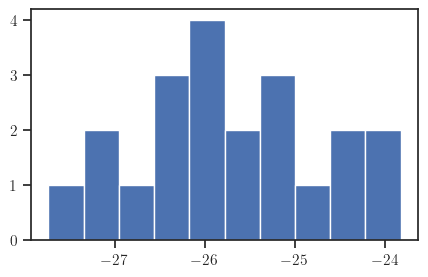

ShapiroResult(statistic=0.9808842539787292, pvalue=0.9373815655708313)

In [404]:
x = years
y = storm_speeds_mean

gls_model = sm.GLS(y, sm.add_constant(x))
gls_result = gls_model.fit()
gls_params = gls_result.params
spd_residuals = storm_speeds_mean-trendpoly #gls
trendpoly = gls_params[0]+x*gls_params[1]

plt.figure(figsize=(5,3))
sns.set_style("ticks")
plt.plot(years, storm_speeds_mean,'o', color='red', label='Observations')
plt.xticks(np.arange(2002,2023,2),years[::2])
plt.title(f"Windstorm Wind Speed Residuals")
plt.show()

plt.figure(figsize=(5,3))
plt.hist(spd_residuals)
plt.show()

# conduct the  Shapiro-Wilk Test on the residuals to test for normal distribution
shapiro(spd_residuals)

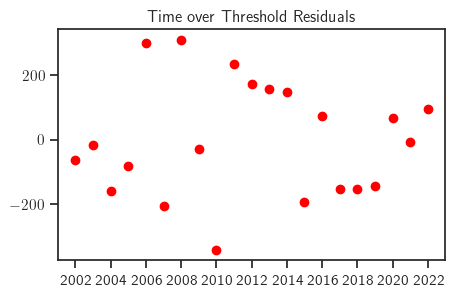

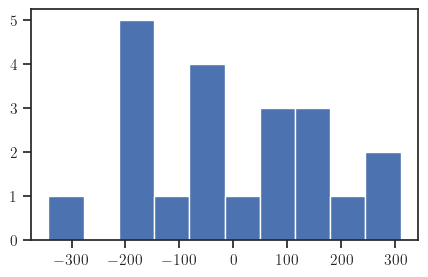

ShapiroResult(statistic=0.9688690900802612, pvalue=0.707885205745697)

In [405]:
plt.figure(figsize=(5,3))
plt.plot(toth_residuals_gls, 'o',color='red')
plt.xticks(np.arange(0,22,2),years[::2])
plt.title(f"Time over Threshold Residuals")
plt.show()

plt.figure(figsize=(5,3))
plt.hist(toth_residuals_gls)
plt.show()
shapiro(toth_residuals_gls) 

In [406]:
np.mean(yearly_monthly_storms)

4.849206349206349

In [407]:
np.std(yearly_monthly_storms)

2.1878722733295315

In [408]:
np.std(yearly_monthly_storms)/np.mean(yearly_monthly_storms)*1 # the standard deviation is __ as large as the mean

0.4511815162676285

In [413]:
scipy.stats.pearsonr(windstorms_1min, yearly_hours_over_threshold) 

PearsonRResult(statistic=0.4686507758841919, pvalue=0.032120113953730337)

In [414]:
scipy.stats.spearmanr(windstorms_1min, yearly_hours_over_threshold) 

SignificanceResult(statistic=0.4300593748347655, pvalue=0.05166757826594004)

In [ ]:
# storm_durations: Mann_Kendall_Test(trend='no trend', h=False, p=0.3811873049877583, z=-0.8757107404342224, Tau=-0.14285714285714285, s=-30.0, var_s=1096.6666666666667, slope=-0.23312530004166698, intercept=34.572632310416665)

In [ ]:
# storm_speeds: Mann_Kendall_Test(trend='no trend', h=False, p=0.6077081401081053, z=-0.5133476754269579, Tau=-0.08571428571428572, s=-18.0, var_s=1096.6666666666667, slope=-0.006193449761904771, intercept=6.570868757619048)

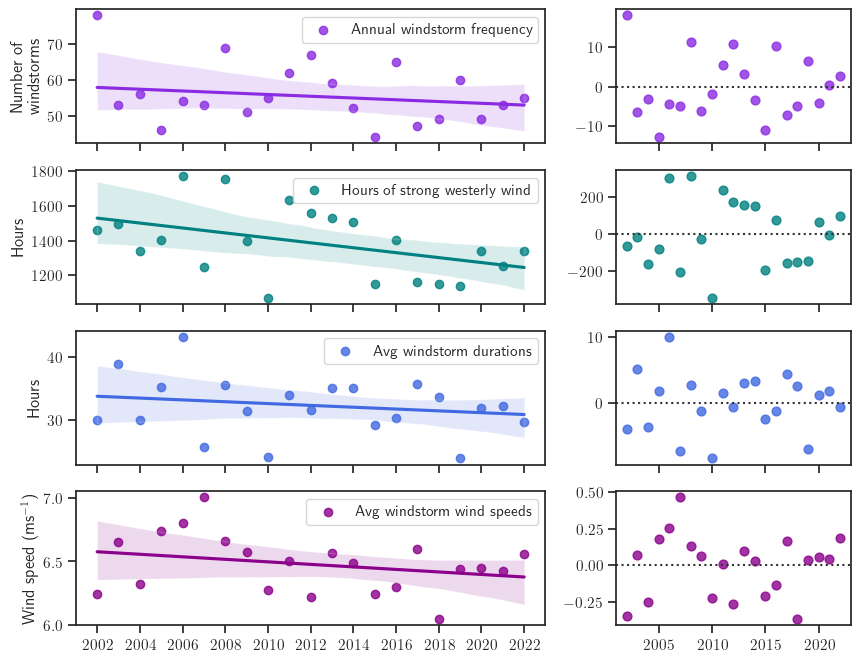

In [424]:
fig, ax = plt.subplots(4, 2, figsize=(10,8), sharex='col', gridspec_kw={'width_ratios': [2, 1]})

sns.regplot(x=years,y=windstorms_1min,n_boot=500,robust=True,x_ci=95,color='blueviolet',label='Annual windstorm frequency', ax=ax[0,0]) 
ax[0,0].set_xticks(years[::2])
ax[0,0].set_ylabel('Number of\nwindstorms')
ax[0,0].legend(loc='upper right')

sns.residplot(x=years, y=windstorms_1min, scatter_kws={"s": 40}, color='blueviolet', label='Residuals', ax=ax[0,1]);
# ax[0,1].legend(loc='upper right')

sns.regplot(x=years,y=yearly_hours_over_threshold,n_boot=500,robust=True,x_ci=95,color='teal',label='Hours of strong westerly wind', ax=ax[1,0]) 
ax[1,0].set_xticks(years[::2])
ax[1,0].set_ylabel('Hours')
ax[1,0].legend(loc='upper right')

sns.residplot(x=years, y=yearly_hours_over_threshold, scatter_kws={"s": 40}, color='teal', label='Residuals', ax=ax[1,1]);
# ax[1,1].legend(loc='upper right')

sns.regplot(x=years,y=storm_speeds_mean,n_boot=500,robust=True,x_ci=95,color='darkmagenta',label='Avg windstorm wind speeds', ax=ax[3,0]) 
ax[3,0].set_xticks(years[::2])
ax[3,0].set_ylabel(r'Wind speed (ms$^{-1}$)')
ax[3,0].legend(loc='upper right')

sns.residplot(x=years, y=storm_speeds_mean, scatter_kws={"s": 40}, color='darkmagenta',label='Residuals', ax=ax[3,1]);
# ax[3,1].legend(loc='upper right')

sns.regplot(x=years,y=storm_durations_mean,n_boot=500,robust=True,x_ci=95, color='royalblue', label='Avg windstorm durations', ax=ax[2,0]) 
ax[2,0].set_xticks(years[::2])
ax[2,0].set_ylabel('Hours')
ax[2,0].legend(loc='upper right')

sns.residplot(x=years, y=storm_durations_mean, scatter_kws={"s": 40}, color='royalblue', label='Residuals', ax=ax[2,1]);
# ax[2,1].legend(loc='upper right')

# for ax in axs.flat:
#     ax.set(xlabel='x-label', ylabel='y-label')

# # Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()
    
# fig.savefig('confidence_intervals_residuals3.pdf')

In [426]:
t_s, t_p = shapiro(toth_residuals_gls) 
s_s, s_p = shapiro(spd_residuals) 
d_s, d_p = shapiro(dur_residuals) 
w_s, w_p = shapiro(windstorm_residuals) 

Text(-25.15, 4.5, '$W=0.98$\n$p=0.94$')

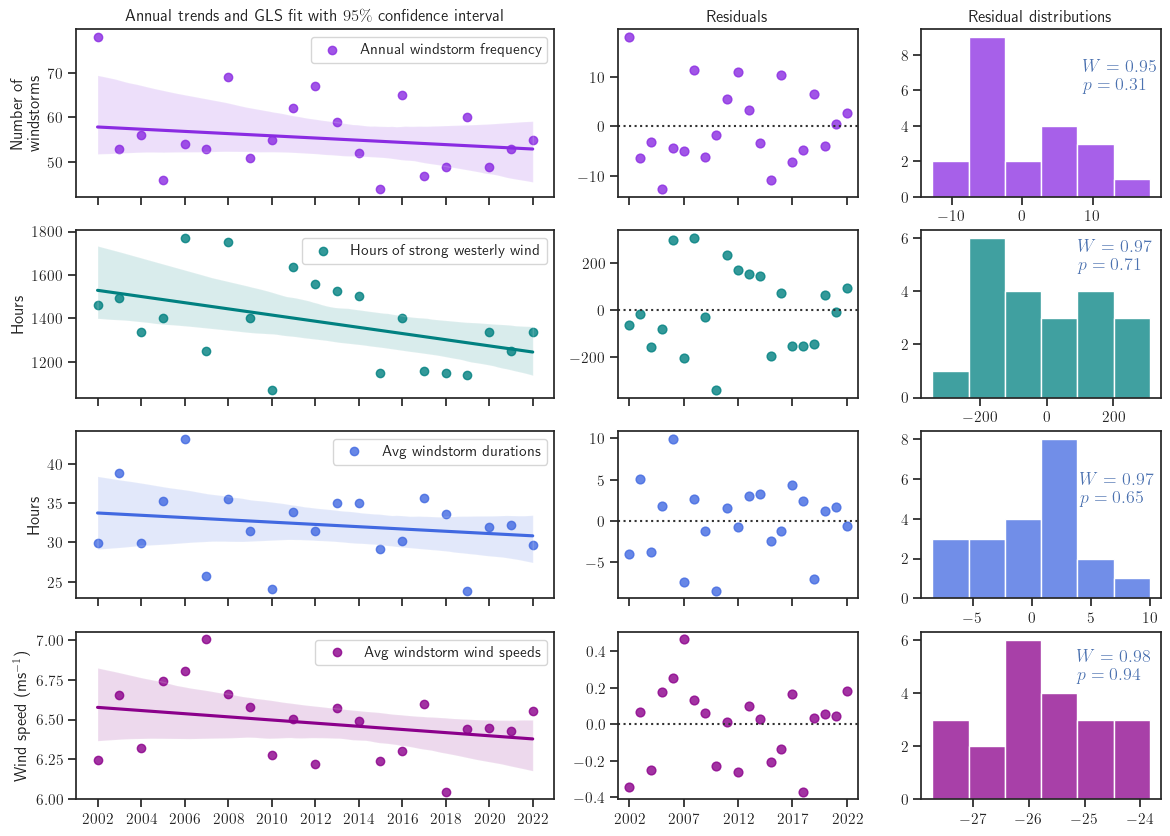

In [427]:
fig, ax = plt.subplots(4, 3, figsize=(14,10), gridspec_kw={'width_ratios': [2, 1, 1]})

sns.regplot(x=years,y=windstorms_1min,n_boot=500,robust=True,x_ci=95,color='blueviolet',label='Annual windstorm frequency', ax=ax[0,0]) 
ax[0,0].set_xticks(years[::2],[])
ax[0,0].set_ylabel('Number of\nwindstorms')
ax[0,0].legend(loc='upper right')
ax[0,0].set_title(r'Annual trends and GLS fit with $95\%$ confidence interval')
sns.residplot(x=years, y=windstorms_1min, scatter_kws={"s": 40}, color='blueviolet', label='Residuals', ax=ax[0,1]);
ax[0,1].set_xticks(years[::5],[])
ax[0,1].set_title('Residuals')
sns.histplot(windstorm_residuals, color='blueviolet', ax=ax[0,2]);
ax[0,2].set_ylabel('')
ax[0,2].set_title('Residual distributions')

eq = f"$W={np.round(w_s,2)}$\n$p={np.round(w_p,2)}$"
ax[0,2].text(8.5, 6, eq, {'color': 'C0', 'fontsize': 13})
# eq = r"$\begin{eqnarray*}W&={np.round(w_s,2)}\\ p&={np.round(w_p,2)}\end{eqnarray*}$"

sns.regplot(x=years,y=yearly_hours_over_threshold,n_boot=500,robust=True,x_ci=95,color='teal',label='Hours of strong westerly wind', ax=ax[1,0]) 
ax[1,0].set_xticks(years[::2],[])
ax[1,0].set_ylabel('Hours')
ax[1,0].legend(loc='upper right')
sns.residplot(x=years, y=yearly_hours_over_threshold, scatter_kws={"s": 40}, color='teal', label='Residuals', ax=ax[1,1]);
ax[1,1].set_xticks(years[::5],[])
sns.histplot(toth_residuals_gls, color='teal', ax=ax[1,2]);
ax[1,2].set_ylabel('')

eq2 = f"$W={np.round(t_s,2)}$\n$p={np.round(t_p,2)}$"
ax[1,2].text(90, 4.8, eq2, {'color': 'C0', 'fontsize': 13})

sns.regplot(x=years,y=storm_durations_mean,n_boot=500,robust=True,x_ci=95, color='royalblue', label='Avg windstorm durations', ax=ax[2,0]) 
ax[2,0].set_xticks(years[::2],[])
ax[2,0].set_ylabel('Hours')
ax[2,0].legend(loc='upper right')
sns.residplot(x=years, y=storm_durations_mean, scatter_kws={"s": 40}, color='royalblue', label='Residuals', ax=ax[2,1]);
ax[2,1].set_xticks(years[::5],[])
sns.histplot(dur_residuals, color='royalblue', ax=ax[2,2]);
ax[2,2].set_ylabel('')

eq3 = f"$W={np.round(d_s,2)}$\n$p={np.round(d_p,2)}$"
ax[2,2].text(4, 4.8, eq3, {'color': 'C0', 'fontsize': 13})

sns.regplot(x=years,y=storm_speeds_mean,n_boot=500,robust=True,x_ci=95,color='darkmagenta',label='Avg windstorm wind speeds', ax=ax[3,0]) 
ax[3,0].set_xticks(years[::2])
ax[3,0].set_ylabel(r'Wind speed (ms$^{-1}$)')
ax[3,0].legend(loc='upper right')
sns.residplot(x=years, y=storm_speeds_mean, scatter_kws={"s": 40}, color='darkmagenta',label='Residuals', ax=ax[3,1]);
ax[3,1].set_xticks(years[::5])
sns.histplot(spd_residuals, color='darkmagenta', ax=ax[3,2]);
ax[3,2].set_ylabel('')

eq4 = f"$W={np.round(s_s,2)}$\n$p={np.round(s_p,2)}$"
ax[3,2].text(-25.15, 4.5, eq4, {'color': 'C0', 'fontsize': 13})

# fig.savefig('full_GLS.pdf',bbox_inches='tight')

In [428]:
shapiro(windstorm_residuals) 

ShapiroResult(statistic=0.9477444291114807, pvalue=0.30857399106025696)

Text(0.5, 0.98, 'Yearly windstorms vs time over threshold')

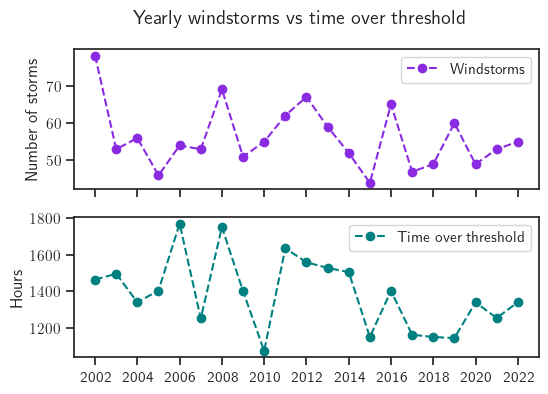

In [429]:
fig, ax = plt.subplots(2, sharex=True, figsize=(6,4))

ax[0].plot(windstorms_1min, 'o--', color='blueviolet', label='Windstorms')
ax[1].plot(yearly_hours_over_threshold, 'o--', color='teal', label='Time over threshold')

ax[0].set_xticks(ticks = np.arange(0,22,2), labels = np.arange(2002,2023,2))
ax[0].set_ylabel("Number of storms")
ax[0].tick_params(axis="y")
ax[0].legend(loc='upper right')

ax[1].set_ylabel("Hours")
ax[1].tick_params(axis="y")
ax[1].legend(loc='upper right')

fig.suptitle("Yearly windstorms vs time over threshold")
# fig.savefig('yearly_comparison.pdf')

Text(0.5, 0.98, 'Yearly windstorms vs time over threshold')

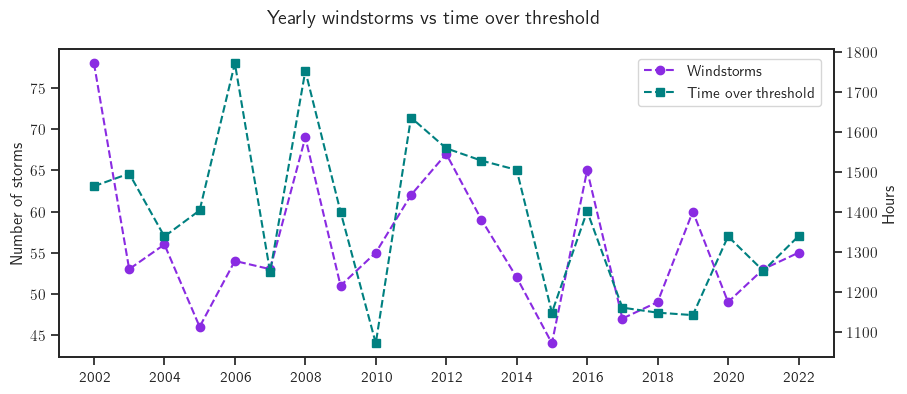

In [430]:
fig, ax1 = plt.subplots(figsize=(10, 4))
ax2 = ax1.twinx()

ax1.plot(windstorms_1min,'o--', color='blueviolet', label='Windstorms')
ax2.plot(yearly_hours_over_threshold,'s--', color='teal', label='Time over threshold')

# ax1.set_xlabel("Year")
ax1.set_xticks(ticks = np.arange(0,22,2), labels = np.arange(2002,2023,2))
ax1.set_ylabel("Number of storms")
ax1.tick_params(axis="y")

ax2.set_ylabel("Hours")
ax2.tick_params(axis="y")
fig.legend(loc='upper right', bbox_to_anchor=(0.895, 0.875))

fig.suptitle("Yearly windstorms vs time over threshold")
# fig.savefig('yearly_comparison.pdf')

In [431]:
scipy.stats.pearsonr(windstorms_1min, yearly_hours_over_threshold) 

PearsonRResult(statistic=0.4686507758841919, pvalue=0.032120113953730337)

In [436]:
yearly_hours_over_threshold_adj = np.delete(yearly_hours_over_threshold,0,None)
yearly_hours_over_threshold_adj

array([1495.8       , 1338.31666667, 1403.63333333, 1771.46666667,
       1249.68333333, 1752.45      , 1400.15      , 1071.31666667,
       1635.68333333, 1558.81666667, 1528.06666667, 1504.85      ,
       1148.05      , 1401.55      , 1160.43333333, 1147.86666667,
       1141.75      , 1338.68333333, 1252.4       , 1339.1       ])

In [439]:
scipy.stats.spearmanr(windstorms_1min_adj, yearly_hours_over_threshold_adj) 

SignificanceResult(statistic=0.4137162041884129, pvalue=0.06978503910527639)

In [440]:
scipy.stats.pearsonr(windstorms_1min_adj, yearly_hours_over_threshold_adj) 

PearsonRResult(statistic=0.5199896764855745, pvalue=0.018766468914514167)

Text(0.5, 0.98, 'Adjusted yearly windstorms vs time over threshold (Pearson $r=0.4427,p=0.0506$)')

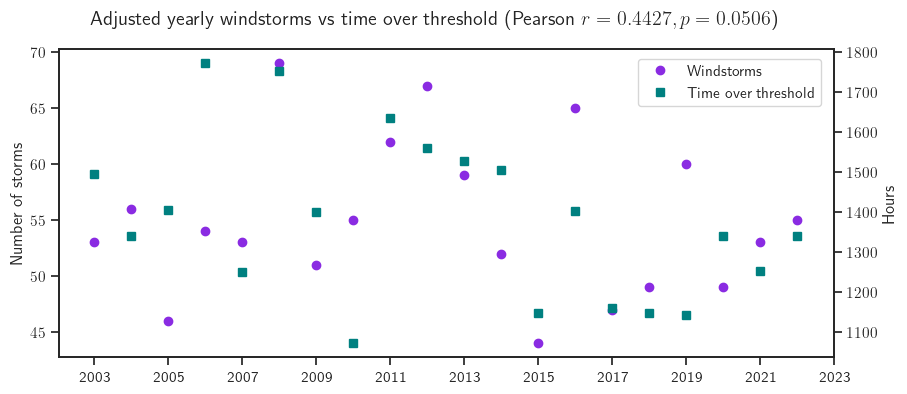

In [444]:
fig, ax1 = plt.subplots(figsize=(10, 4))
ax2 = ax1.twinx()

ax1.plot(windstorms_1min_adj,'o', color='blueviolet', label='Windstorms')
ax2.plot(yearly_hours_over_threshold_adj,'s', color='teal', label='Time over threshold')

# ax1.set_xlabel("Year")
ax1.set_xticks(ticks = np.arange(0,21,2), labels = np.arange(2003,2024,2))
ax1.set_ylabel("Number of storms")
ax1.tick_params(axis="y")

ax2.set_ylabel("Hours")
ax2.tick_params(axis="y")
fig.legend(loc='upper right', bbox_to_anchor=(0.895, 0.875))

fig.suptitle(r"Adjusted yearly windstorms vs time over threshold (Pearson $r=0.4427,p=0.0506$)")
# fig.savefig('yearly_comparison_adj2.pdf')

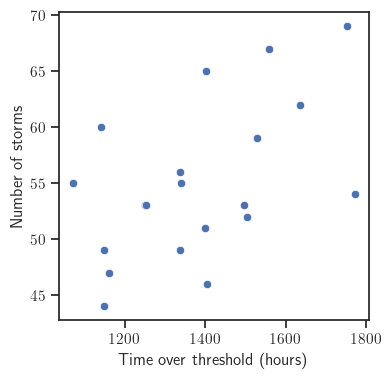

In [442]:
plt.figure(figsize=(4,4))
sns.scatterplot(x=yearly_hours_over_threshold_adj,y=windstorms_1min_adj);
plt.xlabel('Time over threshold (hours)')
plt.ylabel('Number of storms')
# plt.savefig('comparison_scatterplot.pdf',bbox_inches='tight')
plt.show()

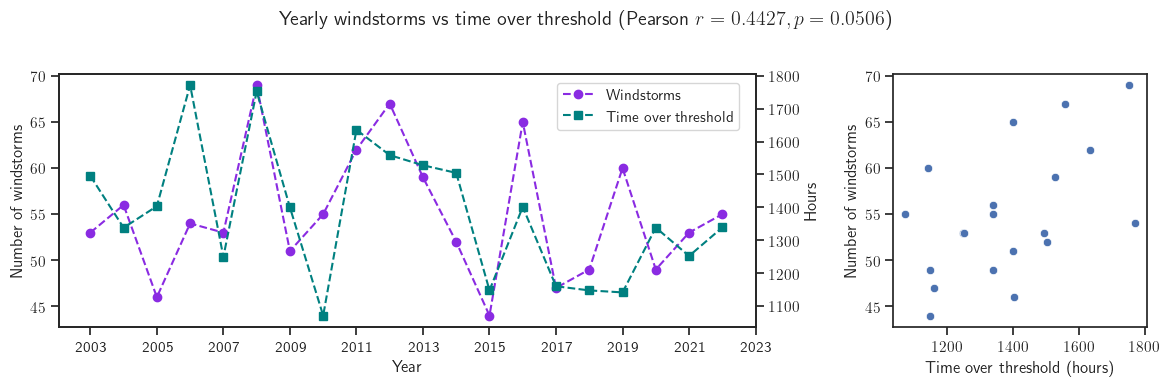

In [445]:
fig, ax = plt.subplots(1, 2, figsize=(12,4), gridspec_kw={'width_ratios': [2.75, 1]})
ax2 = ax[0].twinx()

# sns.regplot(x=years,y=windstorms_1min,n_boot=500,robust=True,x_ci=95,color='blueviolet',label='Annual windstorm frequency', ax=ax[0,0]) 
ax[0].plot(windstorms_1min_adj,'o--', color='blueviolet', label='Windstorms')
ax2.plot(yearly_hours_over_threshold_adj,'s--', color='teal', label='Time over threshold')
ax[0].set_ylabel('Number of windstorms')
ax[0].set_xlabel('Year')
ax[0].set_xticks(ticks = np.arange(0,21,2), labels = np.arange(2003,2024,2))
ax2.set_ylabel('Hours')
fig.legend(loc='upper right', bbox_to_anchor=(0.635, 0.815))

# sns.residplot(x=years, y=windstorms_1min, scatter_kws={"s": 40}, color='blueviolet', label='Residuals', ax=ax[0,1]);

sns.scatterplot(x=yearly_hours_over_threshold_adj,y=windstorms_1min_adj, ax=ax[1]);
ax[1].set_xlabel('Time over threshold (hours)')
ax[1].set_ylabel('Number of windstorms')

fig.suptitle(r"Yearly windstorms vs time over threshold (Pearson $r=0.4427,p=0.0506$)")
fig.tight_layout(pad=1.5)
# fig.savefig('yearly_comparison_w_scatterplot.pdf',bbox_inches='tight')

### Monthly

In [446]:
full_monthly_minutes_over_threshold = []
subset = ['Year', 'DOY', 'MST', f'Avg Wind Speed @ {height} [m/s]', f'Avg Wind Direction @ {height} [deg]', 'Temperature @ 2m [deg C]', 'Relative Humidity [%]']
# yearly_monthly_storms = [] #timeseries of windstorms computed monthly from 2002-2021 - may want to change shape to separate years later?

for i in np.arange(2002,2023,1): 
    year = i

    df = pd.read_csv(f'/Users/serena/Documents/Research/Data/{year}_data.csv', usecols=lambda x: x in subset)
    df.insert(2, 'Date', df['DOY'].apply(doy_to_date, args=(year,))) 
    df = df.replace(-99999.0, np.nan)
    df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y') # convert date column to DateTime
    df.set_index('Date')
    
    sort = list(df.groupby(df['Date'].dt.month))
    monthly_data = []
    
    for k in range(len(sort)): #12
        monthly_data.append(sort[k][1])    

    for j in range(len(monthly_data)): #12
        monthly_data[j] = monthly_data[j].reset_index()
        monthly_data[j] = monthly_data[j].rename(columns={'index': 'Overall index'})
        
        # monthly_minutes_over_threshold.append(count_over_threshold(monthly_data[j]['Avg Wind Speed @ 10m [m/s]'], 4.5))
        full_monthly_minutes_over_threshold.append(count_over_thresholds(monthly_data[j]['Avg Wind Speed @ 10m [m/s]'], 4.5, monthly_data[j]['Avg Wind Direction @ 10m [deg]'], [247, 337]))

    print(f'Finished {year}')

Finished 2002
Finished 2003
Finished 2004
Finished 2005
Finished 2006
Finished 2007
Finished 2008
Finished 2009
Finished 2010
Finished 2011
Finished 2012
Finished 2013
Finished 2014
Finished 2015
Finished 2016
Finished 2017
Finished 2018
Finished 2019
Finished 2020
Finished 2021
Finished 2022


In [451]:
full_monthly_hours_over_threshold = np.array(full_monthly_minutes_over_threshold)/60

# full_monthly_hours_over_threshold

In [448]:
(np.std(full_monthly_hours_over_threshold))**2

4594.42112029251

In [449]:
np.mean(full_monthly_hours_over_threshold)

115.5193783068783

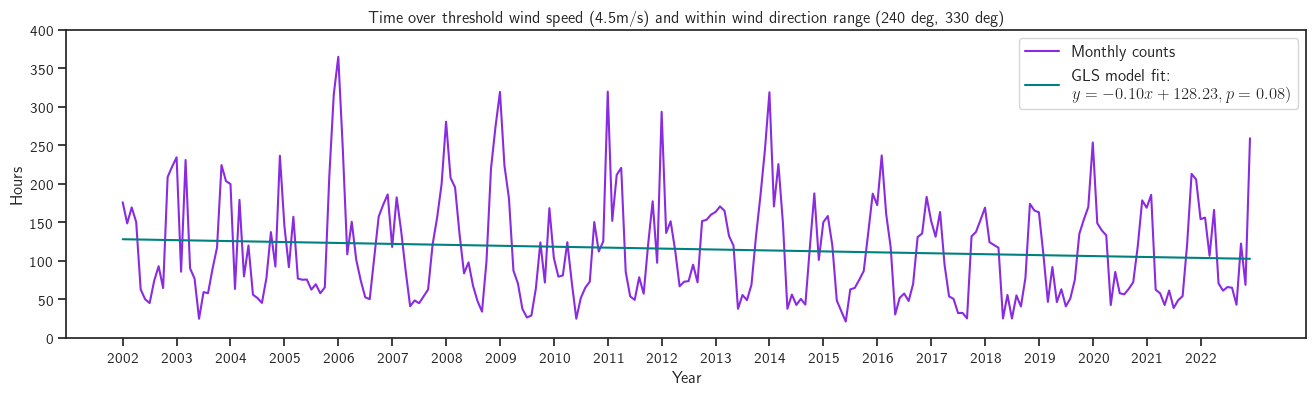

In [455]:
full_monthly_hours_over_threshold = np.array(full_monthly_minutes_over_threshold)/60

x = np.arange(len(y))
y = full_monthly_hours_over_threshold
mod = sm.GLS(y, sm.add_constant(x))
result = mod.fit()
gls_equation = "y = {:.2f}x + {:.2f}".format(result.params[1], result.params[0])

trendpoly = result.params[1]*x+result.params[0]

plt.figure(figsize=(16,4))
plt.plot(full_monthly_hours_over_threshold,'-', color='blueviolet', label='Monthly counts')

plt.plot(trendpoly, color='teal',label=f'GLS model fit: \n${gls_equation}, p={np.round(result.pvalues[1],2)})$')
plt.xlabel(f"Year")
plt.ylabel("Hours")
plt.xticks(ticks = (years-2002)*12, labels=years)
plt.yticks(ticks=plt.yticks()[0], labels=plt.yticks()[0].astype(int))
plt.legend(loc="best",prop={'size': 12}) 
plt.title(f"Time over threshold wind speed (4.5m/s) and within wind direction range (240 deg, 330 deg)")
# plt.savefig('full_monthly_timeoverthr.pdf')
plt.show()

In [456]:
np.mean(full_monthly_hours_over_threshold[0::12])

210.72460317460315

In [457]:
np.mean(full_monthly_hours_over_threshold[1::12])

152.94603174603176

In [458]:
average_hours_over_threshold = np.zeros(12)

for i in range(12):
    average_hours_over_threshold[i] = np.mean(full_monthly_hours_over_threshold[i::12])

In [459]:
average_hours_over_threshold

array([210.72460317, 152.94603175, 148.53015873, 115.63968254,
        64.90555556,  55.45952381,  50.87460317,  56.72222222,
        64.1952381 , 116.21111111, 157.63571429, 192.38809524])

In [460]:
months = np.arange(1,13)
month_names = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]

monthly_minutes_over_threshold = np.zeros(12)
for i in range(len(monthly_data)): 
    monthly_data[i] = monthly_data[i].reset_index()
    monthly_data[i] = monthly_data[i].rename(columns={'index': 'Overall index'})
    
    monthly_minutes_over_threshold[i] = count_over_thresholds(monthly_data[i]['Avg Wind Speed @ 10m [m/s]'], 4.5, monthly_data[i]['Avg Wind Direction @ 10m [deg]'], [240, 330])
                                                           
    print(f'Total hours over threshold in month {i+1}: {monthly_minutes_over_threshold[i]/60}')
    
monthly_hours_over_threshold = np.array(monthly_minutes_over_threshold)/60

Total hours over threshold in month 1: 153.81666666666666
Total hours over threshold in month 2: 155.6
Total hours over threshold in month 3: 106.38333333333334
Total hours over threshold in month 4: 166.71666666666667
Total hours over threshold in month 5: 71.45
Total hours over threshold in month 6: 60.11666666666667
Total hours over threshold in month 7: 64.16666666666667
Total hours over threshold in month 8: 63.15
Total hours over threshold in month 9: 41.4
Total hours over threshold in month 10: 124.2
Total hours over threshold in month 11: 69.35
Total hours over threshold in month 12: 262.75


#### Deseasonalizing

In [461]:
toth_df = {'Month': np.concatenate([months]*21).ravel(), 'Year': np.repeat((years), 12), 'Time over threshold': full_monthly_hours_over_threshold}
toth_df = pd.DataFrame(data=toth_df)
toth_df

Month  Year  Time over threshold
0        1  2002           176.200000
1        2  2002           148.783333
2        3  2002           169.533333
3        4  2002           150.650000
4        5  2002            63.016667
..     ...   ...                  ...
247      8  2022            65.250000
248      9  2022            43.166667
249     10  2022           122.566667
250     11  2022            68.950000
251     12  2022           259.333333

[252 rows x 3 columns]

In [462]:
analysis = toth_df[['Time over threshold']].copy()

s_dec_additive = seasonal_decompose(analysis, model = "additive", period=12, extrapolate_trend='freq')

observed_sd_toth = s_dec_additive.observed
trend_sd_toth = s_dec_additive.trend
seasonal_sd_toth = s_dec_additive.seasonal
residual_sd_toth = s_dec_additive.resid

decomposed_df_toth = pd.DataFrame({"Observed":observed_sd_toth, "Trend":trend_sd_toth, "Seasonal":seasonal_sd_toth, "Residual":residual_sd_toth})
decomposed_df_toth

Observed       Trend   Seasonal    Residual
0    176.200000  123.943714  95.215422  -42.959135
1    148.783333  123.898834  37.414979  -12.530481
2    169.533333  123.853955  33.117844   12.561534
3    150.650000  123.809076   0.213996   26.626928
4     63.016667  123.764197 -50.355031  -10.392499
..          ...         ...        ...         ...
247   65.250000  125.786743 -58.929782   -1.606961
248   43.166667  127.390589 -51.423418  -32.800505
249  122.566667  128.994436   0.609600   -7.037369
250   68.950000  130.598282  41.911104 -103.559385
251  259.333333  132.202128  76.549247   50.581958

[252 rows x 4 columns]

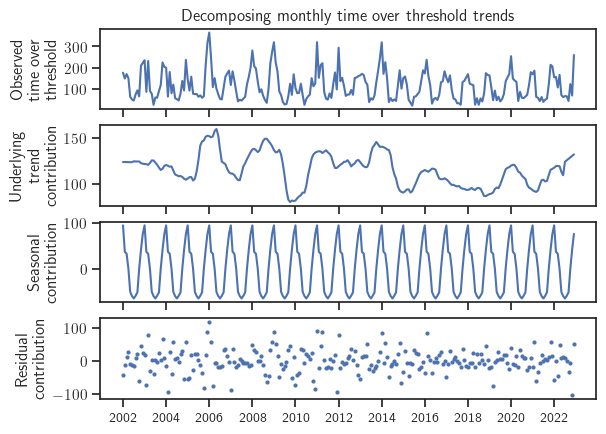

In [464]:
fig, ax = plt.subplots(4, 
           sharex='col', sharey='row')

ax[0].plot(decomposed_df_toth['Observed'])
ax[0].set(title='Decomposing monthly time over threshold trends',
          ylabel='Observed\ntime over\nthreshold')

ax[1].plot(decomposed_df_toth['Trend'])
ax[1].set(ylabel='Underlying\ntrend\ncontribution')

ax[2].plot(decomposed_df_toth['Seasonal'])
ax[2].set(ylabel='Seasonal\ncontribution')

ax[3].plot(decomposed_df_toth['Residual'], 'o', markersize=2)
ax[3].set(ylabel='Residual\ncontribution')
ax[3].set_xticks(np.arange(0,252,24))
ax[3].set_xticklabels(np.arange(2002,2023,2), fontsize=10)

plt.show()

# fig.savefig("detrended_timeoverthr.pdf",bbox_inches="tight")

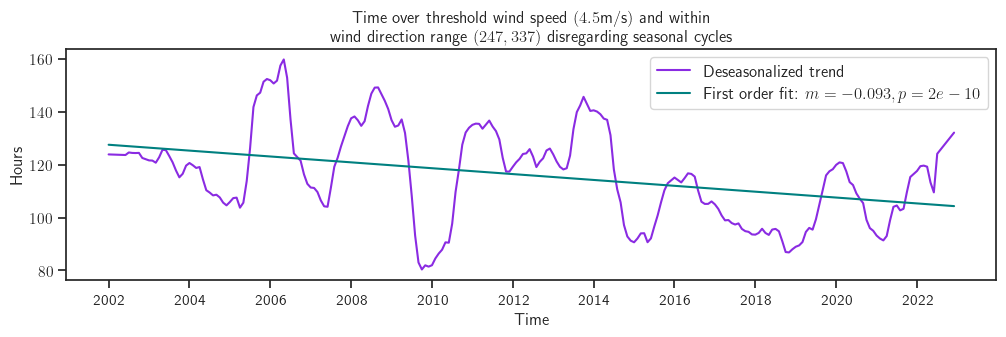

In [465]:
y = trend_sd_toth
x = np.arange(len(y))
x = sm.add_constant(x)

mod = sm.OLS(y, x)
result = mod.fit()

plt.figure(figsize=(12,3))
plt.plot(trend_sd_toth, color='blueviolet', label='Deseasonalized trend')

trend = np.polyfit(x=np.arange(0,252,1) , y=trend_sd_toth, deg=1)
trendpoly = np.poly1d(trend) 

plt.plot(np.arange(0,252,1),trendpoly(np.arange(0,252,1)), color='teal',label=f'First order fit: $m={np.round(trend[0],3)}, p={np.round(result.pvalues[1],10)}$')
plt.xlabel("Time")
plt.ylabel("Hours")
plt.xticks(ticks = np.arange(0,253,24), labels=np.arange(2002,2023,2))
plt.legend(loc="best",prop={'size': 12}) 
plt.title(f"Time over threshold wind speed $(4.5$m/s$)$ and within\nwind direction range $(247, 337)$ disregarding seasonal cycles")
# plt.savefig(f'des_timeoverthr.pdf',bbox_inches="tight")
plt.show()

In [468]:
scipy.stats.pearsonr(full_months, trend_sd_toth) 

PearsonRResult(statistic=-0.3858655486224329, pvalue=2.263700279601593e-10)

Text(0.5, 0.98, 'Deseasonalized windstorms vs time over threshold')

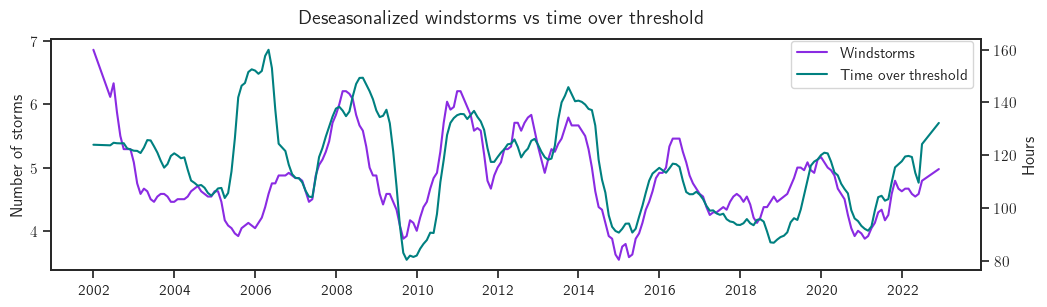

In [469]:
fig, ax1 = plt.subplots(figsize=(12, 3))
ax2 = ax1.twinx()

ax1.plot(windstorm_trend, color='blueviolet', label='Windstorms')
ax2.plot(trend_sd_toth, color='teal', label='Time over threshold')

ax1.set_xticks(ticks = np.arange(0,253,24), labels=np.arange(2002,2023,2))
ax1.set_ylabel("Number of storms")
ax1.tick_params(axis="y")

ax2.set_ylabel("Hours")
ax2.tick_params(axis="y")
fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9))

fig.suptitle("Deseasonalized windstorms vs time over threshold")
# fig.savefig('full_des_comparison2.pdf')

In [470]:
scipy.stats.spearmanr(windstorm_trend, trend_sd_toth) 

SignificanceResult(statistic=0.6017480018413033, pvalue=3.267045836734997e-26)

In [471]:
scipy.stats.kendalltau(windstorm_trend, trend_sd_toth) 

SignificanceResult(statistic=0.4573841356375775, pvalue=4.9845146909863666e-27)

In [472]:
scipy.stats.pearsonr(windstorm_trend, trend_sd_toth) 

PearsonRResult(statistic=0.5429541844258603, pvalue=1.006557710041854e-20)

In [473]:
np.median(lull_durations_median)

9.668461538461539

In [474]:
np.median(lulls_perstorm_median)

48.5

In [475]:
np.std(lulls_perstorm_median)

8.543074796823857